In [1]:
import numpy as np
import scipy
import math
import os

print('Okay')

Okay


In [2]:
PointConfiguration.set_engine('topcom')

In [2]:
def exist(pts, latt):
    latt = np.array(latt)
    for i in range(pts.shape[0]):
        if pts[i][0]==latt[0]:
            if pts[i][1]==latt[1]:
                if pts[i][2]==latt[2]:
                    return 1
    return 0

def contain(poly, latt):
    if poly.contains(latt) == 1:
        return 1
    else:
        poly_latt = Polyhedron(vertices = [tuple(latt)])
        vert = next(poly_latt.vertex_generator())
        face_eq = poly.Hrepresentation()
        for eq in face_eq:
            if eq.contains(vert) != 1:
                return 0
        return 1
    return 0

def check_latt(p):
    pts = np.array(p)
    pts_max = int(max(np.amax(pts, axis=0)))+1
    pts_min = int(min(np.amin(pts, axis=0)))-1
    print ('pts_max and pts_min: ', pts_max, pts_min)
    poly = Polyhedron(p)
    pts_new = pts
    for i in range(pts_min, pts_max):
        for j in range(pts_min, pts_max):
            for k in range(pts_min, pts_max):
                latt = [i,j,k]
                if exist(pts, latt) == 1:
                    continue
                if contain(poly, latt) == 1:
                    pts_new = np.append(pts_new, np.array(latt).reshape((1,3)), axis = 0)  
    pts_new = pts_new.tolist()
    return pts_new



def four_cross(v1, v2, v3, v4):
    #Compute cross product of three 4-vectors
    #print ("input vectors: ", v1, v2, v3, v4)
    v = np.zeros((4,))
    counter = 0
    
    for i in range(4):
        mat = [v1[np.arange(len(v1))!=i].tolist(), v2[np.arange(len(v2))!=i].tolist(), v3[np.arange(len(v3))!=i].tolist()]
        mat = matrix(ZZ, mat)
        #print ('matrix: ')
        #print (mat)
        if counter == 1:
            v[i] = -1*mat.det()
            counter = 0
            #print ('neg: ', v[i])
            continue
        elif counter == 0:
            v[i] = mat.det()
            counter = 1
            #print ('pos: ', v[i])
    #print v
    mat = matrix(RR, [v1.tolist(), v2.tolist(), v3.tolist(), v4.tolist()])
    
    if mat.det() < 0:
        #print ('original: ', v)
        v = -1*v
        #print('changed: ', v)
    #print ('vector: ', v)
    return v

def Hilb(triang_list):
    triang = []
    # Add 1 at the end of all verticies
    for tetra in triang_list:
        tetra_new = []
        for vert in tetra:
            vert_new = np.append(np.array(vert),1).tolist()
            tetra_new.append(vert_new)
        triang.append(tetra_new)
    
    triang = np.array(triang)
    # Add 1 to the end of all vectors
    power = np.zeros(shape = triang.shape)
    Hilb = 0
    t = var('t')
    t1 = var('t1')
    t2 = var('t2')
    t3 = var('t3')
    t4 = var('t4')
    for tri in range(triang.shape[0]):
        hilb = 1
        t_prod = 1
        for i in range(4):
            #Multiplying by -1 is optional
#             print 'triang:', triang[tri][i], triang[tri][np.remainder(i+1, 4)], triang[tri][np.remainder(i+2, 4)], triang[tri][np.remainder(i+3, 4)]
            power[tri][i] = -1*four_cross(triang[tri][i], triang[tri][np.remainder(i+1, 4)], triang[tri][np.remainder(i+2, 4)], triang[tri][np.remainder(i+3, 4)])
            t_prod = t1^(int(power[tri][i][0]))*t2^(int(power[tri][i][1]))*t3^(int(power[tri][i][2]))*t4^int((power[tri][i][3]))
#             print 'power:', power[tri][i]
#             print 't_prod:', t_prod
            hilb *= (1-t_prod)^(-1)
        #print ('Hilbert: ', hilb)
        Hilb += hilb
#     print ('Hilb: ', Hilb())
#     print (Hilb(t1=t, t2=t, t3=t).series(t4, 3))
    #print ("p-q web: ", power )
    
    
    m = var('m')
    b1 = var('b1')
    b2 = var('b2')
    b3 = var('b3')
    b4 = var('b4')
    Hilb *= m^4
    
    #print ('Hilb: ', str(Hilb(t1 = (m*b1).exp(), t2 = (m*b2).exp(), t3 = (m*b3).exp(), t4 = (m*4).exp())).replace('e', 'E'))
    Series = Hilb(t1 = (m*b1).exp(), t2 = (m*b2).exp(), t3 = (m*b3).exp(), t4 = (m*4).exp()).series(m==0, 1)
    
    Series = Series.truncate()
    
    return Series, triang, power

def idx_to_pts(triang, pts):
    # Input a list of lists of indicies
    # Output a list of lists of points
    triang_new = []
    for i in range(len(triang)):
        triang_new.append([pts[j] for j in triang[i]])
    return triang_new

print('Okay')

Okay


In [47]:
def lift_prism(h1, h2, h3):
    # h1 >= h2 >= h3
    
    triang = []
    power = []
    if h1 == h2 == h3:
        series = 0
        euler = 0
        prism = []
        # h1 = h2 = h3
        for h in range(h1):
            # 0 <= h < h1
            prism_1 = [[[1,0,0],[0,0,h],[0,0,h+1],[1,1,h3]]]
            prism_2 = [[[1,1,h3],[0,0,h],[0,0,h+1],[0,1,h2]]]
            prism += prism_1 + prism_2
            euler += 2
            
            series_1, triang_1, power_1 = Hilb(prism_1)
            series_2, triang_2, power_2 = Hilb(prism_2)
            series += series_1 + series_2
            triang.append(triang_1)
            triang.append(triang_2)
            power.append(power_1)
            power.append(power_2)
        return prism, series, triang, power, euler
            
    if h2 > h3:
        # h1 >= h2 > h3
        assert((h1 >= h2) and (h2 > h3))
        series = 0
        euler = 0
        prism = []
        for h in range(h3):
            # 0 <= h < h3
            prism_1 = [[[1,0,0],[0,0,h],[0,0,h+1],[1,1,h3]]]
            prism_2 = [[[0,1,h2],[0,0,h],[0,0,h+1],[1,1,h3]]]
            prism += prism_1 + prism_2
            euler += 2
            
            series_1, triang_1, power_1 = Hilb(prism_1)
            series_2, triang_2, power_2 = Hilb(prism_2)
            series += series_1 + series_2
            triang.append(triang_1)
            triang.append(triang_2)
            power.append(power_1)
            power.append(power_2)

        for h in range(h3,h2):
            # h3 <= h < h2
            prism_1 = [[[1,0,0],[0,0,h],[0,0,h+1],[1,1,h3]]]
            prism_2 = [[[0,1,h2],[0,0,h],[0,0,h+1],[1,1,h3]]]
            prism += prism_1 + prism_2
            euler += 2
            
            series_1, triang_1, power_1 = Hilb(prism_1)
            series_2, triang_2, power_2 = Hilb(prism_2)
            series += series_1 + series_2
            triang.append(triang_1)
            triang.append(triang_2)
            power.append(power_1)
            power.append(power_2)

        if h1 > h2:
            # h1 > h2 > h3
            assert(h1 > h2 and h2 > h3)
            for h in range(h2,h1):
                # h2 <= h < h1
                prism_1 = [[[1,0,0],[0,0,h],[0,0,h+1],[1,1,h3]]]
                prism_2 = [[[0,1,h2],[0,0,h],[0,0,h+1],[1,1,h3]]]
                prism += prism_1 + prism_2
                euler += 2
                
                series_1, triang_1, power_1 = Hilb(prism_1)
                series_2, triang_2, power_2 = Hilb(prism_2)
                series += series_1 + series_2
                triang.append(triang_1)
                triang.append(triang_2)
                power.append(power_1)
                power.append(power_2)
        return prism, series, triang, power, euler
        
    elif h2 < h3:
        series = 0
        euler = 0
        prism = []
        if h1 > h3:
            # h1 > h3 > h2
            assert(h1 > h3 and h3 > h2)
            for h in range(h2):
                # 0 <= h < h2
                prism_1 = [[[1,0,0],[0,0,h],[0,0,h+1],[0,1,h2]]]
                prism += prism_1
                euler += 1
                
                series_1, triang_1, power_1 = Hilb(prism_1)
                series += series_1
                triang.append(triang_1)
                power.append(power_1)
            
            # Middle prism:
            prism_1 = [[[1,0,0],[0,1,h2],[0,0,h2],[1,1,h3]]]
            prism += prism_1
            euler += 1
            
            series_1, triang_1, power_1 = Hilb(prism_1)
            series += series_1
            triang.append(triang_1)
            power.append(power_1)
            
            for h in range(h2,h3):
                # h2 <= h < h3
                prism_1 = [[[1,0,0],[0,0,h],[0,0,h+1],[1,1,h3]]]
                prism_2 = [[[0,1,h2],[0,0,h],[0,0,h+1],[1,1,h3]]]
                prism += prism_1 + prism_2
                euler += 2
                
                series_1, triang_1, power_1 = Hilb(prism_1)
                series_2, triang_2, power_2 = Hilb(prism_2)
                series += series_1 + series_2
                triang.append(triang_1)
                triang.append(triang_2)
                power.append(power_1)
                power.append(power_2)
            return prism, series, triang, power, euler
                
        else:
            # h1 = h3 > h2
            assert(h1 == h3 and h3 > h2)
            for h in range(h2):
                # 0 <= h < h2
                prism_1 = [[[1,0,0],[0,0,h],[0,0,h+1],[0,1,h2]]]
                prism += prism_1
                euler += 1
                
                series_1, triang_1, power_1 = Hilb(prism_1)
                series += series_1
                triang.append(triang_1)
                power.append(power_1)
                
            # Middle prism:
            prism_1 = [[[1,0,0],[0,1,h2],[0,0,h1],[1,1,h3]]]
            prism += prism_1
            euler += 1
            
            series_1, triang_1, power_1 = Hilb(prism_1)
            series += series_1
            triang.append(triang_1)
            power.append(power_1)
                
            for h in range(h2,h1):
                # h2 <= h < h1
                prism_1 = [[[1,0,0],[0,0,h],[0,0,h+1],[0,1,h2]]]
                prism += prism_1
                euler += 1
                
                series_1, triang_1, power_1 = Hilb(prism_1)
                series += series_1
                triang.append(triang_1)
                power.append(power_1)
            return prism, series, triang, power, euler
                
    else:
        assert(h2 == h3)
        assert(h1 > h2)
        # h1 > h2 = h3
        prism = []
        series = 0
        euler = 0
        for h in range(h2):
            # 0 <= h < h2
            prism_1 = [[[1,0,0],[0,0,h],[0,0,h+1],[1,1,h3]]]
            prism_2 = [[[0,1,h2],[0,0,h],[0,0,h+1],[1,1,h3]]]
            prism += prism_1 + prism_2
            euler += 2

            series_1, triang_1, power_1 = Hilb(prism_1)
            series_2, triang_2, power_2 = Hilb(prism_2)
            series += series_1 + series_2
            triang.append(triang_1)
            triang.append(triang_2)
            power.append(power_1)
            power.append(power_2)
        
        for h in range(h2,h1):
            # h2 <= h < h1
            prism_1 = [[[1,0,0],[0,0,h],[0,0,h+1],[1,1,h3]]]
            prism_2 = [[[0,1,h2],[0,0,h],[0,0,h+1],[1,1,h3]]]
            prism += prism_1 + prism_2
            euler += 2

            series_1, triang_1, power_1 = Hilb(prism_1)
            series_2, triang_2, power_2 = Hilb(prism_2)
            series += series_1 + series_2
            triang.append(triang_1)
            triang.append(triang_2)
            power.append(power_1)
            power.append(power_2)
        
    return prism, series, triang, power, euler

print('Okay.')

Okay.


In [4]:
def prism_plot(prism):
    count = 0
    plot = 0
    for p in prism:
        poly = Polyhedron(vertices=p)
        if count == 0:
            count += 1
            plot = poly.plot()
        else:
            plot += poly.plot()
    
#     print(poly_list.vertices())
    return plot


In [59]:
# numerical solver
import scipy.optimize
import csv
from scipy.optimize import fsolve
import itertools

def mesh_transform(x_neg, x_pos):
    x_neg = x_neg[::-1]
    return [0] + merge_lists(x_neg, x_pos)

def mesh_transform3D(xv,yv,zv):
    i_mid = -int(xv[0,0,0])
    j_mid = -int(yv[0,0,0])
    k_mid = -int(zv[0,0,0])
    if i_mid < xv.shape[0]:
        x_neg = xv[:i_mid,0,0].tolist()
        x_pos = xv[i_mid+1:,0,0].tolist()
        xv_new = mesh_transform(x_neg, x_pos)
        for i in range(xv.shape[0]):
            xv[i,:,:] = xv_new[i]
    if j_mid < yv.shape[1]:
        y_neg = yv[0,:j_mid,0].tolist()
        y_pos = yv[0,j_mid+1:,0].tolist()
        yv_new = mesh_transform(y_neg, y_pos)
        for j in range(yv.shape[1]):
            yv[:,j,:] = yv_new[j]
    if k_mid < zv.shape[2]:
        z_neg = zv[0,0,:i_mid].tolist()
        z_pos = zv[0,0,i_mid+1:].tolist()
        zv_new = mesh_transform(z_neg, z_pos)
        for k in range(zv.shape[2]):
            zv[:,:,k] = zv_new[k]
    return xv, yv, zv

def merge_lists(list1, list2):
    return [x for x in itertools.chain.from_iterable(itertools.izip_longest(list1,list2)) if x]

def find_bound(i,j,k, bound):
    b1_min = bound[0][i]
    b1_max = b1_min+1
    b2_min = bound[1][j]
    b2_max = b2_min+1
    b3_min = bound[2][k]
    b3_max = b3_min+1
    return [[b1_min, b1_max],[b2_min,b2_max],[b3_min,b3_max]]

def generate_grid(b3_max, b1_max=2, b2_max=2):
    l1 = np.linspace(0, b1_max, b1_max+1).tolist()
    l2 = np.linspace(0, b2_max, b2_max+1).tolist()
    l3 = np.linspace(0, b3_max, b3_max+1).tolist()
    return [l1,l2,l3]

def upper_bound(euler):
    return 0.85*euler

def lower_bound(euler):
    return 0.79*euler

def func(p, *d):
    f1, f2, f3 = d
    return (f1(b1 = p[0], b2 = p[1], b3 = p[2]), f2(b1 = p[0], b2 = p[1], b3 = p[2]), f3(b1 = p[0], b2 = p[1], b3 = p[2]))

def constraint(Series, sol, euler):
    vol = Series(b1 = sol[0], b2 = sol[1], b3 = sol[2])
    vol_min = lower_bound(euler)
    vol_max = upper_bound(euler)
    if 1.0/vol <= vol_max and 1.0/vol >= vol_min:
        return 1, vol
    
    print 'volume: ', vol, ' is out of bounds.'
    
    return 0, -1
    
def NSolve(Series, d, euler, bound=[[0,1],[0,1],[0,1]], MAX_COUNT=3):
    vol = -1
    sol = -1
    const = 0
    count = 0
    
    b1_min = bound[0][0]
    b1_max = bound[0][1]
    b2_min = bound[1][0]
    b2_max = bound[1][1]
    b3_min = bound[2][0]
    b3_max = bound[2][1]

    while const == 0:
        if count >= MAX_COUNT:
            return vol,sol
            
        count += 1
        d1_0 = np.random.uniform(low=b1_min, high=b1_max)
        d2_0 = np.random.uniform(low=b2_min, high=b2_max)
        d3_0 = np.random.uniform(low=b3_min, high=b3_max)
        print 'reset starting point: ', d1_0, d2_0, d3_0

        try:
            sol = fsolve(func, x0 = np.array([d1_0, d2_0, d3_0]), args = d)
            print 'solution: ', sol
            print 'guessed vol: ', Series(b1 = sol[0], b2 = sol[1], b3 = sol[2])
        except:
            continue
        
        const, vol = constraint(Series, sol, euler)

    print 'Done.'

    return vol, sol

def solver(series, h_max, num_triang, euler, sol_max=100):
    # find derivative
    d1 = diff(series, b1)
    d2 = diff(series, b2)
    d3 = diff(series, b3)
    d = (d1, d2, d3)
    
    # divide solution space into grids
    bounds = generate_grid(h_max)
    for i in range(len(bounds[0])):
        for j in range(len(bounds[1])):
            for k in range(len(bounds[2])):
                bound = find_bound(i,j,k, bounds)
                # try solve
                vol, sol = NSolve(series, d, euler, bound=bound)
                if type(sol) == int or type(vol) == int:
                    # sol = -1 and vol = -1
                    print ('range ', bound,' does not work')
                    continue
                if type(sol) == np.ndarray:
                    # edge case
                    sol = sol.tolist()
                if sol[0] > sol_max or sol[1] > sol_max or sol[2] > sol_max:
                    print ('solution out of bounds.')
                    continue
                if vol_min < vol < 1:
                    print ('vol:', vol, '; sol:', sol)
                    return vol, sol
    print('cannot find solution.')
    return -1,-1

def generate_vol(h_max, coeff=1):
    # Input:
    #   h_max: the max height of the polytope
    #   coeff: an empirical factor that determines the search space
    # Output:
    # triang_list: data for each polytope of height [h1,h2,h3]
    #   [h1,h2,h3]: heights
    #   vol: minimum volume
    #   sol: solution (i.e. the b's in the hilber series)
    #   prism: polytope point set
    #   series: hilbert series
    #   triang: triangulation of the polytope
    #   power: order of the t's in the hilbert series
    triang_list = []
    for h1 in range(1,h_max):
        for h2 in range(h1+1):
            for h3 in range(h2+1):
                print(h1,h2,h3)
                prism, series, triang, power, euler = lift_prism(h1,h2,h3)
                vol, sol = solver(series, h1*coeff, num_triang, euler)
                triang_list.append([[h1,h2,h3], vol, sol, prism, series, triang, power, num_triang, euler])
                print('')
    return triang_list
    
print('Okay.')

Okay.


In [172]:
'''
Input: given a set of bounds [[x_min, x_max],[y_min, y_max],[z_min, z_max]]

Do: divide the bounds into cubes, [[x_min, x_max],[y_min, y_max],[z_min, z_max]], and iterate over each cube

Example:
[[-1,2],[-3,2],[-1,1]]

'''
bounds = [[-1,2],[-3,2],[-1,1]]
x_min, x_max = bounds[0]
y_min, y_max = bounds[1]
z_min, z_max = bounds[2]
x = np.linspace(x_min, x_max-1, x_max-x_min)
y = np.linspace(y_min, y_max-1, y_max-y_min)
z = np.linspace(z_min, z_max-1, z_max-z_min)
xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')

In [317]:
import itertools



def merge_lists(list1, list2):
    return [x for x in itertools.chain.from_iterable(itertools.izip_longest(list1,list2)) if x]

def mesh_transform(x_neg, x_pos):
    x_neg = x_neg[::-1]
    return [0] + merge_lists(x_neg, x_pos)
#     xv_new = [None]*(len(x_neg) + len(x_pos))
#     print(len(xv_new[::2]))
#     print(len(xv_new[1::2]))
#     xv_new[::2] = x_pos
#     xv_new[1::2] = x_neg
#     xv_new = [0] + xv_new
#     return xv_new

def mesh_transform3D(xv,yv,zv):
    i_mid = -int(xv[0,0,0])
    j_mid = -int(yv[0,0,0])
    k_mid = -int(zv[0,0,0])
    if i_mid < xv.shape[0]:
        x_neg = xv[:i_mid,0,0].tolist()
        x_pos = xv[i_mid+1:,0,0].tolist()
        xv_new = mesh_transform(x_neg, x_pos)
        for i in range(xv.shape[0]):
            print i
            xv[i,:,:] = xv_new[i]
    if j_mid < yv.shape[1]:
        y_neg = yv[0,:j_mid,0].tolist()
        y_pos = yv[0,j_mid+1:,0].tolist()
        yv_new = mesh_transform(y_neg, y_pos)
        for j in range(yv.shape[1]):
            yv[:,j,:] = yv_new[j]
    if k_mid < zv.shape[2]:
        z_neg = zv[0,0,:i_mid].tolist()
        z_pos = zv[0,0,i_mid+1:].tolist()
        zv_new = mesh_transform(z_neg, z_pos)
        for k in range(zv.shape[2]):
            zv[:,:,k] = zv_new[k]
    return xv, yv, zv

In [181]:
mesh_transform3D(xv,yv,zv)

0
1
2


(array([[[ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]],
 
        [[ 1.,  1.],
         [ 1.,  1.],
         [ 1.,  1.],
         [ 1.,  1.],
         [ 1.,  1.]],
 
        [[ 1.,  1.],
         [ 1.,  1.],
         [ 1.,  1.],
         [ 1.,  1.],
         [ 1.,  1.]]]), array([[[ 0.,  0.],
         [-3., -3.],
         [ 1.,  1.],
         [ 1.,  1.],
         [-2., -2.]],
 
        [[ 0.,  0.],
         [-3., -3.],
         [ 1.,  1.],
         [ 1.,  1.],
         [-2., -2.]],
 
        [[ 0.,  0.],
         [-3., -3.],
         [ 1.,  1.],
         [ 1.,  1.],
         [-2., -2.]]]), array([[[ 0., -1.],
         [ 0., -1.],
         [ 0., -1.],
         [ 0., -1.],
         [ 0., -1.]],
 
        [[ 0., -1.],
         [ 0., -1.],
         [ 0., -1.],
         [ 0., -1.],
         [ 0., -1.]],
 
        [[ 0., -1.],
         [ 0., -1.],
         [ 0., -1.],
         [ 0., -1.],
         [ 0., -1.]]]))

In [0]:
# find derivative
d1 = diff(series, b1)
d2 = diff(series, b2)
d3 = diff(series, b3)
d = (d1, d2, d3)
# find the volume lower bound
vol_min_global = 1/h_max**3
# divide solution space into grids
x_max, y_max, z_max = b_max
x = np.linspace(0, x_max, x_max+1)
y = np.linspace(0, y_max, y_max+1)
z = np.linspace(0, z_max, z_max+1)
xv, yv, zv = np.meshgrid(x, y, z)
for i in range(x_max):
    for j in range(y_max):
        for k in range(z_max):
            # find the bounds
            b1_min = xv[i,j,k]
            b1_max = b1_min+1
            b2_min = yv[i,j,k]
            b2_max = b2_min+1
            b3_min = zv[i,j,k]
            b3_max = b3_min+1
            bounds = [[b1_min, b1_max],[b2_min,b2_max],[b3_min,b3_max]]
            # try solve
            vol, sol = NSolve(series, d, vol_min_global, bounds)
            if type(sol) == int or type(vol) == int:
                # sol = -1 and vol = -1
                print ('range ', b1_min,b2_min,b3_min,' does not work')
                continue
            if type(sol) == np.ndarray:
                # edge case
                sol = sol.tolist()
            if sol[0] > sol_max or sol[1] > sol_max or sol[2] > sol_max:
                print ('solution out of bounds.')
                continue
            if vol_min_global < vol < 1:
                print ('vol:', vol, '; sol:', sol)
                return vol, sol
print('cannot find solution.')

In [8]:
def poly_vol(p):
    verts = p.vertices()
    pts = np.array(verts)
    pts_max = np.amax(pts, axis=0)+1
    pts_min = np.amin(pts, axis=0)-1
    pts_new = []
    for i in range(pts_min[0], pts_max[0]):
        for j in range(pts_min[1], pts_max[1]):
            for k in range(pts_min[2], pts_max[2]):
                if p.contains([i,j,k]):
                    pts_new.append([i,j,k])
    print pts_new
    poly = PointConfiguration(pts_new)
    triang_idx = poly.restrict_to_regular_triangulations(True).triangulations_list()
#     print triang_idx
    triang_idx = max(triang_idx, key=len)
    num_triang = len(triang_idx)
    triang = [[pts_new[idx] for idx in idx_list] for idx_list in triang_idx]
    print 'volume bound: ', find_vol_bound(triang)
#     print triang
    series, triang, power = Hilb(triang)
    print int(np.amax(pts_max))
    vol, sol = solver(series, int(np.amax(pts_max)))
    return series, triang, power, vol, sol, num_triang

def lattice_vol(n, polygons = PALPreader(3)):
    p = polygons[n]
    return poly_vol(p)

NameError: name 'PALPreader' is not defined

In [360]:
def find_tetra_vol(triang):
    vol = 0
    for tetra in triang:
        p0 = tetra[0]
        a = np.array(tetra[1]) - np.array(tetra[0])
        b = np.array(tetra[2]) - np.array(tetra[0])
        c = np.array(tetra[3]) - np.array(tetra[0])
        tetra_vol = abs(np.dot(np.cross(a,b),c))/6.0
        vol += tetra_vol
    return vol

def find_vol_bound(triang):
    vol = find_tetra_vol(triang)
    h = np.ceil(2*vol)
    return 1/h

In [362]:
h1,h2,h3 = [2,1,1]
verts = [[1,0,0],[0,0,0],[0,0,h1],[0,1,h2],[1,1,h3]]
p = Polyhedron(vertices = verts)
poly_vol(p)

[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


volume bound:  0.5
3
3
reset starting point:  0.497319369624 0.948967133502 0.178220424513
solution: 

 [  4.87328482e+38   5.70163173e+38  -1.40244644e+39]
guessed vol:  -8.666184759359001e-156
volume:  8.666184759359001e-156  is out of bounds.
reset starting point:  0.611782595586 0.13450633969 0.333078863201
solution:  [ 1.50000216  1.49999351  3.49999568]
guessed vol:  0.29629629630423066
Done.
('vol:', 0.29629629630423066, '; sol:', [1.5000021565534492, 1.499993514440545, 3.499995679973668])


(-1/((2*b1 - b2 + b3 - 8)*(b1 - b2 + b3 - 4)*(b1 - b2)*b2) + 1/((b1 + b3 - 4)*b1*(b2 - b3)*b2) + 1/((b1 - b2)*b1*(b2 + b3 - 8)*(b3 - 4)) - 1/((b1 - b2 + b3 - 4)*(b1 + b3 - 4)*(b2 - b3)*(b3 - 4)),
 array([[[0, 0, 0, 1],
         [0, 0, 1, 1],
         [0, 1, 1, 1],
         [1, 0, 0, 1]],
 
        [[0, 0, 1, 1],
         [0, 0, 2, 1],
         [0, 1, 1, 1],
         [1, 1, 1, 1]],
 
        [[0, 0, 1, 1],
         [0, 0, 2, 1],
         [1, 0, 0, 1],
         [1, 1, 1, 1]],
 
        [[0, 0, 1, 1],
         [0, 1, 1, 1],
         [1, 0, 0, 1],
         [1, 1, 1, 1]]]),
 array([[[ 1., -0., -0., -0.],
         [-1.,  0., -1.,  1.],
         [-0., -1.,  1., -0.],
         [ 0.,  1.,  0.,  0.]],
 
        [[ 1., -0., -0., -0.],
         [ 0., -1., -1.,  2.],
         [-0., -0.,  1., -1.],
         [-1.,  1.,  0.,  0.]],
 
        [[ 0.,  1.,  0.,  0.],
         [-2.,  1., -1.,  2.],
         [ 1., -1.,  1., -1.],
         [ 1., -1., -0., -0.]],
 
        [[ 1., -0.,  1., -1.],
         [ 0

In [6]:
from sage.geometry.polyhedron.palp_database import PALPreader

In [9]:
polygons = PALPreader(3)

In [101]:
n = 10
print polygons[n].vertices()
polygons[n].plot()

(A vertex at (-6, -4, -1), A vertex at (0, 0, 1), A vertex at (0, 1, 0), A vertex at (1, 0, 0))


" 
 width="100%"
 height="500"
 style="border: 0;">

In [67]:
latt_poly = lattice_polytope.cross_polytope(3)
latt_poly.plot3d().show()

" 
 width="100%"
 height="500"
 style="border: 0;">

In [71]:
series, triang, power, vol, sol = lattice_vol(2)

-1/((2*b1 - b2 - b3 + 4)*(b1 - b2)*(b1 - 2*b3)*b3) + 1/((2*b1 - b2 - b3 + 4)*(b1 - b2)*b1*b3) - 1/((b1 - b2)*(b1 - 2*b2 + b3 - 4)*(b2 - 2*b3)*b3) + 1/((b1 + b2 - 5*b3 - 4)*(b1 - 2*b3)*(b2 - 2*b3)*b3) + 1/((b1 - b2)*(b1 - 2*b2 + b3 - 4)*b2*b3) - 1/((b1 + b2 + b3 - 4)*b1*b2*b3)
reset starting point:  0.858946798414 0.599251705145 0.0202183621227
solution:  [-0.96198593 -0.96204408  0.02247666]
guessed vol:  0.16669684805674478
Done.
('vol:', 0.16669684805674478, '; sol:', [-0.9619859296050474, -0.9620440827046711, 0.02247666380048766])


In [108]:
verts = [[-4,-4,-3],[-3,-3,-2],[-2,-2,-1],[-1,-1,0],[-1,-1,-1],[0,0,0],[0,0,1],[1,0,0],[0,1,0]]
print len(verts)

9


In [335]:
print series
print series_2
print triang
print triang_2
print vol, sol
print vol_2, sol_2

1/((2*b1 - b2 + b3 - 8)*(2*b1 + b3 - 8)*(b1 - b2 + b3 - 4)*(b1 + b3 - 8)) + 1/((b1 + b2 + b3 - 12)*(b1 - b2)*(b1 + b3 - 8)*b1) + 1/((b1 - b2 + b3 - 4)*(b1 - 2*b2 + b3)*(2*b2 - b3)*(b2 - b3)) - 1/((3*b1 - b2 + b3 - 12)*(2*b1 - b2 + b3 - 8)*(b1 - b2)*b2) - 1/((2*b1 + b3 - 8)*(b1 - b2 + b3 - 4)*b1*b2) + 1/((b1 - b2 + b3 - 4)*b1*(2*b2 - b3)*b2)
1/((b1 - b2 + b3 - 4)*(b1 - b2)*(b1 - 2*b2 + b3)*b1) + 1/((b1 + b2 + b3 - 12)*(b1 - b2)*(b1 + b3 - 8)*b1) + 1/((b1 - b2 + b3 - 4)*(b1 - b2)*(b1 + b3 - 8)*b1) - 1/((3*b1 - b2 + b3 - 12)*(2*b1 - b2 + b3 - 8)*(b1 - b2)*b2) - 1/((2*b1 - b2 + b3 - 8)*(b1 - b2 + b3 - 4)*(b1 - b2)*b2) + 1/((b1 - b2 + b3 - 4)*(b1 - b2)*(b2 - b3)*b2)
[[[0 0 0 1]
  [0 0 1 1]
  [0 1 2 1]
  [1 0 0 1]]

 [[0 0 0 1]
  [0 1 2 1]
  [1 0 0 1]
  [1 1 1 1]]

 [[0 0 1 1]
  [0 0 2 1]
  [0 1 2 1]
  [1 0 0 1]]

 [[0 0 2 1]
  [0 0 3 1]
  [0 1 2 1]
  [1 1 1 1]]

 [[0 0 2 1]
  [0 0 3 1]
  [1 0 0 1]
  [1 1 1 1]]

 [[0 0 2 1]
  [0 1 2 1]
  [1 0 0 1]
  [1 1 1 1]]]
[array([[[1, 0, 0, 1],
       

In [342]:
print series
print series_2
print triang
print triang_2
print vol, sol
print vol_2, sol_2

1/((b1 + b2 + b3 - 12)*(b1 - b2)*(b1 + b3 - 8)*b1) + 1/4/((b1 - b2)*(b1 - 2*b2 + b3)*(b1 + b3 - 8)*b1) - 1/((3*b1 - b2 + b3 - 12)*(2*b1 - b2 + b3 - 8)*(b1 - b2)*b2) + 1/4/((2*b1 - b2 + b3 - 8)*(b1 - b2)*(b2 - b3)*b2)
1/((b1 - b2 + b3 - 4)*(b1 - b2)*(b1 - 2*b2 + b3)*b1) + 1/((b1 + b2 + b3 - 12)*(b1 - b2)*(b1 + b3 - 8)*b1) + 1/((b1 - b2 + b3 - 4)*(b1 - b2)*(b1 + b3 - 8)*b1) - 1/((3*b1 - b2 + b3 - 12)*(2*b1 - b2 + b3 - 8)*(b1 - b2)*b2) - 1/((2*b1 - b2 + b3 - 8)*(b1 - b2 + b3 - 4)*(b1 - b2)*b2) + 1/((b1 - b2 + b3 - 4)*(b1 - b2)*(b2 - b3)*b2)
[[[0 0 0 1]
  [0 0 2 1]
  [0 1 2 1]
  [1 1 1 1]]

 [[0 0 0 1]
  [0 0 2 1]
  [1 0 0 1]
  [1 1 1 1]]

 [[0 0 2 1]
  [0 0 3 1]
  [0 1 2 1]
  [1 1 1 1]]

 [[0 0 2 1]
  [0 0 3 1]
  [1 0 0 1]
  [1 1 1 1]]]
[array([[[1, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [1, 1, 1, 1]]]), array([[[0, 1, 2, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [1, 1, 1, 1]]]), array([[[1, 0, 0, 1],
        [0, 0, 1, 1],
        [0, 0, 2, 1],
       

In [349]:
h1,h2,h3 = [3,2,1]
verts = [[1,0,0],[0,0,0],[0,0,h1],[0,1,h2],[1,1,h3]]
p = Polyhedron(vertices = verts)
series, triang, power, vol, sol = poly_vol(p)
print 'vol: ', vol
print 'sol: ', sol
print '==='
coeff = 2
prism_2, series_2, triang_2, power_2 = lift_prism(h1,h2,h3)
vol_2, sol_2 = solver(series_2, h1*coeff)
print 'vol: ', vol_2
print 'sol: ', sol_2

[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 2], [1, 0, 0], [1, 1, 1]]


4
4
reset starting point:  0.277416432611 0.929510175252 0.811751256906
solution: 

 [ 2.55275417  2.55276017  0.29225475]
guessed vol:  -0.01986560431464568
Done.
('vol:', 0.01986560431464568, '; sol:', [2.552754170275812, 2.552760165651463, 0.29225474667807166])
vol:  0.01986560431464568
sol:  [2.552754170275812, 2.552760165651463, 0.29225474667807166]
===
6
reset starting point:  0.126900727919 0.130746933832 0.438478859399
solution: 

 [ 1.46731679  1.46730285  5.0426432 ]
guessed vol:  0.20731663260085043
Done.
('vol:', 0.20731663260085043, '; sol:', [1.4673167938785052, 1.4673028454442048, 5.042643199718594])
vol:  0.20731663260085043
sol:  [1.4673167938785052, 1.4673028454442048, 5.042643199718594]


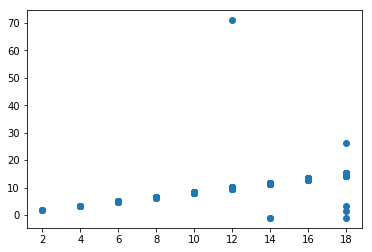

In [408]:
plt.scatter(euler, np.reciprocal(vol_list))

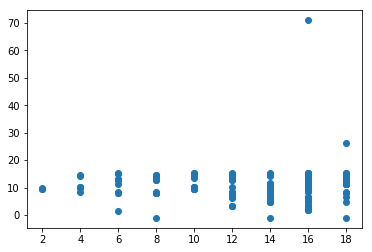

In [13]:
euler_plot = []
vol_list = []
for key, value in vol_dict.iteritems():
    euler_plot.append(value[0])
    vol_list.append(value[1])

plt.scatter(euler, np.reciprocal(vol_list))

In [53]:
vol_list_2 = generate_vol(10)

(1, 0, 0)
reset starting point:  0.012325327499 0.513273762565 0.180696053892


/ext/sage/sage-8.4_1804/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


solution:  [  1.00000000e+00   4.37996904e+22   2.00000000e+00]
guessed vol:  -5.212642238263105e-46


volume:  -5.212642238263105e-46  is out of bounds.
reset starting point:  0.0248775955878 0.993932430338 0.282192120506
solution:  [  1.00000000e+00   4.06538781e+21   2.00000000e+00]
guessed vol:  -6.050566497252016e-44
volume:  -6.050566497252016e-44  is out of bounds.
reset starting point:  0.779786161861

 0.465822857894 0.892686243982
solution:  [ 1.50000281  1.4999948   1.00000061]
guessed vol:  0.5925925926130731
Done.
('vol:', 0.5925925926130731, '; sol:', [1.5000028061474475, 1.499994800132724, 1.0000006078870418])

(1, 1, 0)
reset starting point:  0.478369836087 0.481199294576 0.633804130653
solution:  [ 1.49999719  1.50000733  1.50000383]
guessed vol:  0.5925925926057971
Done.
('vol:', 0.5925925926057971, '; sol:', [1.4999971931215679, 1.5000073273301016, 1.5000038312578723])

(1, 1, 1)
reset starting point:  0.117034654719 0.52467007859 0.610388835301
solution:  [ 1.50000361  1.49999531  2.49999558]
guessed vol:  0.5925925926130731
Done.
('vol:', 0.5925925926130731, '; sol:', [1.5000036085363817, 1.4999953072909329, 2.4999955783266485])

(2, 0, 0)


reset starting point:  0.666068076325 0.623990220805 0.729170113664
solution:  [ 1.50002087  1.50004913  1.99993035]
guessed vol:  0.2962962966739724
Done.
('vol:', 0.2962962966739724, '; sol:', [1.5000208656463772, 1.5000491335425172, 1.999930354125283])

(2, 1, 0)
reset starting point:  0.293545754168 0.619804714691 0.00799730897136


/ext/sage/sage-8.4_1804/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)


solution:  [ -1.55181564e+38   1.02717906e+38   2.30115031e+36]
guessed vol:  -1.0260252585907441e-151
volume:  -1.0260252585907441e-151  is out of bounds.
reset starting point:  0.395699647222 0.396391480878 0.712821918978
solution:  [ 1.46406701  1.46383475  2.53582081]
guessed vol:  0.3126157112419605
Done.
('vol:', 0.3126157112419605, '; sol:', [1.4640670140734433, 1.463834749404041, 2.5358208140916147])

(2, 1, 1)
reset starting point:  0.346131921127 0.403380686008 0.0602921604372


solution:  [  3.15683365e+38   3.91252525e+38  -1.00498318e+39]
guessed vol:  -3.4495011012099897e-155
volume:  -3.4495011012099897e-155  is out of bounds.
reset starting point:  0.408488005559 0.638177747725 0.575879195109
solution: 

 [  4.13603126e+35   1.70746770e+36  -2.91247415e+36]
guessed vol:  -6.1965754972785535e-145
volume:  -6.1965754972785535e-145  is out of bounds.
reset starting point:  0.506525009629 0.0371022970742 0.107354337545
solution:  [ 1.50001285  1.49998972  3.49998854]
guessed vol:  0.29629629633927834
Done.
('vol:', 0.29629629633927834, '; sol:', [1.5000128526735892, 1.4999897221988756, 3.499988535812815])

(2, 2, 0)
reset starting point:  0.798551943788 0.989294158977 0.819184440637
solution:  [ 1.49999564  1.49998904  3.00002465]
guessed vol:  0.2962962963647442
Done.
('vol:', 0.2962962963647442, '; sol:', [1.4999956427057135, 1.499989036626401, 3.000024651256891])

(2, 2, 1)


reset starting point:  0.659128469312 0.239738245826 0.0897396404201


solution:  [ 5.23606798  0.76393202 -3.30056308]
guessed vol:  -0.12499999999999989
volume:  -0.12499999999999989  is out of bounds.
reset starting point:  0.411214808015 0.633076639965 0.142778174951
solution:  [ 2.99998741  3.00000868  0.3944672 ]
guessed vol:  -0.009259259259351893
volume:  -0.009259259259351893  is out of bounds.
reset starting point:  0.234254678131 0.411473297198 0.626294488379


solution:  [ 1.46421453  1.46432308  3.99966831]
guessed vol:  0.3126157196238637
Done.
('vol:', 0.3126157196238637, '; sol:', [1.4642145269648106, 1.4643230821831006, 3.9996683075640576])

(2, 2, 2)
reset starting point:  0.743268561567 0.153293090994 0.0601382482496
solution:  [  4.84355391e+37   1.95280993e+37  -2.72497185e+38]
guessed vol:  -3.6144948609206877e-152
volume:  -3.6144948609206877e-152  is out of bounds.
reset starting point:  0.836760408213 0.298582096631 0.83536779547
solution:  [ 1.4999917   1.50000345  5.00000941]
guessed vol:  0.2962962963138125
Done.
('vol:', 0.2962962963138125, '; sol:', [1.4999916956647525, 1.5000034530117161, 5.000009410200332])

(3, 0, 0)
reset starting point:  0.78176278135 0.886310557183 0.0247629535934
solution: 

 [ 1.50000563  1.49999444  2.99999995]
guessed vol:  0.19753086421587795
Done.
('vol:', 0.19753086421587795, '; sol:', [1.5000056269017252, 1.4999944370382803, 2.9999999517841016])

(3, 1, 0)
reset starting point:  0.548283685304 0.781947501131 0.686965043732
solution:  [ 1.46730584  1.46730878  3.57535254]
guessed vol:  0.20731663260085043
Done.
('vol:', 0.20731663260085043, '; sol:', [1.467305836364256, 1.4673087845443633, 3.5753525375307458])

(3, 1, 1)
reset starting point:  0.120126877237 0.784737598903 0.82021297789
solution:  [ 1.49999486  1.5000036   4.50000476]
guessed vol:  0.19753086419950705
Done.
('vol:', 0.19753086419950705, '; sol:', [1.4999948583296172, 1.5000035956334465, 4.500004755842745])

(3, 2, 0)


reset starting point:  0.378505372772 0.681977980876 0.366141080901
solution:  [ 0.73235969  7.43214102  0.76327875]
guessed vol:  -0.029410840074048063
volume:  -0.029410840074048063  is out of bounds.
reset starting point:  0.351547553916 0.796819487455 0.95614081473


solution:  [ 1.46730216  1.4673188   4.02273886]
guessed vol:  0.20731663260085043
Done.
('vol:', 0.20731663260085043, '; sol:', [1.4673021562562425, 1.4673187994868744, 4.022738855625916])

(3, 2, 1)
reset starting point:  0.783577309186 0.919863805945 0.214648163866
solution:  [ 2.55275457  2.55273998  0.29222174]
guessed vol:  -0.019865604315782548
volume:  -0.019865604315782548  is out of bounds.
reset starting point:  0.920912747724 0.264571227568 0.100290587541
solution: 

 [ 4.16685535  0.79364395 -2.14521327]
guessed vol:  -0.20988314140743336
volume:  -0.20988314140743336  is out of bounds.
reset starting point:  0.440583338486 0.0322368386068 0.945310722107
solution:  [ 1.46732154  1.46730834  5.04264513]
guessed vol:  0.20731663261358335
Done.
('vol:', 0.20731663261358335, '; sol:', [1.4673215442829084, 1.4673083382588938, 5.0426451307546785])

(3, 2, 2)
reset starting point:  0.976258111703 0.886837060056 0.950816261367


solution:  [  4.71974089e+36   8.10317970e+38  -1.71628576e+39]
guessed vol:  -2.6057669654329714e-154
volume:  -2.6057669654329714e-154  is out of bounds.
reset starting point:  0.138098902846 0.607905182084 0.80747642427


solution:  [  6.25771182e+37   1.07364181e+38  -3.16714126e+38]
guessed vol:  -6.20554353109515e-153
volume:  -6.20554353109515e-153  is out of bounds.
reset starting point:  0.476022821077 0.682370714048 0.79007897734


solution:  [  2.32306917e+38   3.70870497e+38  -8.40740333e+38]
guessed vol:  -8.368372190217645e-155
volume:  -8.368372190217645e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.134917277338 0.862578263299 1.7443889175
solution: 

 [ 1.49997113  1.49998229  5.99999952]
guessed vol:  0.19753086428681854
Done.
('vol:', 0.19753086428681854, '; sol:', [1.4999711263998698, 1.4999822872179278, 5.999999516803021])

(3, 3, 0)
reset starting point:  0.0807493146338 0.340984364234 0.0713183927019
solution:  

[  1.00000371e+00   6.70124119e+10   3.00005597e+00]
guessed vol:  -7.422808347459944e-23
volume:  -7.422808347459944e-23  is out of bounds.
reset starting point:  0.458021483473 0.83621901645 0.504261298912
solution:  [  9.99987523e-01   6.44425661e+08   3.00014463e+00]
guessed vol:  -8.026627253924269e-19
volume:  -8.026627253924269e-19  is out of bounds.
reset starting point:  0.634643656556 0.103762952183 0.64745219735
solution:  [ 1.50000904  1.49999423  4.49997623]
guessed vol:  0.19753086421769694
Done.
('vol:', 0.19753086421769694, '; sol:', [1.5000090418460845, 1.49999423176838, 4.499976233787343])

(3, 3, 1)
reset starting point:  0.756946454989 0.454051912874 0.997995595173
solution: 

 [ 1.46729673  1.46730792  5.49005223]
guessed vol:  0.2073166325862985
Done.
('vol:', 0.2073166325862985, '; sol:', [1.4672967335992646, 1.4673079195457892, 5.490052233375065])

(3, 3, 2)
reset starting point:  0.977898737589 0.148389305354 0.858659898096
solution:  [ 1.46730129  1.4673172   6.50999055]
guessed vol:  0.2073166326044884
Done.
('vol:', 0.2073166326044884, '; sol:', [1.4673012873077076, 1.4673172035852382, 6.509990546370267])

(3, 3, 3)


reset starting point:  0.598919750084 0.292732378196 0.726893604653
solution:  [  1.23161491e+37   1.33443407e+37  -2.07780190e+37]
guessed vol:  -3.6815220674347957e-149
volume:  -3.6815220674347957e-149  is out of bounds.
reset starting point:  0.491095815604 0.222573254657 0.519576756818


solution:  [  1.19713605e+35   7.80335939e+34  -3.08929646e+35]
guessed vol:  -5.653004752016209e-141
volume:  -5.653004752016209e-141  is out of bounds.
reset starting point:  0.70975868883 0.915762362657 0.154080302807


solution:  [  1.54598066e+39   1.68443531e+39  -8.20126771e+39]
guessed vol:  -1.6302129761725395e-158
volume:  -1.6302129761725395e-158  is out of bounds.
solution out of bounds.
reset starting point:  0.45975398287 0.0256851028503 1.94750126241
solution:  [  1.57325748e+05   9.99995234e-01   9.00017012e+00]
guessed vol:  -1.3467427888872416e-11
volume:  -1.3467427888872416e-11

  is out of bounds.
reset starting point:  0.140847262686 0.848476805131 1.4139229554
solution:  [  5.02191638e+37   1.44032134e+38  -5.46728084e+38]
guessed vol:  -9.160160441300981e-154
volume:  -9.160160441300981e-154  is out of bounds.
reset starting point:  0.511390752942 0.878622830054 1.22564845966
solution:  [  1.01717748e+38   1.16535485e+38  -4.52537155e+38]
guessed vol:  -1.1252891194410937e-153


volume:  -1.1252891194410937e-153  is out of bounds.
solution out of bounds.
reset starting point:  0.258160415409 0.127142930698 2.71090668549
solution:  [ 1.4999931   1.50001393  7.50007425]
guessed vol:  0.19753086424498179
Done.
('vol:', 0.19753086424498179, '; sol:', [1.4999931026574373, 1.5000139291439463, 7.500074254997263])

(4, 0, 0)
reset starting point:  0.4517437002 0.477520266851 0.681917386945
solution:  [ 1.49999736  1.50000486  3.99999778]
guessed vol:  0.14814814815599675
Done.
('vol:', 0.14814814815599675, '; sol:', [1.499997359642324, 1.5000048637598218, 3.999997776972638])

(4, 1, 0)


reset starting point:  0.973707203851 0.313020985577 0.696291728739
solution:  [ 1.47152341  1.47153273  4.6029854 ]
guessed vol:  0.1544368065560775
Done.
('vol:', 0.1544368065560775, '; sol:', [1.471523414259503, 1.47153273026541, 4.602985396946108])

(4, 1, 1)
reset starting point:  0.232178075719 0.398998784157 0.957800074648
solution:  

[ 1.4999911   1.49999998  5.5000089 ]
guessed vol:  0.14814814815326827
Done.
('vol:', 0.14814814815326827, '; sol:', [1.4999910956970401, 1.4999999750968123, 5.500008903693452])

(4, 2, 0)
reset starting point:  0.112084796141 0.479271340188 0.0306510707257


solution:  [ 0.76393202  5.23606798  0.81528171]
guessed vol:  -0.06249999999999999
volume:  -0.06249999999999999  is out of bounds.
reset starting point:  0.666699337081 0.193484856864 0.688551916675
solution:  [ 1.46338741  1.46398719  5.07527241]
guessed vol:  0.15630791828152724
Done.
('vol:', 0.15630791828152724, '; sol:', [1.4633874086586105, 1.4639871889289704, 5.075272406845747])

(4, 2, 1)


reset starting point:  0.260672470775 0.324164075946 0.174076710899


solution:  [ 2.3855015   2.38551308  0.23573944]
guessed vol:  -0.0274159393568425
volume:  -0.0274159393568425  is out of bounds.
reset starting point:  0.299358736263 0.990851207572 0.416448788557
solution:  [ 2.38552304  2.38550902  0.23572438]
guessed vol:  -0.027415939356387753
volume:  -0.027415939356387753  is out of bounds.
reset starting point:  0.806702303265 0.398541240981 0.299961428668
solution:  [ 3.82011272  0.80760596 -1.75706941]
guessed vol:  -0.25818396310921554


volume:  -0.25818396310921554  is out of bounds.
reset starting point:  0.254694653662 0.788972583189 1.60791016722
solution: 

 [ 1.47152462  1.47153463  6.07451617]
guessed vol:  0.15443680655153003
Done.
('vol:', 0.15443680655153003, '; sol:', [1.4715246222984464, 1.471534625468732, 6.074516171748058])

(4, 2, 2)
reset starting point:  0.794903679408 0.443047898742 0.911486799624
solution:  [ -8.69515180e+18   1.00000000e+00   1.00000000e+01]


guessed vol:  -3.3066305376469275e-39
volume:  -3.3066305376469275e-39  is out of bounds.
reset starting point:  0.888452855179 0.172652183544 0.277407108582
solution:  [  2.64937253e+35   6.65193396e+35  -4.12324751e+36]
guessed vol:  -1.8495711464831483e-144
volume:  -1.8495711464831483e-144  is out of bounds.
reset starting point:  0.14181101445 0.841714636799 0.680826008824
solution:  

[  9.55538970e+37   2.34703244e+38  -1.11067083e+39]
guessed vol:  -2.3219277920106228e-154
volume:  -2.3219277920106228e-154  is out of bounds.
solution out of bounds.
reset starting point:  0.662703660667 0.386529806045 1.70843458578
solution:  [ 1.49999811  1.50001714  7.00004181]
guessed vol:  0.14814814817509614
Done.
('vol:', 0.14814814817509614, '; sol:', [1.499998108242657, 1.5000171422451578, 7.000041812958207])

(4, 3, 0)
reset starting point:  0.634708050444 0.470502446242 0.0983511580553
solution:  [ 1.47151977  1.47152604  5.51091396]
guessed vol:  

0.154436806555168
Done.
('vol:', 0.154436806555168, '; sol:', [1.4715197699773115, 1.4715260443722764, 5.5109139618572085])

(4, 3, 1)
reset starting point:  0.515780976671 0.0856505370102 0.567272163946
solution:  [ 1.46418493  1.46398197  6.5350593 ]
guessed vol:  0.1563078537471938
Done.
('vol:', 0.1563078537471938, '; sol:', [1.4641849349678535, 1.4639819723225638, 6.5350592971977175])

(4, 3, 2)
reset starting point:  0.0788316451741 0.601535123241 0.0708311437783


solution:  [  3.67208004e+37   2.03601833e+38  -1.33274515e+39]
guessed vol:  -2.708843484664716e-154
volume:  -2.708843484664716e-154  is out of bounds.
reset starting point:  0.379525902848 0.0639069757881 0.893531334914


solution:  [  4.38718853e+38   3.68550393e+37   1.01933157e+39]
guessed vol:  -9.449734961774891e-155
volume:  -9.449734961774891e-155  is out of bounds.
reset starting point:  0.306370441263 0.504557730682 0.0358549736414
solution:  [  8.63426155e+37   1.21937454e+38  -9.09306663e+38]
guessed vol:  -5.724549538652373e-154
volume:  -5.724549538652373e-154  is out of bounds.
solution out of bounds.
reset starting point:  0.812133687449 0.557853950791 1.57963647545
solution:  [ 1.47152507  1.47154246  7.54606199]
guessed vol:  0.15443680656153447
Done.
('vol:', 0.15443680656153447, '; sol:', [1.4715250676394107, 1.4715424633192415, 7.546061991264454])

(4, 3, 3)
reset starting point:  0.941346653673 0.79975185421 0.967633082198
solution:  [  3.48163307e+38   4.33425953e+38  -1.91740233e+39]
guessed vol:  -9.787365490523183e-156
volume:  -9.787365490523183e-156  is out of bounds.
reset starting point:  0.583671404129 0.882645141286 0.779807675651
solution: 

 [  2.14635458e+38   2.70276515e+38  -1.22421068e+39]
guessed vol:  -6.143848035859215e-155
volume:  -6.143848035859215e-155  is out of bounds.
reset starting point:  0.607174374074 0.182557447875 0.743021331208
solution:  [ 1.49999764  1.50000262  8.50000772]
guessed vol:  0.1481481481314404
Done.
('vol:', 0.1481481481314404, '; sol:', [1.4999976382878368, 1.5000026171748655, 8.500007724776006])

(4, 4, 0)
reset starting point:  0.411579558709 0.36410982707 0.94260998293
solution:  [ 1.49998104  1.49997394  6.00004908]
guessed vol:  0.14814814821147593
Done.
('vol:', 0.14814814821147593, '; sol:', [1.4999810377706029, 1.4999739427728134, 6.000049082628255])

(4, 4, 1)


reset starting point:  0.656363187936 0.701479593991 0.958440929127


solution:  [ 1.47152732  1.47153854  6.98244777]
guessed vol:  0.15443680656608194
Done.
('vol:', 0.15443680656608194, '; sol:', [1.4715273208682127, 1.471538536194505, 6.982447771730516])

(4, 4, 2)
reset starting point:  0.817297037636 0.139021934312 0.673224373979
solution:  

[ 1.46394068  1.46379558  7.99948502]
guessed vol:  0.15630785655230284
Done.
('vol:', 0.15630785655230284, '; sol:', [1.4639406833178072, 1.4637955803386138, 7.999485018105467])

(4, 4, 3)
reset starting point:  0.723912046041 0.0482745637549 0.536948455221
solution:  [ 1.47154536  1.47153259  9.01755481]


guessed vol:  0.15443680655880598
Done.
('vol:', 0.15443680655880598, '; sol:', [1.4715453615229765, 1.4715325931654109, 9.017554808239014])

(4, 4, 4)
reset starting point:  0.512002595109 0.178641665654 0.176411017466
solution:  [  5.67262943e+37   1.24549589e+38  -1.08632965e+39]
guessed vol:  -3.838773709396992e-154
volume:  -3.838773709396992e-154  is out of bounds.
reset starting point:  0.550571330591 0.902400403967 0.966324643419


solution:  [  2.83955744e+38   3.45890995e+38  -1.96249282e+39]
guessed vol:  -9.389095977356475e-156
volume:  -9.389095977356475e-156  is out of bounds.
reset starting point:  0.354851405221 0.75225152141 0.67765265269
solution:  [  1.85630029e+38   2.74585097e+38  -1.63769915e+39]
guessed vol:  

-2.4036996555894437e-155
volume:  -2.4036996555894437e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.0879789814849 0.200026108191 1.11191737586


solution:  [  1.49999358   1.50001405  10.00004741]
guessed vol:  0.14814814816827493
Done.
('vol:', 0.14814814816827493, '; sol:', [1.4999935758028482, 1.5000140473537324, 10.000047406851538])

(5, 0, 0)
reset starting point:  0.405718052572 0.628777566259 0.176055934092
solution:  [ 1.49959846  1.49953384  5.00112275]
guessed vol:  0.1185185346578237
Done.
('vol:', 0.1185185346578237, '; sol:', [1.499598456314992, 1.4995338394280253, 5.001122753012883])

(5, 1, 0)


reset starting point:  0.4191237088 0.435912452878 0.475283094798
solution:  [ 1.47505418  1.47504205  5.62315284]
guessed vol:  0.1228665939001985
Done.
('vol:', 0.1228665939001985, '; sol:', [1.4750541798187433, 1.4750420487783347, 5.623152843541886])

(5, 1, 1)


reset starting point:  0.871796292944 0.0769078736883 0.757557945819
solution: 

 [ 1.49965705  1.49976783  6.50149107]
guessed vol:  0.11851852895733828
Done.
('vol:', 0.11851852895733828, '; sol:', [1.499657046360687, 1.4997678322692876, 6.501491065178641])

(5, 2, 0)
reset starting point:  0.803193452326 0.412097742275 0.240011046101
solution: 

 [ 1.46519891  1.46520491  6.11491728]
guessed vol:  0.12481159337039571
Done.
('vol:', 0.12481159337039571, '; sol:', [1.4651989077811232, 1.4652049145548054, 6.114917283971712])

(5, 2, 1)
reset starting point:  0.20467138308 0.440142984775 0.178681630353
solution: 

 [ 2.29695222  2.29695712  0.19856713]
guessed vol:  -0.03280879675185133
volume:  -0.03280879675185133  is out of bounds.
reset starting point:  0.281303028624 0.43065268032 0.280779078436
solution:  [ 2.29694288  2.29696645  0.19858524]
guessed vol:  -0.03280879675384085
volume:  -0.03280879675384085  is out of bounds.
reset starting point:  0.103711424235 0.384351721262 0.912438425942
solution: 

 [ 1.47509413  1.4750592   7.09793975]
guessed vol:  0.12286659401797806
Done.
('vol:', 0.12286659401797806, '; sol:', [1.47509412559397, 1.4750592006400027, 7.0979397482890665])

(5, 2, 2)
reset starting point:  0.492275250671 0.700407026535 0.889911918086


solution:  [  1.42186059e+38   1.95623285e+38  -1.03777571e+39]
guessed vol:  -5.551706344365637e-154
volume:  -5.551706344365637e-154  is out of bounds.
reset starting point:  0.231906755381 0.885762876141 0.320535513686


solution:  [  1.61171368e+38   2.70151188e+38  -1.54852888e+39]
guessed vol:  -1.2127088716288228e-154
volume:  -1.2127088716288228e-154  is out of bounds.
reset starting point:  0.720108626787 0.566867081788 0.52508569289


solution:  [  1.92359684e+38   2.65126101e+38  -1.43516692e+39]
guessed vol:  -1.5268534269555662e-154
volume:  -1.5268534269555662e-154  is out of bounds.
solution out of bounds.
reset starting point:  0.513883216487 0.0836564626281 1.60299892126
solution:  [ 1.49952862  1.49995138  8.00059807]
guessed vol:  0.1185185294598341
Done.
('vol:', 0.1185185294598341, '; sol:', [1.4995286188934593, 1.499951382604427, 8.000598070247163])

(5, 3, 0)


reset starting point:  0.657009215239 0.482485938845 0.570358040429
solution:  [ 1.4652569   1.46523253  6.55886054]
guessed vol:  0.12481159329945513
Done.
('vol:', 0.12481159329945513, '; sol:', [1.4652568967520418, 1.4652325265997252, 6.558860537796075])

(5, 3, 1)


reset starting point:  0.87226340884 0.802361403489 0.552071393817
solution:  [ 2.70960725  2.70964016 -2.04115392]
guessed vol:  -0.007484400181681394
volume:  -0.007484400181681394  is out of bounds.
reset starting point:  0.606642884861 0.39094126063 0.332479223771
solution:  [ 4.51938421  0.78202536 -5.84546651]
guessed vol:  -0.08696527940239915
volume:  -0.08696527940239915  is out of bounds.
reset starting point:  0.696646031996 0.70339879617 0.463418838729


solution:  [ 2.70960899  2.70964398 -2.04116566]
guessed vol:  -0.00748440018128349
volume:  -0.00748440018128349  is out of bounds.
reset starting point:  0.99578843685 0.352283612884 1.30547255263
solution:  [ 1.46527726  1.46524976  7.57990598]
guessed vol:  0.12481159334402037
Done.
('vol:', 0.12481159334402037, '; sol:', [1.4652772646512684, 1.465249764603808, 7.579905975804802])

(5, 3, 2)


reset starting point:  0.540781213231 0.0398907794773 0.695700264785
solution:  [ 1.4750525   1.47506664  8.57321904]
guessed vol:  0.12286659386973042
Done.
('vol:', 0.12286659386973042, '; sol:', [1.4750525028814685, 1.4750666405259256, 8.573219042178222])

(5, 3, 3)
reset starting point:  0.468483722836 0.589452732932 0.600978007264
solution:  

[  6.92337808e+37   1.18359831e+38  -5.67591943e+38]
guessed vol:  -3.1987921026107085e-153
volume:  -3.1987921026107085e-153  is out of bounds.
reset starting point:  0.967654490668 0.426632430007 0.33534985956
solution:  [  5.11602262e+37   8.38747922e+37  -4.49836404e+38]
guessed vol:  -9.268724700574472e-153
volume:  -9.268724700574472e-153  is out of bounds.
reset starting point:  0.355365831851 0.211435464154 0.769013335759
solution:  [ 1.50011601  1.49828798  9.49469394]
guessed vol:  0.1185186768634594
Done.
('vol:', 0.1185186768634594, '; sol:', [1.5001160128750877, 1.498287984981138, 9.494693937664788])

(5, 4, 0)


reset starting point:  0.218192358924 0.766707779059 0.775177391575
solution:  [  0.70626328  11.8909708    1.44653073]
guessed vol:  -0.005540096111871843
volume:  -0.005540096111871843  is out of bounds.
reset starting point:  0.310221289077 0.970220608732 0.265456688238
solution:  [  0.70626328  11.8909708    1.44653073]
guessed vol: 

 -0.005540096111871842
volume:  -0.005540096111871842  is out of bounds.
reset starting point:  0.588469131529 0.749226854008 0.675113925417
solution:  [ 1.47506161  1.47504686  7.00162998]
guessed vol:  0.1228665938733684
Done.
('vol:', 0.1228665938733684, '; sol:', [1.47506160872062, 1.475046859195139, 7.001629984226296])

(5, 4, 1)
reset starting point:  0.00781861808911 0.0863774161145 0.578008946199
solution: 

 [ 1.46522806  1.46524255  8.02425924]
guessed vol:  0.12481159326034685
Done.
('vol:', 0.12481159326034685, '; sol:', [1.4652280588583977, 1.4652425484327671, 8.024259239981648])

(5, 4, 2)
reset starting point:  0.476884337336 0.836239311074 0.466527551703
solution:  [ 2.70964671  2.70960994  0.6683516 ]
guessed vol:  -0.007484400181638762
volume:  -0.007484400181638762  is out of bounds.
reset starting point:  0.356368225976 0.765505502204 0.00457796222102


solution:  [  1.63358292e+38   3.62026117e+38  -1.85568873e+39]
guessed vol:  -2.906087323571854e-155
volume:  -2.906087323571854e-155  is out of bounds.
reset starting point:  0.462166728489 0.817101297646 0.79146464894
solution:  [ 2.70964408  2.70961044  0.6683551 ]
guessed vol:  -0.007484400181709816
volume:  -0.007484400181709816

  is out of bounds.
reset starting point:  0.638168320034 0.333241577344 1.12650580457
solution:  [ 1.46524435  1.46523612  9.04528005]
guessed vol:  0.1248115932530709


Done.
('vol:', 0.1248115932530709, '; sol:', [1.4652443515351161, 1.465236115799831, 9.045280045872383])

(5, 4, 3)
reset starting point:  0.866755105174 0.0285031953107 0.707571382347
solution:  [ 11.89097081   0.70626328   5.95623519]


guessed vol:  -0.005540096111871844
volume:  -0.005540096111871844  is out of bounds.
reset starting point:  0.358675605193 0.995711138127 0.392891052442
solution:  [  3.80614428e+38   7.67081311e+38  -5.36962225e+39]
guessed vol:  

-6.180334146664045e-157
volume:  -6.180334146664045e-157  is out of bounds.
reset starting point:  0.847019076405 0.178345091808 0.385913308009
solution:  [ 3.64960366  0.81566225  0.06896694]
guessed vol:  -0.2888036538881282
volume:  -0.2888036538881282  is out of bounds.
reset starting point:  0.661381576482 0.114036251998 1.75884203926
solution: 

 [  1.47505      1.47506395  10.04828391]
guessed vol:  0.12286659387063992
Done.
('vol:', 0.12286659387063992, '; sol:', [1.4750499952194935, 1.4750639465816087, 10.04828391496427])

(5, 4, 4)
reset starting point:  0.0469181035732 0.492589530215 0.290782273761


solution:  [  3.02589821e+37   2.22461980e+38  -1.82933129e+39]
guessed vol:  -1.800130052547136e-154
volume:  -1.800130052547136e-154  is out of bounds.
reset starting point:  0.3997392036 0.0228707014252 0.79118170846
solution:  [  1.50036718   1.50009658  10.99992276]
guessed vol:  0.11851852633191129
Done.
('vol:', 0.11851852633191129, '; sol:', [1.5003671759739796, 1.5000965792884235, 10.999922761715725])

(5, 5, 0)


reset starting point:  0.132702777437 0.747267451313 0.564899161368
solution:  

[  1.00000000e+00   7.68869521e+25   5.00000000e+00]
guessed vol:  -3.383176884640017e-53
volume:  -3.383176884640017e-53  is out of bounds.
reset starting point:  0.338233425602 0.188706244789 0.652777973638
solution:  [ 1.50029053  1.50046076  7.49898172]
guessed vol:  0.11851853132247925
Done.
('vol:', 0.11851853132247925, '; sol:', [1.5002905279371652, 1.5004607633636498, 7.498981720836597])

(5, 5, 1)


reset starting point:  0.297040312185 0.973563261053 0.069264158371
solution:  [  4.94393505   4.94409264 -12.461259  ]
guessed vol:  -0.00023489396717213396
volume:  -0.00023489396717213396  is out of bounds.
reset starting point:  0.218498991259 0.341096478675 0.511549127776


solution:  [  0.70626328  11.8909708   13.33750153]
guessed vol:  -0.005540096111871843
volume:  -0.005540096111871843  is out of bounds.
reset starting point:  0.539850783478 0.167653070916 0.0720952046292
solution:  [ 11.89097079   0.70626327 -42.58603608]
guessed vol:  

-0.005540096111871851
volume:  -0.005540096111871851  is out of bounds.
reset starting point:  0.544890441485 0.237983180086 1.36517348807
solution:  [ 1.47504891  1.4750615   8.47672122]
guessed vol:  0.12286659387973486
Done.
('vol:', 0.12286659387973486, '; sol:', [1.475048905283382, 1.4750615022601334, 8.476721218709146])

(5, 5, 2)
reset starting point:  0.0130189501262 0.753461379556 0.261800528476
solution: 

 [  4.07239971e+36   1.86898766e+38  -1.68456211e+39]
guessed vol:  -1.5055438331679596e-153
volume:  -1.5055438331679596e-153  is out of bounds.
reset starting point:  0.885248085793 0.562452896843 0.965223191397
solution: 

 [  6.32842439   0.74516604 -14.08366452]
guessed vol:  -0.02759722059760084
volume:  -0.02759722059760084  is out of bounds.
reset starting point:  0.751897892768 0.0536671226846 0.053227233698
solution: 

 [  3.25143560e+35   4.56498785e+33  -5.63003747e+33]
guessed vol:  1.4374171535787136e-139
volume:  1.4374171535787136e-139  is out of bounds.
solution out of bounds.
reset starting point:  0.151141735496 0.631928951441 1.39043972337
solution:  [  0.74516604   6.32842439  13.83262721]
guessed vol:  -0.0275972205976008
volume:  -0.0275972205976008  is out of bounds.
reset starting point:  0.751447752424 0.74349480262 1.31994325651
solution: 

 [ 3.39292143  3.39278955 -2.02959596]
guessed vol:  -0.0017376280901899577
volume:  -0.0017376280901899577  is out of bounds.
reset starting point:  0.676693927677 0.324995501587 1.26204506158
solution:  [ 1.46523602  1.4652463   9.48948848]
guessed vol:  0.12481159326125635
Done.
('vol:', 0.12481159326125635, '; sol:', [1.4652360159558004, 1.4652462985896868, 9.489488475819151])

(5, 5, 3)


reset starting point:  0.719405497958 0.242045217552 0.10494136243
solution:  [ 4.51938421  0.78202536 -4.2814158 ]
guessed vol:  -0.08696527940239922
volume:  -0.08696527940239922  is out of bounds.
reset starting point:  0.221737095036 0.200899294725 0.452230598774
solution: 

 [ 2.70967218  2.70957324  3.37780103]
guessed vol:  -0.007484400184566198
volume:  -0.007484400184566198  is out of bounds.
reset starting point:  0.805382300867 0.19077535571 0.46191071266
solution:  [ 4.51938421  0.78202536 -4.2814158 ]
guessed vol:  -0.08696527940239916
volume:  -0.08696527940239916  is out of bounds.
reset starting point:  0.774406038111 0.0661902205518 1.76289289685
solution:  [  1.4652076    1.4652703   10.51079806]
guessed vol:  

0.12481159341041348
Done.
('vol:', 0.12481159341041348, '; sol:', [1.465207598477324, 1.4652702952371421, 10.510798055579105])

(5, 5, 4)
reset starting point:  0.7446226631 0.372081436905 0.549001250767


solution:  [ 2.29696288  2.29695139  7.08940725]
guessed vol:  -0.03280879675253345
volume:  -0.03280879675253345  is out of bounds.
reset starting point:  0.340747214859 0.0298609871333 0.737394053498


solution:  [  1.47506796   1.47505641  11.52329214]
guessed vol:  0.12286659386609244
Done.
('vol:', 0.12286659386609244, '; sol:', [1.4750679588535736, 1.4750564147260778, 11.523292138181777])

(5, 5, 5)
reset starting point:  0.706214921873 0.714964444546 0.231502338471


solution:  [  3.37997143e+38   3.25271318e+38  -2.74033846e+39]
guessed vol:  -6.200201270087035e-156
volume:  -6.200201270087035e-156  is out of bounds.
reset starting point:  0.130743291656 0.0734179323606 0.869112233715
solution:  [  1.49991408   1.50004464  12.49980393]
guessed vol:  0.11851852183463052
Done.
('vol:', 0.11851852183463052, '; sol:', [1.499914079467839, 1.5000446362887114, 12.499803934451686])

(6, 0, 0)
reset starting point:  0.400329568703 0.155410678227 0.760709955129
solution:  [ 1.49999775  1.49997143  6.00004612]
guessed vol:  0.09876543213476907
Done.
('vol:', 0.09876543213476907, '; sol:', [1.4999977531660866, 1.499971429354528, 6.000046119046214])



(6, 1, 0)
reset starting point:  0.240200527655 0.995042247595 0.63927535266
solution:  [ 0.82089334  3.54842793  0.46130878]
guessed vol:  -0.3098501480134681
volume:  -0.3098501480134681  is out of bounds.
reset starting point:  0.97806784043 

0.44321412025 0.0986832152405
solution:  [ 1.47788557  1.4778763   6.63837594]
guessed vol:  0.10194276010042813
Done.
('vol:', 0.10194276010042813, '; sol:', [1.4778855674520075, 1.477876302234651, 6.638375939150862])

(6, 1, 1)
reset starting point:  0.19901865994 0.967700008721 0.476939300002


solution:  [  1.33966055e+37   1.60408711e+37  -1.49237754e+38]
guessed vol:  -4.763945117219728e-150
volume:  -4.763945117219728e-150  is out of bounds.
reset starting point:  0.205176734806 0.389214303058 0.238385428353
solution: 

 [  6.63272447e+36   7.82471183e+36  -7.33384595e+37]
guessed vol:  -8.168145736490616e-149
volume:  -8.168145736490616e-149  is out of bounds.
reset starting point:  0.694542655586 0.358186881894 0.341765805781


solution:  [  4.25211426e+35   4.01574966e+35  -4.84829101e+36]
guessed vol:  -4.584158373007108e-144
volume:  -4.584158373007108e-144  is out of bounds.
solution out of bounds.
reset starting point:  0.658846111113 0.683646554414 1.47045086765
solution:  [ 1.50003984  1.4999867   7.49979227]
guessed vol:  0.09876543223060708
Done.
('vol:', 0.09876543223060708, '; sol:', [1.500039836639251, 1.499986701616424, 7.499792265142599])

(6, 2, 0)


reset starting point:  0.256833334393 0.202879983392 0.847495763497
solution:  [ 1.46739771  1.46733296  7.15002692]
guessed vol:  0.10365831712806539
Done.
('vol:', 0.10365831712806539, '; sol:', [1.4673977078575018, 1.4673329634894963, 7.150026915016685])

(6, 2, 1)
reset starting point:  0.00254251216348 0.206042786198 0.853676424053
solution:  

[  0.69967568  14.13100305  32.14912526]
guessed vol:  -0.0031128149494948198
volume:  -0.0031128149494948198  is out of bounds.
reset starting point:  0.389961150891 0.0450035854247 0.657752149693
solution:  [ 14.13100305   0.69967568   5.28647051]
guessed vol:  -0.0031128149494948154
volume:  -0.0031128149494948154  is out of bounds.
reset starting point:  0.661094663061 0.456729473229 0.809730947867
solution: 

 [ 1.47782873  1.47781337  8.11634158]
guessed vol:  0.10194276040056138
Done.
('vol:', 0.10194276040056138, '; sol:', [1.4778287275665076, 1.477813367062616, 8.116341576259549])

(6, 2, 2)
reset starting point:  0.0446591980503 0.48335410861 0.703722712643


solution:  [  8.53679654e+36   1.23637802e+37  -9.05492872e+37]
guessed vol:  -2.159556596567853e-149
volume:  -2.159556596567853e-149  is out of bounds.
reset starting point:  0.777276904709 0.99154362258 0.358528253375
solution: 

 [  1.39935252e+38   1.86449460e+38  -1.32738280e+39]
guessed vol:  -4.594233343046709e-154
volume:  -4.594233343046709e-154  is out of bounds.
reset starting point:  0.00436781398487 0.554674257052 0.464994696912
solution: 

 [  5.51391956e+36   2.13349231e+38  -1.82665269e+39]
guessed vol:  -2.3603012169400042e-153
volume:  -2.3603012169400042e-153  is out of bounds.
solution out of bounds.
reset starting point:  0.829176064073 0.490732188879 1.02788759209
solution:  [ 1.50000547  1.49998413  8.99998385]
guessed vol:  0.09876543211612443
Done.
('vol:', 0.09876543211612443, '; sol:', [1.500005474567884, 1.499984131873917, 8.99998384698575])

(6, 3, 0)
reset starting point:  0.339886371842 0.551733091688 0.844831071682
solution: 

 [ 1.46456708  1.46416448  7.60422449]
guessed vol:  0.10420525312656537
Done.
('vol:', 0.10420525312656537, '; sol:', [1.4645670824517942, 1.4641644755835101, 7.604224492898494])

(6, 3, 1)
reset starting point:  0.355179950991 0.0874135520676 0.259004431188


solution:  [ 1.46735928  1.46738766  8.61792145]
guessed vol:  0.10365831659146352
Done.
('vol:', 0.10365831659146352, '; sol:', [1.4673592795730896, 1.4673876641286503, 8.617921448111915])

(6, 3, 2)
reset starting point:  0.0986560092447 0.837701457246 0.513297261309


solution:  [  6.85181194e+37   3.11178652e+38  -2.52444943e+39]
guessed vol:  -6.070385402095692e-155
volume:  -6.070385402095692e-155  is out of bounds.
reset starting point:  0.177571545624 0.0941736918045 0.68293999824
solution:  [ 1.47788712  1.47789626  9.59412406]
guessed vol:  0.10194276010952308
Done.
('vol:', 0.10194276010952308, '; sol:', [1.4778871241231364, 1.4778962624887393, 9.594124059436107])

(6, 3, 3)
reset starting point:  0.0320174938763 0.121187517086 0.478221550417


solution:  [  1.4999903    1.50001937  10.50006097]
guessed vol:  0.09876543212521938
Done.
('vol:', 0.09876543212521938, '; sol:', [1.4999902989839837, 1.5000193707404457, 10.500060967237053])

(6, 4, 0)
reset starting point:  0.102161760174 0.120678859815 0.492813667077
solution:  [ 1.46729709  1.46732581  8.0455291 ]
guessed vol:  0.10365831632088884
Done.
('vol:', 0.10365831632088884, '; sol:', [1.4672970911802847, 1.467325805540454, 8.045529096675466])



(6, 4, 1)
reset starting point:  0.219312601894 0.406802928331 0.997113043967


solution:  [ 1.46440648  1.46450322  9.0706565 ]
guessed vol:  0.10420524166852374
Done.
('vol:', 0.10420524166852374, '; sol:', [1.4644064798723901, 1.4645032241860738, 9.070656498026649])

(6, 4, 2)
reset starting point:  0.0460476346417 0.135807387343 0.974481146619
solution:  [  1.46731395   1.46732125  10.08532135]
guessed vol:  0.10365831630406319
Done.
('vol:', 0.10365831630406319, '; sol:', [1.4673139473633823, 1.4673212501959676, 10.085321346680281])

(6, 4, 3)


reset starting point:  0.561639735869 0.700581056546 0.811793940156
solution:  [  4.15021785e+38   6.12787374e+38  -4.82007569e+39]
guessed vol:  -1.5695841372934465e-156
volume:  -1.5695841372934465e-156  is out of bounds.
reset starting point:  0.941729400231 0.54855934076 0.959757609138
solution:  [ 2.24185889  2.24184829  4.65559506]


guessed vol:  -0.03680344747840536
volume:  -0.03680344747840536  is out of bounds.
reset starting point:  0.248186857901 0.521817116252 0.502706321563
solution:  [  7.32911433e+37   1.18784854e+38  -9.25226748e+38]
guessed vol:  -1.1779994886644888e-153
volume: 

 -1.1779994886644888e-153  is out of bounds.
solution out of bounds.
reset starting point:  0.477824644239 0.0337822448437 1.92523638831
solution:  [  1.47792454   1.47791853  11.07199128]
guessed vol:  0.10194276018683013
Done.
('vol:', 0.10194276018683013, '; sol:', [1.4779245378026855, 1.4779185277566413, 11.071991284655725])

(6, 4, 4)
reset starting point:  0.265128121009 0.499208501169 0.213464038243
solution: 

 [  1.47884485e+38   2.17076543e+38  -1.61128764e+39]
guessed vol:  -9.97167938891864e-155
volume:  -9.97167938891864e-155  is out of bounds.
reset starting point:  0.708897252505 0.853763572453 0.352799438186


solution:  [  2.01119164e+38   2.00729475e+38  -1.23736085e+39]
guessed vol:  -2.1330081138050053e-154
volume:  -2.1330081138050053e-154  is out of bounds.
reset starting point:  0.223720714396 0.0278737205692 0.0604915885222


solution:  [  3.21824835e+38   6.91925493e+36  -3.26163471e+37]
guessed vol:  7.670663726379617e-152
volume:  7.670663726379617e-152  is out of bounds.
solution out of bounds.
reset starting point:  0.668438990111 0.27465415237 1.91331781126
solution:  [  1.50000067   1.49999086  12.00002903]
guessed vol:  0.09876543210702948
Done.
('vol:', 0.09876543210702948, '; sol:', [1.5000006684986316, 1.499990860429651, 12.000029034947678])

(6, 5, 0)


reset starting point:  0.667038709269 0.524591603083 0.900246169828
solution:  [ 1.47784656  1.47788905  8.49462111]
guessed vol:  0.10194276020990856
Done.
('vol:', 0.10194276020990856, '; sol:', [1.4778465601638628, 1.4778890492176309, 8.494621106523581])

(6, 5, 1)


reset starting point:  0.0752094631455 0.00576026365123 0.305754178611
solution:  [ 1.4673051   1.4672913   9.51274532]
guessed vol:  0.10365831630497269
Done.
('vol:', 0.10365831630497269, '; sol:', [1.4673051004040933, 1.4672913005099426, 9.512745322222177])

(6, 5, 2)
reset starting point:  0.373233940893 0.987597853631 0.899996507917
solution: 

 [ 2.99999104  3.0000103  -1.81660358]
guessed vol:  -0.003086419753003611
volume:  -0.003086419753003611  is out of bounds.
reset starting point:  0.674406824089 0.540457960198 0.687575168043
solution: 

 [  5.23606798   0.76393202 -10.66562126]
guessed vol:  -0.04166666666666672
volume:  -0.04166666666666672  is out of bounds.
reset starting point:  0.199104463664 0.70379150048 0.833901425474


solution:  [ 2.99997759  3.00003004 -1.81652406]
guessed vol:  -0.0030864197534654636
volume:  -0.0030864197534654636  is out of bounds.
reset starting point:  0.922093653869 0.300190156414 1.05893989341
solution:  [  1.46360936   1.46424011  10.53775174]
guessed vol:  0.10420524390257668
Done.
('vol:', 0.10420524390257668, '; sol:', [1.4636093629695364, 1.4642401094247086, 10.53775174087274])

(6, 5, 3)
reset starting point:  0.481838273997 0.530741062654 0.683809492428
solution:  [ 2.55275405  2.55276451  3.13728473]
guessed vol:  -0.009932802157464948
volume:  -0.009932802157464948  is out of bounds.
reset starting point:  0.128519142461 0.598863115456 0.381357471657
solution:  [  2.11296311e+38   7.04478236e+38  -6.92925464e+39]
guessed vol:  -7.438346006037053e-157
volume:  -7.438346006037053e-157  is out of bounds.


reset starting point:  0.134731814068 0.434103342673 0.520829506241
solution:  [  2.11956063e+38   5.34263587e+38  -3.99932772e+39]


guessed vol:  -3.1869073248318876e-156
volume:  -3.1869073248318876e-156  is out of bounds.
solution out of bounds.
reset starting point:  0.910710195562 0.172658763152 1.50268492919
solution:  [  1.46737329   1.46723883  11.55188014]
guessed vol:  0.10365831714821638
Done.
('vol:', 0.10365831714821638, '; sol:', [1.4673732943019844, 1.4672388290080491, 11.551880141838827])

(6, 5, 4)
reset starting point:  0.369437377047 0.811060711642 0.184785111363


solution:  [  1.74837492e+38   2.93165352e+38  -2.63414309e+39]
guessed vol:  -1.763532608143723e-155
volume:  -1.763532608143723e-155  is out of bounds.
reset starting point:  0.786486117772 0.0492502238289 0.140934548609
solution:  [ 3.54842793  0.82089334  1.01734753]
guessed vol:  -0.3098501480134682
volume:  -0.3098501480134682  is out of bounds.


reset starting point:  0.819815883775 0.732303781173 0.497804162909


solution:  [  2.62402312e+38   1.57440139e+38  -2.01662675e+39]
guessed vol:  -7.430509071051546e-155
volume:  -7.430509071051546e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.73302112968 0.377906882253 1.57907308805


solution:  [  1.47790086   1.47788406  12.54985254]
guessed vol:  0.10194276013203307
Done.
('vol:', 0.10194276013203307, '; sol:', [1.4779008618150997, 1.477884062724458, 12.549852536550704])

(6, 5, 5)
reset starting point:  0.885746254127 0.965521015781 0.097416859665


solution:  [  4.48920178e+38   4.18419452e+38  -3.75622773e+39]
guessed vol:  -3.033447614788754e-156
volume:  -3.033447614788754e-156  is out of bounds.
reset starting point:  0.801548219032 0.730752855357 0.643857252447


solution:  [  3.98023289e+38   4.78082687e+38  -3.94826490e+39]
guessed vol:  -2.300017604070053e-156
volume:  -2.300017604070053e-156  is out of bounds.
reset starting point:  0.359179638067 0.723829410248 0.444210072345


solution:  [  4.15788970e+38   6.21544139e+38  -5.24279894e+39]
guessed vol:  -8.579484864088262e-157
volume:  -8.579484864088262e-157  is out of bounds.
solution out of bounds.
reset starting point:  0.58207151241 0.0717658886205 1.88347280908
solution: 

 [  1.49999282   1.50001258  13.5000548 ]
guessed vol:  0.09876543211248645
Done.
('vol:', 0.09876543211248645, '; sol:', [1.4999928234431221, 1.500012581359043, 13.500054799201761])

(6, 6, 0)
reset starting point:  0.0716070907505 0.612070626532 0.866576416403
solution:  [  9.99997802e-01   8.19109948e+09   5.99998351e+00]
guessed vol:  -2.484072969178667e-21
volume:  -2.484072969178667e-21  is out of bounds.
reset starting point:  0.808650994049 

0.729148246824 0.0577347625823
solution: 

 [ 1.4999879   1.50002379  9.00008953]
guessed vol:  0.09876543213385958
Done.
('vol:', 0.09876543213385958, '; sol:', [1.4999878962141826, 1.5000237883985552, 9.000089534827206])

(6, 6, 1)
reset starting point:  0.483396077892 0.0293869352768 0.120710306686
solution: 

 [ 1.47793811  1.47787387  9.97182372]
guessed vol:  0.10194276030506444
Done.
('vol:', 0.10194276030506444, '; sol:', [1.477938109002577, 1.477873868855605, 9.971823722086159])

(6, 6, 2)
reset starting point:  0.514859647608 0.154992137492 0.835220871014
solution:  [  1.46732232   1.46729565  10.97998691]
guessed vol:  0.10365831632589106
Done.
('vol:', 0.10365831632589106, '; sol:', [1.4673223204173556, 1.4672956478193266, 10.979986912222063])

(6, 6, 3)


reset starting point:  0.13343407071 0.179833466623 0.804635842493
solution:  [  1.46416984   1.46436593  12.00098639]
guessed vol:  0.10420523444190621
Done.
('vol:', 0.10420523444190621, '; sol:', [1.4641698434067005, 1.4643659315981494, 12.000986388207329])

(6, 6, 4)


reset starting point:  0.401939465768 0.736588679676 0.89912574503


solution:  [  2.69062871e+38   4.55332831e+38  -4.52600245e+39]
guessed vol:  -2.112560397595128e-156
volume:  -2.112560397595128e-156  is out of bounds.
reset starting point:  0.581951973225 0.0852838763727 0.659317828905
solution:  [  1.46732864   1.46723859  13.01963675]
guessed vol:  0.10365831652052293
Done.
('vol:', 0.10365831652052293, '; sol:', [1.4673286409375483, 1.4672385857580788, 13.019636747557866])



(6, 6, 5)
reset starting point:  0.473185531665 0.280126406266 0.703906642752
solution:  [  6.05183607e+37   1.33523651e+38  -5.05914278e+38]
guessed vol:  -1.7988185768220193e-153
volume:  -1.7988185768220193e-153 

 is out of bounds.
reset starting point:  0.603393589539 0.600106982004 0.549081331399
solution:  [  3.51500433e+38   3.22952749e+38  -3.72265387e+39]


guessed vol:  -4.357924464401121e-156
volume:  -4.357924464401121e-156  is out of bounds.
reset starting point:  0.691505314125 0.673793116289 0.442123580635
solution:  [  3.48035158e+38   2.90608354e+38  -3.28511964e+39]


guessed vol:  -6.797426336237023e-156
volume:  -6.797426336237023e-156  is out of bounds.
solution out of bounds.
reset starting point:  0.213174450987 0.920335254166 1.11920642466


solution:  [  8.32349015e+37   2.45925101e+38  -2.29615140e+39]
guessed vol:  -4.022985920226567e-155
volume:  -4.022985920226567e-155  is out of bounds.
reset starting point:  0.292590841845 0.87339193434 1.46757861381
solution:  [  1.32358024e+38   2.61750856e+38  -2.30687941e+39]
guessed vol:  -2.565454045343048e-155
volume:  -2.565454045343048e-155  is out of bounds.
reset starting point:  0.575976537672 0.264607476132 1.16625126267
solution:  [ 3.54842793  0.82089334  1.83824087]
guessed vol:  -0.3098501480134682
volume:  -0.3098501480134682  is out of bounds.
reset starting point:  0.648706949915 0.425009232771 2.36127874464
solution: 

 [  1.47789521   1.47793712  14.02803578]
guessed vol:  0.10194276023048587
Done.
('vol:', 0.10194276023048587, '; sol:', [1.4778952064079813, 1.4779371194119129, 14.028035780422405])

(6, 6, 6)
reset starting point:  0.251278291531 0.78494496769 0.0269639673037
solution: 

 [  6.37608900e+37   1.48852909e+38  -1.55556530e+39]
guessed vol:  -1.966963542100107e-154
volume:  -1.966963542100107e-154  is out of bounds.
reset starting point:  0.902358390934 0.874217378854 0.727033646974


solution:  [  1.85323172e+38   1.06114492e+38  -1.18066592e+39]
guessed vol:  -3.663328116986371e-154
volume:  -3.663328116986371e-154  is out of bounds.
reset starting point:  0.780313392306 0.743600566723 0.193461292827


solution:  [  4.54283166e+37   2.82105796e+37  -3.21631504e+38]
guessed vol:  -6.667305912451263e-152
volume:  -6.667305912451263e-152  is out of bounds.
solution out of bounds.
reset starting point:  0.168856012661 0.72075988567 1.5473529474
solution:  [  8.75958193e+37   2.24871528e+38  -1.94879770e+39]


guessed vol:  -5.637708431086106e-155
volume:  -5.637708431086106e-155  is out of bounds.
reset starting point:  0.323056376038 0.87980423752 1.91933956825
solution:  [  2.24622206e+38   3.78775092e+38  -3.04754564e+39]
guessed vol:  -5.825149484838387e-156
volume:  -5.825149484838387e-156  is out of bounds.
reset starting point:  0.1448257247 0.557685120066 1.67795527147
solution:  

[  7.47895553e+37   1.50747834e+38  -1.17315483e+39]
guessed vol:  -2.7848913675945582e-154
volume:  -2.7848913675945582e-154  is out of bounds.
solution out of bounds.
reset starting point:  0.216981153384 0.970688550958 2.92295223065
solution:  [  1.19491515e+38   2.76433318e+38  -2.07403683e+39]


guessed vol:  -2.904162922294396e-155
volume:  -2.904162922294396e-155  is out of bounds.
reset starting point:  0.312172196943 0.219054549421 2.94983457715
solution:  [  1.49999966   1.49997378  14.99988457]
guessed vol:  0.09876543212936895
Done.
('vol:', 0.09876543212936895, '; sol:', [1.499999655883685, 1.4999737759972203, 14.999884573812908])

(7, 0, 0)
reset starting point:  0.349753497688 0.233147301413 0.0239333134834
solution:  [ 1.5000085   1.49999798  6.99998868]
guessed vol:  0.08465608465417063
Done.
('vol:', 0.08465608465417063, '; sol:', [1.5000084972291228, 1.4999979752974228, 6.999988677732448])



(7, 1, 0)
reset starting point:  0.0733888074077 0.825936774126 0.928217758821
solution: 

 [ 1.48017534  1.48015322  7.65031905]
guessed vol:  0.08707670995534045
Done.
('vol:', 0.08707670995534045, '; sol:', [1.4801753445480523, 1.4801532175010985, 7.650319052813533])

(7, 1, 1)
reset starting point:  0.655813685067 0.93674787417 0.0297379137222


solution:  [  3.56346403e+37   4.07370197e+37  -4.61513447e+38]
guessed vol:  -8.786241675649965e-152
volume:  -8.786241675649965e-152  is out of bounds.
reset starting point:  0.665306899868 0.135996678899 0.0207543353234


solution:  [  2.42922791e+36   2.81389631e+36  -3.15651625e+37]
guessed vol:  -4.0144997764350696e-147
volume:  -4.0144997764350696e-147  is out of bounds.
reset starting point:  0.693915499674 0.741372164029 0.982062517814
solution:  [ 1.49999568  1.50001323  8.49999445]
guessed vol:  0.08465608466372032
Done.
('vol:', 0.08465608466372032, '; sol:', [1.4999956812030608, 1.5000132302116849, 8.499994449902193])



(7, 2, 0)
reset starting point:  0.628627179868 0.149449427861 0.613125291732
solution: 

 [ 1.4694685   1.46945444  8.18072587]
guessed vol:  0.08853838896175148
Done.
('vol:', 0.08853838896175148, '; sol:', [1.4694685019624656, 1.469454441584061, 8.180725869910844])

(7, 2, 1)
reset starting point:  0.113442712127 0.671598589545 0.248384676541


solution:  [  1.64955677e+37   2.61192769e+37  -2.48777647e+38]
guessed vol:  -8.88685384242127e-151
volume:  -8.88685384242127e-151  is out of bounds.
reset starting point:  0.256940918626 0.910810681987 0.740575716164
solution: 

 [ 2.20418181  2.20415325  0.15171828]
guessed vol:  -0.039866705787176215
volume:  -0.039866705787176215  is out of bounds.
reset starting point:  0.267564839516 0.0301779547506 0.741627285708
solution:  [ 1.48021425  1.48017432  9.13048667]
guessed vol:  0.08707671004231088
Done.
('vol:', 0.08707671004231088, '; sol:', [1.4802142541226377, 1.4801743195278927, 9.130486668098479])

(7, 2, 2)
reset starting point:  0.755113272371 0.0721415671638 0.654466772106
solution: 

 [  1.4999897    1.5000067   10.00001974]
guessed vol:  0.08465608468395658
Done.
('vol:', 0.08465608468395658, '; sol:', [1.4999896957376373, 1.5000067040792904, 10.000019744989366])

(7, 3, 0)
reset starting point:  0.601577865885 0.600847555864 0.922547201359
solution:  [ 1.46469806  1.4646883   8.65190904]
guessed vol:  0.0892333999145194
Done.
('vol:', 0.0892333999145194, '; sol:', [1.4646980623930348, 1.4646883027077635, 8.651909039705219])

(7, 3, 1)


reset starting point:  0.569660815619 0.299919777378 0.0556660874104
solution:  [ 3.9579873   0.80170196 -4.62676483]
guessed vol:  -0.11852463608460384
volume:  -0.11852463608460384  is out of bounds.
reset starting point:  0.432568481638 0.164609488534 0.617973581375
solution: 

 [ 1.46948522  1.4694806   9.65014175]
guessed vol:  0.08853838895447552
Done.
('vol:', 0.08853838895447552, '; sol:', [1.469485215067111, 1.4694806048704798, 9.650141751433003])

(7, 3, 2)
reset starting point:  0.82085505648 0.131622936286 0.550308313381
solution:  [  1.48014525   1.48017996  10.61071325]
guessed vol:  0.08707670999865513
Done.
('vol:', 0.08707670999865513, '; sol:', [1.480145251101886, 1.4801799552357418, 10.610713246366798])



(7, 3, 3)
reset starting point:  0.935534239869 0.946394193252 0.319664180896


solution:  [  1.38417128e+38   1.86715928e+38  -1.29657611e+39]
guessed vol:  -5.549760139064125e-154
volume:  -5.549760139064125e-154  is out of bounds.
reset starting point:  0.504714268625 0.505118662552 0.330370752165


solution:  [  5.61276367e+37   8.16871274e+37  -5.67858709e+38]
guessed vol:  -1.5075622278331399e-152
volume:  -1.5075622278331399e-152  is out of bounds.
reset starting point:  0.803593602474 0.981776491117 0.178652748641


solution:  [  6.53350241e+37   9.16239408e+37  -6.35657256e+38]
guessed vol:  -9.58640132965156e-153
volume:  -9.58640132965156e-153  is out of bounds.
solution out of bounds.
reset starting point:  0.338429411992 0.346071797929 1.72241159941
solution:  [  1.49995114   1.50003497  11.50026689]
guessed vol:  0.08465608482219977
Done.
('vol:', 0.08465608482219977, '; sol:', [1.499951142083073, 1.5000349688412362, 11.500266888645994])

(7, 4, 0)


reset starting point:  0.806987843838 0.550137281201 0.87130811392
solution:  [ 1.46466841  1.46466002  9.09539706]
guessed vol:  0.0892333999472612
Done.
('vol:', 0.0892333999472612, '; sol:', [1.4646684052598409, 1.4646600244116221, 9.095397057789107])

(7, 4, 1)
reset starting point:  0.730851259072 0.799432493943 0.447351189349


solution:  [ 2.78488467  2.78485681 -4.51487351]
guessed vol:  -0.004382946457710091
volume:  -0.004382946457710091  is out of bounds.
reset starting point:  0.84985095 0.136633840682 0.519592761459


solution:  [  1.46466214   1.46467959  10.11670721]
guessed vol:  0.08923339990542445
Done.
('vol:', 0.08923339990542445, '; sol:', [1.464662141055991, 1.4646795933971597, 10.116707207461314])

(7, 4, 2)
reset starting point:  0.0819598289139 0.914795586784 0.659292009183


solution:  [  3.11975693e+36   2.10493460e+37  -2.02712012e+38]
guessed vol:  -3.004482101210296e-150
volume:  -3.004482101210296e-150  is out of bounds.
reset starting point:  0.127839116155 0.87513123039 0.285063588553
solution:  

[  6.06867258e+37   2.65324068e+38  -2.58583780e+39]
guessed vol:  -8.044788765917507e-155
volume:  -8.044788765917507e-155  is out of bounds.
reset starting point:  0.488325047384 0.0511682272034 0.576444532665
solution: 

 [  1.46948637   1.46951298  11.11966031]
guessed vol:  0.08853838896175148
Done.
('vol:', 0.08853838896175148, '; sol:', [1.4694863659634594, 1.4695129809692797, 11.119660306602409])

(7, 4, 3)
reset starting point:  0.944375350927 0.300970386904 0.0405061908603


solution:  [ 2.20416874  2.20417195  4.56009715]
guessed vol:  -0.039866705782515055
volume:  -0.039866705782515055  is out of bounds.
reset starting point:  0.0157514744227 0.214074918181 0.921297161266
solution: 

 [  1.48000858   1.48020634  12.09191882]
guessed vol:  0.08707671165279862
Done.
('vol:', 0.08707671165279862, '; sol:', [1.4800085774015115, 1.4802063391981932, 12.091918820219488])

(7, 4, 4)
reset starting point:  0.398504260372 0.95570673585 0.819020687102


solution:  [  9.74407307e+37   1.63295675e+38  -1.00409608e+39]
guessed vol:  -8.773083027093352e-154
volume:  -8.773083027093352e-154  is out of bounds.
reset starting point:  0.00125889709503 0.056124893266 0.430836077621
solution:  [ -8.32989455e+33  -8.57257897e+36  -2.38489666e+36]
guessed vol:  1.0952921987800502e-145
volume:  1.0952921987800502e-145  is out of bounds.


reset starting point:  0.531447740273 0.236766353637 0.475821529908
solution:  [  2.48048803e+37   4.42357303e+37  -1.90428972e+38]


guessed vol:  -5.7047126044655455e-151
volume:  -5.7047126044655455e-151  is out of bounds.
solution out of bounds.
reset starting point:  0.490564173393 0.610974643076 1.36914684684
solution: 

 [  9.06365180e+37   1.41998378e+38  -8.03169758e+38]
guessed vol:  -1.95737393835349e-153
volume:  -1.95737393835349e-153  is out of bounds.
reset starting point:  0.491737677481 0.688529831478 1.87603352637


solution:  [  7.92575507e+37   1.24981326e+38  -6.40467346e+38]
guessed vol:  -4.54481296483898e-153
volume:  -4.54481296483898e-153  is out of bounds.
reset starting point:  0.702429794219 0.0990058813489 1.80070371294
solution:  [  1.50004913   1.50001978  12.99995879]
guessed vol:  0.08465608474398323
Done.
('vol:', 0.08465608474398323, '; sol:', [1.5000491292262499, 1.5000197779889477, 12.999958785189829])

(7, 5, 0)
reset starting point:  0.347422619489 0.0304989178233 0.828008383997
solution:  [ 1.46950053  1.46948185  9.5328779 ]
guessed vol:  0.08853838892991917


Done.
('vol:', 0.08853838892991917, '; sol:', [1.4695005283425442, 1.4694818492768864, 9.532877899487591])

(7, 5, 1)
reset starting point:  0.696876436174 0.551473118782 0.421451048028
solution:  

[  5.96266972   0.7505874  -18.51220527]
guessed vol:  -0.023528756970837113
volume:  -0.023528756970837113  is out of bounds.
reset starting point:  0.884090659789 0.423872977303 0.0659155197621
solution:  [  5.96266972   0.7505874  -18.51220527]
guessed vol:  -0.023528756970837103
volume:  -0.023528756970837103

  is out of bounds.
reset starting point:  0.933410315446 0.88700871461 0.411925419515
solution: 

 [ 3.26664782  3.26662163 -8.05130981]
guessed vol:  -0.001554341569615758
volume:  -0.001554341569615758  is out of bounds.
reset starting point:  0.024088185116 0.694541022378 1.39286419476


solution:  [  1.06614308e+37   1.73369133e+38  -1.64319330e+39]
guessed vol:  -1.2259595799710258e-153
volume:  -1.2259595799710258e-153  is out of bounds.
reset starting point:  0.445441520796 0.506938504743 1.62055793171
solution:  [  1.4646782    1.46468469  10.55996296]
guessed vol:  0.08923339989814849
Done.
('vol:', 0.08923339989814849, '; sol:', [1.4646782018687154, 1.4646846873612618, 10.559962956455774])

(7, 5, 2)
reset starting point:  0.888893409245 0.0579104110583 0.00609133807804
solution:  [ 4.69730984  0.77693305 -8.95017721]
guessed vol:  

-0.053104351629745986
volume:  -0.053104351629745986  is out of bounds.
reset starting point:  0.68480747877 0.567420963979 0.787095314488
solution:  [ 4.69730984  0.77693305 -8.95017721]
guessed vol:  -0.05310435162974595
volume:  -0.05310435162974595  is out of bounds.
reset starting point:  0.882066078941 0.198875339839 0.562139966275
solution:  [  1.46470604   1.4646654   11.58113776]
guessed vol:  0.0892333999299808
Done.
('vol:', 0.0892333999299808, '; sol:', [1.464706039951189, 1.4646653954953315, 11.5811377590452])



(7, 5, 3)
reset starting point:  0.0146852255641 0.981428704731 0.647388930625


solution:  [  6.90168279e+36   3.27290501e+38  -3.35100949e+39]
guessed vol:  -2.336669806293398e-154
volume:  -2.336669806293398e-154  is out of bounds.
reset starting point:  0.489326972021 0.868311486619 0.195670099398


solution:  [  7.22159438e+38   1.21760718e+39  -1.20018141e+40]
guessed vol:  -7.477758072870112e-158
volume:  -7.477758072870112e-158  is out of bounds.
reset starting point:  0.295036073808 0.977734297609 0.0691576309293
solution: 

 [  1.51272570e+38   3.70063422e+38  -3.66201244e+39]
guessed vol:  -1.0619945621717532e-155
volume:  -1.0619945621717532e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.392751170223 0.629031667621 1.85195524917
solution:  [ 2.45384781  2.45383163  2.97510557]
guessed vol:  

-0.011985842425843884
volume:  -0.011985842425843884  is out of bounds.
reset starting point:  0.670449489532 0.424226003707 1.11175611229
solution:  [ 3.9579873   0.80170196 -3.02336091]
guessed vol:  -0.11852463608460377
volume:  -0.11852463608460377  is out of bounds.
reset starting point:  0.726678364008 0.816457631753 1.97475353858


solution:  [ 2.45384356  2.45383412  2.97511928]
guessed vol:  -0.011985842426781801
volume:  -0.011985842426781801  is out of bounds.
reset starting point:  0.934120159593 0.555809210298 2.76282640151
solution:  [  1.46947518   1.46949118  12.58915431]
guessed vol:  0.08853838893855936
Done.
('vol:', 0.08853838893855936, '; sol:', [1.4694751835282074, 1.4694911766570684, 12.589154313328454])

(7, 5, 4)


reset starting point:  0.678448309775 0.348750430143 0.257849837681
solution: 

 [  1.55997033e+38   3.57101806e+38  -1.47467595e+39]
guessed vol:  -1.0037517274023356e-154
volume:  -1.0037517274023356e-154  is out of bounds.
reset starting point:  0.885172935856 0.625232532475 0.241710771856


solution:  [  1.54247015e+38   1.44276406e+38  -1.77394958e+39]
guessed vol:  -1.6747858719381066e-154
volume:  -1.6747858719381066e-154  is out of bounds.
reset starting point:  0.89368897767 0.480063111621 0.597055749437


solution:  [  2.15002264e+38   3.76051142e+38  -1.74862543e+39]
guessed vol:  -5.544200140446809e-155
volume:  -5.544200140446809e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.311110928219 0.352801732887 1.73337088304
solution:  [  1.48017277   1.48015065  13.57093528]
guessed vol:  0.08707670994954242
Done.
('vol:', 0.08707670994954242, '; sol:', [1.4801727734892092, 1.4801506523216037, 13.570935279418215])

(7, 5, 5)
reset starting point:  0.522669528376 0.843427567975 0.0726864510058


solution:  [  3.28059263e+38   4.48963629e+38  -4.07173980e+39]
guessed vol:  -3.7248757449078744e-156
volume:  -3.7248757449078744e-156  is out of bounds.
reset starting point:  0.876081506973 0.929356241873 0.203658128905
solution: 

 [  2.89499447e+38   2.85384299e+38  -2.55450817e+39]
guessed vol:  -2.184759181440486e-155
volume:  -2.184759181440486e-155  is out of bounds.
reset starting point:  0.522199710296 0.402645675283 0.143680083829
solution:  [  9.18908789e+37   8.44942191e+37  -8.16061770e+38]
guessed vol:  -2.3405162022898067e-153
volume:  -2.3405162022898067e-153  is out of bounds.
solution out of bounds.
reset starting point:  0.0118169512765 0.576172452312 1.85088366047


solution:  [  1.53030922e+36   2.88906264e+37  -2.49967236e+38]
guessed vol:  -2.147034838144029e-150
volume:  -2.147034838144029e-150  is out of bounds.
reset starting point:  0.145913850054 0.939286294302 1.08777032585
solution: 

 [  3.88490331e+37   1.55731723e+38  -1.49013192e+39]
guessed vol:  -4.915913274490814e-154
volume:  -4.915913274490814e-154  is out of bounds.
reset starting point:  0.919505115823 0.89521283426 1.71696909992


solution:  [  1.00299188e+38   1.33078840e+38  -8.53166566e+38]
guessed vol:  -1.0942299470821821e-153
volume:  -1.0942299470821821e-153  is out of bounds.
solution out of bounds.
reset starting point:  0.605101947566 0.964604825174 2.27319316527


solution:  [  6.65728875e+37   9.29092297e+37  -6.21549809e+38]
guessed vol:  -4.188622600701697e-153
volume:  -4.188622600701697e-153  is out of bounds.
reset starting point:  0.54074197225 0.659200345211 2.13662606914


solution:  [  8.11365701e+38   1.12359511e+39  -6.43083031e+39]
guessed vol:  -2.8815703094483626e-157
volume:  -2.8815703094483626e-157  is out of bounds.
reset starting point:  0.767668952377 0.1677128418 2.41808107333
solution:  [  1.49998563   1.50002782  14.50024932]
guessed vol:  0.08465608472886288
Done.
('vol:', 0.08465608472886288, '; sol:', [1.4999856281992794, 1.5000278249911174, 14.500249321017437])

(7, 6, 0)
reset starting point:  0.481632268443 0.932372998148 0.427724185989
solution:  [  0.69496207  16.37396851   2.11993865]


guessed vol:  -0.0019212189051090417
volume:  -0.0019212189051090417  is out of bounds.
reset starting point:  0.486770967664 0.562229908668 0.667682914261
solution: 

 [ 1.48016269  1.48020966  9.98858248]
guessed vol:  0.08707671005026896
Done.
('vol:', 0.08707671005026896, '; sol:', [1.4801626901989082, 1.4802096585792726, 9.988582483434127])

(7, 6, 1)
reset starting point:  0.464205505214 0.954276045681 0.548134616917
solution:  [  4.07665869   4.07667571 -13.66575613]


guessed vol:  -0.000448454068390447
volume:  -0.000448454068390447  is out of bounds.
reset starting point:  0.221036017092 0.625581160036 0.746530995076
solution: 

 [  0.72310016   8.54221059  10.4142176 ]
guessed vol:  -0.008784948463501174
volume:  -0.008784948463501174  is out of bounds.
reset starting point:  0.101686222722 0.959132511584 0.899656632994


solution:  [ -2.81662195e+38   1.59036422e+37  -6.37588896e+36]
guessed vol:  3.3336585123233995e-152
volume:  3.3336585123233995e-152  is out of bounds.
solution out of bounds.
reset starting point:  0.662438386188 0.919448216727 1.62362489668
solution: 

 [  0.72310016   8.54221059  10.4142176 ]
guessed vol:  -0.008784948463501172
volume:  -0.008784948463501172  is out of bounds.
reset starting point:  0.133601643591 0.696340496142 1.91066593079
solution:  [  0.72310016   8.54221059  10.4142176 ]
guessed vol:  -0.008784948463501172
volume:  -0.008784948463501172  is out of bounds.
reset starting point:  0.759405961725 0.208051759314 1.70980146875
solution:  [  1.46947514   1.4694847   11.0025219 ]
guessed vol:  0.08853838891354826
Done.
('vol:', 0.08853838891354826, '; sol:', [1.4694751353358926, 1.4694846981331748, 11.00252189918845])

(7, 6, 2)


reset starting point:  0.881213184504 0.984053385863 0.0463740835374
solution:  [ 3.26664999  3.26662525 -4.7846726 ]
guessed vol:  -0.001554341569715234
volume:  -0.001554341569715234  is out of bounds.
reset starting point:  0.938020812405 0.956759979524 0.804171397625
solution: 

 [ 3.26661991  3.26665271 -4.78450504]
guessed vol:  -0.001554341569665496
volume:  -0.001554341569665496  is out of bounds.
reset starting point:  0.795559673125 0.441622208539 0.167763244646
solution: 

 [  5.96266972   0.7505874  -17.76161787]
guessed vol:  -0.023528756970837093
volume:  -0.023528756970837093  is out of bounds.
reset starting point:  0.905169978355 0.969355538579 1.71718122073
solution:  [ 3.26673581  3.26651425 -4.78522687]
guessed vol:  -0.0015543415714400766
volume:  -0.0015543415714400766  is out of bounds.
reset starting point:  0.803057509725 0.712340982921 1.22314312621
solution: 

 [  5.96266972   0.7505874  -17.76161787]
guessed vol:  -0.023528756970837117
volume:  -0.023528756970837117  is out of bounds.
reset starting point:  0.101782024013 0.474054222394 1.93010911638
solution:  [  0.7505874    5.96266972  13.51087604]
guessed vol:  -0.02352875697083711
volume:  -0.02352875697083711  is out of bounds.
reset starting point:  0.5374459427 0.974845644742 2.61800116846
solution:  [  0.7505874    5.96266971  13.51087605]


guessed vol:  -0.02352875697083711
volume:  -0.02352875697083711  is out of bounds.
reset starting point:  0.743442303791 0.9976288241 2.96844053496
solution:  [  0.7505874    5.96266972  13.51087604]
guessed vol:  -0.023528756970837113
volume:  -0.023528756970837113  is out of bounds.
reset starting point:  0.982238209301 0.444595361773 2.29312303876
solution:  [  1.46467511   1.46469686  12.02468657]
guessed vol:  0.08923339990769819
Done.


('vol:', 0.08923339990769819, '; sol:', [1.464675113490012, 1.464696855779778, 12.024686574079746])

(7, 6, 3)
reset starting point:  0.166186031245 0.204958524195 0.709024836416
solution: 

 [  0.77693305   4.69730984  15.34901656]
guessed vol:  -0.053104351629745986
volume:  -0.053104351629745986  is out of bounds.
reset starting point:  0.586555835085 0.276500490382 0.990984228237
solution:  [  1.46465019   1.46468167  13.04622534]
guessed vol:  0.0892333999429411
Done.


('vol:', 0.0892333999429411, '; sol:', [1.4646501899942723, 1.4646816725234237, 13.046225339302213])

(7, 6, 4)
reset starting point:  0.837518956399 0.866981082644 0.112715080305


solution:  [ 2.45385604  2.45382008  5.42887038]
guessed vol:  -0.011985842427179705
volume:  -0.011985842427179705  is out of bounds.
reset starting point:  0.30642184406 0.568138069031 0.373693583221
solution:  [  1.46915514e+38   2.29004954e+38  -3.03685780e+39]
guessed vol:  -2.386622185529887e-155
volume:  -2.386622185529887e-155  is out of bounds.


reset starting point:  0.463001003 0.93592443822 0.819639002053
solution:  [ 2.45382216  2.45384011  5.42900116]
guessed vol:  -0.011985842426838644
volume:  -0.011985842426838644  is out of bounds.
reset starting point:  0.878532478775 0.749234386655 1.9690200015
solution:  [ 2.45384928  2.45383928  5.42897594]
guessed vol:  -0.011985842425303872
volume:  

-0.011985842425303872  is out of bounds.
reset starting point:  0.410485361301 0.140070007009 1.90009485584
solution:  [  1.46946186   1.46950399  14.0587247 ]
guessed vol:  0.08853838896655475


Done.
('vol:', 0.08853838896655475, '; sol:', [1.4694618611273322, 1.4695039917901858, 14.058724695929227])

(7, 6, 5)
reset starting point:  0.547961594265 0.252595282888 0.441253465715
solution: 

 [  7.76391487e+37   2.18532142e+38  -7.05166018e+38]
guessed vol:  -7.062249943232675e-154
volume:  -7.062249943232675e-154  is out of bounds.
reset starting point:  0.0051852717138 0.160414239431 0.856931333079
solution:  [  2.37444184e+36   9.98291811e+36  -7.03116825e+37]


guessed vol:  -4.490147317499836e-149
volume:  -4.490147317499836e-149  is out of bounds.
reset starting point:  0.652415571868 0.7245525295 0.503161817561


solution:  [  1.69410431e+38   2.06849507e+38  -2.68717671e+39]
guessed vol:  -3.1261370331836617e-155
volume:  -3.1261370331836617e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.253044288563 0.270663422614 1.91979567939
solution: 

 [  1.48019203   1.48016865  15.05110642]
guessed vol:  0.08707670997836203
Done.
('vol:', 0.08707670997836203, '; sol:', [1.4801920306629421, 1.480168649708795, 15.051106419289153])

(7, 6, 6)
reset starting point:  0.579678371153 0.635405784299 0.474246822906


solution:  [  9.12981235e+37   1.17893170e+38  -1.28565582e+39]
guessed vol:  -4.113366460788708e-154
volume:  -4.113366460788708e-154  is out of bounds.
reset starting point:  0.406466304064 0.355427032275 0.694941363453
solution: 

 [  8.79690974e+37   1.15380124e+38  -1.20508313e+39]
guessed vol:  -4.938362496691304e-154
volume:  -4.938362496691304e-154  is out of bounds.
reset starting point:  0.404649271757 0.392479135816 0.208463695395


solution:  [  1.45488050e+38   1.56408186e+38  -2.06305865e+39]
guessed vol:  -8.135746703041433e-155
volume:  -8.135746703041433e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.552096714684 0.224916499553 1.9846353406
solution:  [  1.4999029    1.49990601  16.00078556]
guessed vol:  0.08465608674214309
Done.
('vol:', 0.08465608674214309, '; sol:', [1.4999028963993704, 1.4999060144773413, 16.000785561555062])

(7, 7, 0)
reset starting point:  0.475566920456 0.195747431431 0.192731086149
solution: 

 [  1.50000206   1.50000915  10.50000669]
guessed vol:  0.08465608467122365
Done.
('vol:', 0.08465608467122365, '; sol:', [1.5000020622204928, 1.5000091459377936, 10.500006691868178])

(7, 7, 1)
reset starting point:  0.775193359723 0.883216266575 0.0665262203128
solution:  [  5.9228388    5.92295453 -25.74597204]
guessed vol:  -7.028859064339699e-05
volume: 

 -7.028859064339699e-05  is out of bounds.
reset starting point:  0.996095703536 0.789951618397 0.13658939469
solution:  [ 16.37396851   0.69496207 -91.25913792]
guessed vol:  -0.0019212189051090462
volume:  -0.0019212189051090462  is out of bounds.
reset starting point:  0.367924631126 

0.999893781998 0.674293071913
solution:  [  2.60254443  11.17351865   1.33769652]
guessed vol:  -8.489585964087063e-05
volume:  -8.489585964087063e-05  is out of bounds.
reset starting point:  0.649833281985 0.18533002533 1.42715824613
solution: 

/ext/sage/sage-8.4_1804/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


 [  1.48019129   1.48016559  11.46855795]
guessed vol:  0.0870767099195291
Done.
('vol:', 0.0870767099195291, '; sol:', [1.480191292575642, 1.4801655864457413, 11.468557950945284])

(7, 7, 2)
reset starting point:  0.645703517311 0.161616593892 0.273704467408
solution: 

 [  8.54221059   0.72310016 -35.77734481]
guessed vol:  -0.008784948463501165
volume:  -0.008784948463501165  is out of bounds.
reset starting point:  0.981216417393 0.788005910982 0.945166325044
solution:  [  8.54221059   0.72310016 -35.77734481]


guessed vol:  -0.008784948463501167
volume:  -0.008784948463501167  is out of bounds.
reset starting point:  0.543542710341 0.617626438965 0.657881618739
solution:  [ 4.07665851  4.07668844 -9.58898758]
guessed vol:  

-0.0004484540683122873
volume:  -0.0004484540683122873  is out of bounds.
reset starting point:  0.335857193659 0.87903564165 1.53491747881
solution:  [ 4.07679284  4.07654592 -9.58992739]
guessed vol:  -0.0004484540686733318
volume:  -0.0004484540686733318  is out of bounds.
reset starting point:  0.680821972558 0.650032390466 1.5835980501
solution:  

[  1.46952102   1.46950169  12.47180824]
guessed vol:  0.08853838899494804
Done.
('vol:', 0.08853838899494804, '; sol:', [1.4695210240983536, 1.4695016947717534, 12.471808241737495])

(7, 7, 3)
reset starting point:  0.195828414686 0.730624305871 0.969788566804


solution:  [ 3.2666618   3.26660128 -1.51818207]
guessed vol:  -0.0015543415697116814
volume:  -0.0015543415697116814  is out of bounds.
reset starting point:  0.151812156833 0.539756082089 0.348142922404
solution:  [  2.86652276e+38   8.87990790e+38  -5.56775716e+39]
guessed vol:  -6.076906776333113e-157
volume:  -6.076906776333113e-157  is out of bounds.
reset starting point:  0.495547409592 0.855790365906 0.723147244615
solution: 

 [ 3.26664986  3.26661917 -1.51808329]
guessed vol:  -0.0015543415696370744
volume:  -0.0015543415696370744  is out of bounds.
reset starting point:  0.46151324549 0.769533891206 1.87805090062
solution:  [ 3.26666828  3.26660625 -1.51818025]
guessed vol:  -0.0015543415697578666
volume:  -0.0015543415697578666  is out of bounds.
reset starting point:  0.728019687113 0.611495306803 1.77660574058
solution:  [  5.96266971   0.7505874  -17.01103045]
guessed vol:  -0.0235287569708371


volume:  -0.0235287569708371  is out of bounds.
reset starting point:  0.694556037096 0.151355525026 1.76499242933
solution:  [  1.46466015   1.46468896  13.48949788]
guessed vol:  0.08923339992907131
Done.
('vol:', 0.08923339992907131, '; sol:', [1.4646601535186066, 1.4646889593078176, 13.489497877224203])

(7, 7, 4)
reset starting point:  0.622767483943 0.923875226557 0.733836173021


solution:  [  2.78134677e+38   7.11757859e+38  -2.65530240e+39]
guessed vol:  -3.525871846557104e-156
volume:  -3.525871846557104e-156  is out of bounds.
reset starting point:  0.100147015587 0.0665649023914 0.135786145782


solution:  [  3.16843367e+37   1.79664264e+37  -3.27258749e+37]
guessed vol:  -1.7562249643285893e-150
volume:  -1.7562249643285893e-150  is out of bounds.
reset starting point:  0.140076500685 0.286226844718 0.974523239796


solution:  [ 2.78488154  2.78485677  3.83970308]
guessed vol:  -0.004382946457724302
volume:  -0.004382946457724302  is out of bounds.
reset starting point:  0.925907448191 0.319894393592 1.74553856098
solution:  

[  1.46468902   1.46467439  14.51063926]
guessed vol:  0.08923339990360546
Done.
('vol:', 0.08923339990360546, '; sol:', [1.4646890195539046, 1.4646743874834236, 14.510639259295981])

(7, 7, 5)
reset starting point:  0.0632640920606 0.632601303893 0.497802464876


solution:  [  2.12559505e+37   1.60654458e+38  -2.03240430e+39]
guessed vol:  -3.401688758450041e-154
volume:  -3.401688758450041e-154  is out of bounds.
reset starting point:  0.949239160585 0.278028744173 0.363912205239
solution:  [ 3.9579873   0.80170196 -1.41995699]


guessed vol:  -0.11852463608460383
volume:  -0.11852463608460383  is out of bounds.
reset starting point:  0.34739134628 0.884817204467 0.7635547957


solution:  [  4.54967682e+38   8.68732801e+38  -1.03613224e+40]
guessed vol:  -1.383384673837425e-157
volume:  -1.383384673837425e-157  is out of bounds.
solution out of bounds.
reset starting point:  0.870004957581 0.705051815373 1.43431945913
solution:  [ 2.45388124  2.45379971  7.88254885]
guessed vol:  -0.011985842431030846
volume:  -0.011985842431030846  is out of bounds.
reset starting point:  0.609116913172 0.633668611302 1.57173084069
solution:  [ 2.4538446   2.45383432  7.88278794]
guessed vol:  -0.011985842427179705
volume:  -0.011985842427179705  is out of bounds.
reset starting point:  0.807391510859 0.307978736506 1.05145269722
solution: 

 [ 3.9579873   0.80170196 -1.41995699]
guessed vol:  -0.11852463608460374
volume:  -0.11852463608460374  is out of bounds.
reset starting point:  0.784924999097 0.878416624269 2.29408175835
solution:  [ 2.45384131  2.45383719  7.88280836]
guessed vol:  -0.011985842426383897
volume:  -0.011985842426383897  is out of bounds.
reset starting point:  0.908186313361 0.38934646273 2.98645653203
solution: 

 [  1.46947432   1.46948743  15.52812303]
guessed vol:  0.08853838893264765
Done.
('vol:', 0.08853838893264765, '; sol:', [1.4694743151791323, 1.4694874297396445, 15.528123031473019])

(7, 7, 6)
reset starting point:  0.936052440085 0.0250801551759 0.399746690377


solution:  [  1.48030885   1.48001348  16.52954139]
guessed vol:  0.08707671248171778
Done.
('vol:', 0.08707671248171778, '; sol:', [1.4803088484855265, 1.4800134843741726, 16.529541393983397])

(7, 7, 7)
reset starting point:  0.22168295972 0.934814272793 0.95399421759
solution: 

 [  1.03770747e+38   3.07955886e+38  -3.44194501e+39]
guessed vol:  -1.3064447398236515e-155
volume:  -1.3064447398236515e-155  is out of bounds.
reset starting point:  0.0754474213007 0.603016431185 0.627478857395


solution:  [  5.83539707e+37   3.40321467e+38  -4.22542892e+39]
guessed vol:  -1.3456488288748512e-155
volume:  -1.3456488288748512e-155  is out of bounds.
reset starting point:  0.293458225489 0.53721192677 0.701090268408
solution:  [  3.37377391e+38   4.52871991e+38  -5.00418010e+39]
guessed vol:  -1.5750707787005997e-156
volume: 

 -1.5750707787005997e-156  is out of bounds.
solution out of bounds.
reset starting point:  0.336610684573 0.546939062425 1.63134032789


solution:  [  8.15764030e+37   9.83637693e+37  -9.39085509e+38]
guessed vol:  -8.791921137301229e-154
volume:  -8.791921137301229e-154  is out of bounds.
reset starting point:  0.613255662394 0.23103328666 1.1680650212
solution:  

[  1.38699154e+35   1.58827939e+35  -2.39567785e+36]
guessed vol:  -5.229021884666011e-143
volume:  -5.229021884666011e-143  is out of bounds.
reset starting point:  0.12121238306 0.960965607132 1.04808366774


solution:  [  4.61272474e+37   2.67021075e+38  -3.05499845e+39]
guessed vol:  -4.0430363024882236e-155
volume:  -4.0430363024882236e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.751655373211 0.502276689397 2.81174513648
solution: 

 [  3.13883114e+34   2.16252931e+35  -4.04250028e+36]
guessed vol:  -4.78032288711681e-143
volume:  -4.78032288711681e-143  is out of bounds.
reset starting point:  0.318062700434 0.50939626538 2.07069330724


solution:  [  5.71618155e+36   4.62883057e+36  -4.27098255e+37]
guessed vol:  -1.7648427469097788e-148
volume:  -1.7648427469097788e-148  is out of bounds.
reset starting point:  0.973128326823 0.924985608819 2.70717524763


solution:  [  4.77181695e+38   4.36574241e+38  -3.95088554e+39]
guessed vol:  -2.3194991741190448e-156
volume:  -2.3194991741190448e-156  is out of bounds.
solution out of bounds.
reset starting point:  0.878732947866 0.464333016087 3.01750678289


solution:  [  6.00868439   6.12135559 -15.03899081]
guessed vol:  -0.00014969357394324753
volume:  -0.00014969357394324753  is out of bounds.
reset starting point:  0.722301204768 0.372783440874 3.43640726278
solution:  

[  1.49998125   1.50000489  17.50011817]
guessed vol:  0.08465608467957964
Done.
('vol:', 0.08465608467957964, '; sol:', [1.4999812468188827, 1.5000048886374835, 17.50011817278957])

(8, 0, 0)
reset starting point:  0.35626537051 0.721558830979 0.173420453616
solution: 

 [ 1.49999357  1.50000747  8.00010515]
guessed vol:  0.07407407409550615
Done.
('vol:', 0.07407407409550615, '; sol:', [1.4999935654372778, 1.500007466548608, 8.000105151455205])

(8, 1, 0)
reset starting point:  0.188752637498 0.276776825869 0.979379930775
solution:  [ 1.48200706  1.48204771  8.66014138]
guessed vol:  0.07597851437992631
Done.
('vol:', 0.07597851437992631, '; sol:', [1.4820070569640433, 1.482047712456433, 8.66014137569447])



(8, 1, 1)
reset starting point:  0.773069880884 0.834087337843 0.384667975
solution:  

[  1.29391441e+37   1.46662709e+37  -1.94556201e+38]
guessed vol:  -4.3398259877154294e-150
volume:  -4.3398259877154294e-150  is out of bounds.
reset starting point:  0.0983123850486 0.698066169111 0.00933755378767
solution:  [  7.35087806e+36   8.58260407e+36  -1.14647668e+38]
guessed vol:  -3.6069455801652563e-149
volume:  -3.6069455801652563e-149  is out of bounds.
reset starting point:  0.754989903088 0.220087281869 0.0996845391054


solution:  [  3.32282959e+36   3.02502261e+36  -4.97663664e+37]
guessed vol:  -1.0621220850715617e-147
volume:  -1.0621220850715617e-147  is out of bounds.
solution out of bounds.
reset starting point:  0.964898754907 0.26236469111 1.19532912871
solution: 

 [ 1.49998842  1.50001584  9.50009346]
guessed vol:  0.07407407410357791
Done.
('vol:', 0.07407407410357791, '; sol:', [1.4999884235282548, 1.5000158382398454, 9.500093460087976])

(8, 2, 0)
reset starting point:  0.718530968874 0.355262007254 0.845224347023
solution:  [ 1.4714442   1.47149691  9.20668051]
guessed vol:  

0.07721840372482802
Done.
('vol:', 0.07721840372482802, '; sol:', [1.471444203713331, 1.4714969106602538, 9.206680513393584])

(8, 2, 1)
reset starting point:  0.201476200236 0.27487806335 0.677188686405
solution: 

 [  1.48197376   1.48203197  10.14276352]
guessed vol:  0.07597851485888896
Done.
('vol:', 0.07597851485888896, '; sol:', [1.4819737574095875, 1.482031967752296, 10.142763522334059])

(8, 2, 2)
reset starting point:  0.744793659276 0.819225771677 0.678382820177


solution:  [  1.67712102e+37   2.14600895e+37  -2.28761240e+38]
guessed vol:  -1.6164089157083467e-150
volume:  -1.6164089157083467e-150  is out of bounds.
reset starting point:  0.688777555246 0.517530414551 0.376197608669


solution:  [  1.23041516e+37   1.54319162e+37  -1.65623147e+38]
guessed vol:  -5.883599018119693e-150
volume:  -5.883599018119693e-150  is out of bounds.
reset starting point:  0.508293857914 0.349927777869 0.458735649947
solution: 

 [  7.78755107e+35   1.09359807e+36  -9.80386138e+36]
guessed vol:  -5.0290115865151406e-145
volume:  -5.0290115865151406e-145  is out of bounds.
solution out of bounds.
reset starting point:  0.798570832768 0.0892620892465 1.37628157587
solution: 

 [  1.49997551   1.49999639  11.00036184]
guessed vol:  0.07407407418736511
Done.
('vol:', 0.07407407418736511, '; sol:', [1.4999755131047647, 1.4999963927636475, 11.000361839388928])

(8, 3, 0)
reset starting point:  0.186782965663 0.0496764731344 0.879733245647
solution:  [ 1.46589918  1.46587864  9.69124277]
guessed vol:  

0.07792425496154465
Done.
('vol:', 0.07792425496154465, '; sol:', [1.46589917995528, 1.4658786377083186, 9.69124276973962])

(8, 3, 1)
reset starting point:  0.223610624776 0.663172691217 0.118560228596
solution:  

[ 2.38552233  2.38549892 -1.914082  ]
guessed vol:  -0.013707969678364407
volume:  -0.013707969678364407  is out of bounds.
reset starting point:  0.438341995521 0.42900729199 0.977100493158


solution:  [  1.47155278   1.47151823  10.67741353]
guessed vol:  0.07721840329395491
Done.
('vol:', 0.07721840329395491, '; sol:', [1.4715527812442177, 1.4715182294562, 10.677413527845866])

(8, 3, 2)
reset starting point:  0.63786641293 0.716032698709 0.862717525226


solution:  [ 2.17672357  2.17673348  2.3126569 ]
guessed vol:  -0.04228498117811341
volume:  -0.04228498117811341  is out of bounds.
reset starting point:  0.8065226055 0.660533714127 0.397364621436
solution:  [ 2.17672506  2.17674816  2.31269349]
guessed vol:  

-0.04228498118044399
volume:  -0.04228498118044399  is out of bounds.
reset starting point:  0.406598743615 0.628849254681 0.713527312675
solution:  [ 2.17671842  2.17674924  2.31269838]
guessed vol:  -0.04228498118106927
volume:  -0.04228498118106927  is out of bounds.
reset starting point:  0.810368855769 0.44544766065 1.04815962772


solution:  [  1.48205426   1.48204492  11.62417577]
guessed vol:  0.07597851436730707
Done.
('vol:', 0.07597851436730707, '; sol:', [1.482054260619219, 1.4820449227120251, 11.624175766008042])

(8, 3, 3)
reset starting point:  0.994366788654 0.571931133253 0.295784940501
solution:  

[  4.60360560e+37   6.34382837e+37  -5.44465493e+38]
guessed vol:  -3.2887145364270684e-152
volume:  -3.2887145364270684e-152  is out of bounds.
reset starting point:  0.433813456971 0.331483345795 0.227207346847
solution:  [  1.86103527e+38   2.61802748e+38  -2.25646768e+39]
guessed vol:  -1.1158820102240822e-154
volume:  -1.1158820102240822e-154  is out of bounds.


reset starting point:  0.886156844121 0.852924318198 0.265589138548


solution:  [  1.02155518e+38   1.38492184e+38  -1.19540551e+39]
guessed vol:  -1.4166427398754785e-153
volume:  -1.4166427398754785e-153  is out of bounds.
solution out of bounds.
reset starting point:  0.576785787236 0.714788493696 1.4110802634
solution:  

[  1.19019108e+38   1.77248370e+38  -1.40768972e+39]
guessed vol:  -7.366122544778419e-154
volume:  -7.366122544778419e-154  is out of bounds.
reset starting point:  0.321438453348 0.0371531258328 1.97020798855
solution:  [  1.49997008   1.49999     12.50004446]


guessed vol:  0.0740740741166519
Done.
('vol:', 0.0740740741166519, '; sol:', [1.4999700761881398, 1.4999900035114415, 12.50004446334815])

(8, 4, 0)
reset starting point:  0.284881055294 0.824871591465 0.266964103833
solution:  [ 0.76393202  5.23606798  1.63056341]
guessed vol:  -0.03125
volume:  -0.03125  is out of bounds.


reset starting point:  0.362964689222 0.473558192543 0.949309748448
solution:  [  1.46515362   1.46476839  10.13511702]
guessed vol:  0.07815398767706938
Done.
('vol:', 0.07815398767706938, '; sol:', [1.4651536173099737, 1.4647683865605337, 10.135117015132442])

(8, 4, 1)
reset starting point:  0.257514202435 0.817818282184 0.431501841809


solution:  [ 2.64796094  2.6479701  -4.33974836]
guessed vol:  -0.005564970515109735
volume:  -0.005564970515109735  is out of bounds.
reset starting point:  0.8109333678 0.86162039391 0.805059599359
solution:  [ 2.64798523  2.64794657 -4.33984331]
guessed vol:  -0.005564970515571588
volume:  -0.005564970515571588  is out of bounds.
reset starting point:  0.0865790015643 0.673686536382

 0.816131267175
solution:  [ 0.7864267   4.37779163  5.66069484]
guessed vol:  -0.06237236903021599
volume:  -0.06237236903021599  is out of bounds.
reset starting point:  0.644213058015 0.997441797331 1.75227789976
solution:  [ 0.7864267   4.37779163  5.66069484]


guessed vol:  -0.06237236903021598
volume:  -0.06237236903021598  is out of bounds.
reset starting point:  0.496910711933 0.384273882494 1.24348992139


solution:  [  1.46580962   1.46585131  11.15793166]
guessed vol:  0.07792425545994774
Done.
('vol:', 0.07792425545994774, '; sol:', [1.4658096176718414, 1.4658513089192797, 11.157931658258283])

(8, 4, 2)
reset starting point:  0.0706392318683 0.63274011688 0.972856269508
solution:  [  1.85248691e+36   3.79226180e+36  -2.98620265e+37]


guessed vol:  -3.619218950169405e-147
volume:  -3.619218950169405e-147  is out of bounds.
reset starting point:  0.913073772608 0.0510235295054 0.702749852661
solution:  [  1.4715208    1.47153064  12.14903968]
guessed vol:  0.07721840329031693
Done.
('vol:', 0.07721840329031693, '; sol:', [1.4715207963507324, 1.4715306420228775, 12.149039680453829])

(8, 4, 3)
reset starting point:  0.390283939231 0.353898656083 0.524616567614
solution: 

 [ 2.17672763  2.17673845  4.48940627]
guessed vol:  -0.04228498117589652
volume:  -0.04228498117589652  is out of bounds.
reset starting point:  0.0799059511208 0.553531695433 0.750449680271
solution:  [  7.31204026e+37   2.32250339e+38  -2.36601210e+39]
guessed vol:  

-1.2793857332256584e-154
volume:  -1.2793857332256584e-154  is out of bounds.
reset starting point:  0.566504026203 0.364426099389 0.637260532345
solution:  [ 2.17672453  2.17674222  4.48942108]
guessed vol:  -0.04228498117976187
volume:  -0.04228498117976187  is out of bounds.
reset starting point:  0.0281468818841 0.233115109125 1.86692439148
solution:  [  1.48203353   1.48205864  13.10614913]
guessed vol:  0.07597851435366465
Done.
('vol:', 0.07597851435366465, '; sol:', [1.4820335298491945, 1.482058637192815, 13.106149130756735])

(8, 4, 4)


reset starting point:  0.625636250495 0.604102559369 0.699918049281
solution:  [  5.02445847e+37   7.20035129e+37  -5.25049650e+38]
guessed vol:  -2.2692302829571187e-152
volume:  -2.2692302829571187e-152  is out of bounds.
reset starting point:  0.945511243126 0.314043386672 0.613313633809


solution:  [  1.64900356e+38   2.50323236e+38  -1.78637857e+39]
guessed vol:  -1.6810689296173315e-154
volume:  -1.6810689296173315e-154  is out of bounds.
reset starting point:  0.679255241013 0.0913885894163 0.798667559227


solution:  [  1.50001335   1.49999281  13.99995178]
guessed vol:  0.07407407408391009
Done.
('vol:', 0.07407407408391009, '; sol:', [1.5000133498987007, 1.4999928071449977, 13.99995178405581])

(8, 5, 0)
reset starting point:  0.484768191599 0.789885538644 0.873705751082
solution: 

 [ 0.74038777  6.6953939   1.94024444]
guessed vol:  -0.01467841221978401
volume:  -0.01467841221978401  is out of bounds.
reset starting point:  0.936384563552 0.320899449232 0.429854101183
solution: 

 [  1.46590046   1.46587094  10.58155453]
guessed vol:  0.07792425495927091
Done.
('vol:', 0.07792425495927091, '; sol:', [1.4659004591167857, 1.4658709431540793, 10.581554528076786])

(8, 5, 1)
reset starting point:  0.381918583989 0.517254058566 0.113133633582
solution:  

[ 2.9999848   3.00001424 -7.42213272]
guessed vol:  -0.0023148148149871872
volume:  -0.0023148148149871872  is out of bounds.
reset starting point:  0.978691889668 0.22577775012 0.176581610581
solution:  [  5.23606798   0.76393202 -15.4940484 ]
guessed vol:  -0.03125000000000003
volume:  -0.03125000000000003  is out of bounds.
reset starting point:  0.590681345419 0.812633064774 0.977616300337
solution:  [ 0.76393202  5.23606798  6.86663139]
guessed vol: 

 -0.031249999999999997
volume:  -0.031249999999999997  is out of bounds.
reset starting point:  0.126588429195 0.323133078315 1.48326275435
solution:  [  1.46464322   1.46475351  11.60527797]
guessed vol:  0.07815394462170389
Done.
('vol:', 0.07815394462170389, '; sol:', [1.4646432196769072, 1.4647535116981008, 11.605277974670615])

(8, 5, 2)


reset starting point:  0.30371770417 0.548184101834 0.428290389851
solution: 

 [ 2.64793692  2.64800754 -1.69161626]
guessed vol:  -0.005564970516626744
volume:  -0.005564970516626744  is out of bounds.
reset starting point:  0.560958254568 0.906448978674 0.670464105652
solution:  [ 2.64794711  2.64799208 -1.6916958 ]
guessed vol:  -0.005564970515543166
volume:  -0.005564970515543166  is out of bounds.
reset starting point:  0.179834288072 0.0828176000347

 0.608403985603
solution:  [  1.46588572   1.46586909  12.62303251]
guessed vol:  0.07792425494062627
Done.
('vol:', 0.07792425494062627, '; sol:', [1.4658857171799007, 1.4658690913816466, 12.623032507805098])

(8, 5, 3)
reset starting point:  0.535369063909 0.375045951159 0.637846338392
solution:  [ 2.38552866  2.38549699  2.85690288]


guessed vol:  -0.013707969678961263
volume:  -0.013707969678961263  is out of bounds.
reset starting point:  0.0729060076722 0.834783187077 0.581294044914


solution:  [  6.89213743e+37   5.14277013e+38  -5.91904481e+39]
guessed vol:  -6.684852141489875e-156
volume:  -6.684852141489875e-156  is out of bounds.
reset starting point:  0.954168507437 0.884460146658 0.691697422976
solution:  [ 2.385498    2.38554055  2.85711025]
guessed vol:  -0.013707969679998655
volume:  -0.013707969679998655  is out of bounds.


reset starting point:  0.451139740296 0.164265625541 1.41268685201
solution:  

[  1.47153445   1.47151654  13.62049716]
guessed vol:  0.0772184032828136
Done.
('vol:', 0.0772184032828136, '; sol:', [1.4715344527291065, 1.4715165425914953, 13.620497163899548])

(8, 5, 4)
reset starting point:  0.169694831181 0.661390774809 0.14003599437


solution:  [  5.06444575e+37   1.29965518e+38  -1.43642076e+39]
guessed vol:  -7.266196575560903e-154
volume:  -7.266196575560903e-154  is out of bounds.
reset starting point:  0.0260304574743 0.365029371326 0.115147597179


solution:  [  2.09147600e+37   1.99089206e+38  -2.56515611e+39]
guessed vol:  -2.9050225747518125e-154
volume:  -2.9050225747518125e-154  is out of bounds.
reset starting point:  0.000700784322772 0.391843770185 0.782350165735
solution: 

 [  4.21905260e+35   1.27808786e+38  -1.38300899e+39]
guessed vol:  -7.3553585592319265e-152
volume:  -7.3553585592319265e-152  is out of bounds.
solution out of bounds.
reset starting point:  0.721088980381 0.0524017463513 1.36531856824
solution:  [  1.48204224   1.48205548  14.58814252]
guessed vol:  0.07597851434638869


Done.
('vol:', 0.07597851434638869, '; sol:', [1.482042236974707, 1.4820554770393513, 14.588142524852817])

(8, 5, 5)
reset starting point:  0.716658231791 0.85520358984 0.770204712789


solution:  [  3.48872026e+38   4.81406475e+38  -3.84842418e+39]
guessed vol:  -5.718766418135029e-156
volume:  -5.718766418135029e-156  is out of bounds.
reset starting point:  0.733957408176 0.683911963528 0.779434982758


solution:  [  1.58967883e+38   2.09142348e+38  -1.69774052e+39]
guessed vol:  -1.5275858270392106e-154
volume:  -1.5275858270392106e-154  is out of bounds.
reset starting point:  0.999721973305 0.108681618431 0.424305295089
solution:  

[  1.28651307e+36   2.04105256e+36  -1.21125976e+37]
guessed vol:  -4.229830865113316e-146
volume:  -4.229830865113316e-146  is out of bounds.
solution out of bounds.
reset starting point:  0.406367870786 0.934524405073 1.02901530493


solution:  [  1.44086125e+38   2.35072403e+38  -1.86722003e+39]
guessed vol:  -1.0755281208035542e-154
volume:  -1.0755281208035542e-154  is out of bounds.
reset starting point:  0.426755220079 0.845422425594 1.49673786595


solution:  [  8.72929440e+37   1.37494155e+38  -9.47946034e+38]
guessed vol:  -1.3283824799001833e-153
volume:  -1.3283824799001833e-153  is out of bounds.
reset starting point:  0.162863086594 0.730908594722 1.77486470048


solution:  [  1.00527441e+38   2.05647141e+38  -1.65603899e+39]
guessed vol:  -1.980869027882589e-154
volume:  -1.980869027882589e-154  is out of bounds.
solution out of bounds.
reset starting point:  0.175891467975 0.582503290059 2.82937474903


solution:  [  1.35693746e+36   2.32062064e+36  -2.03825850e+37]
guessed vol:  -8.958735593568085e-147
volume:  -8.958735593568085e-147  is out of bounds.
reset starting point:  0.230241387934 0.270154302209 2.90686912689
solution: 

 [  1.4999685    1.50000881  15.50008574]
guessed vol:  0.0740740741157424
Done.
('vol:', 0.0740740741157424, '; sol:', [1.4999684993658708, 1.5000088121276771, 15.500085736390902])

(8, 6, 0)
reset starting point:  0.178746956646 0.0472604463246 0.776891535576
solution: 

 [  1.47154897   1.47152438  11.02171191]
guessed vol:  0.07721840329281804
Done.
('vol:', 0.07721840329281804, '; sol:', [1.4715489723288149, 1.4715243814412056, 11.021711909123642])

(8, 6, 1)
reset starting point:  0.0620230502823 0.477035125767 0.752307907033
solution:  [ 0.74038777  6.6953939   8.63563833]


guessed vol:  -0.01467841221978401
volume:  -0.01467841221978401  is out of bounds.
reset starting point:  0.66654173372 0.324544582237 0.746315929776
solution:  [  1.46592184   1.4659301   12.04741653]
guessed vol:  0.07792425500701938
Done.
('vol:', 0.07792425500701938, '; sol:', [1.46592184413064, 1.465930103249682, 12.04741652826779])

(8, 6, 2)
reset starting point:  0.592190581885 0.774501387261 0.970697542958


solution:  [  5.50980143e+38   5.31864157e+38  -7.63537141e+38]
guessed vol:  -6.378915260675203e-156
volume:  -6.378915260675203e-156  is out of bounds.
reset starting point:  0.100056966355 0.00703385792564 0.846510534046
solution: 

 [  1.46411857   1.46399596  13.07102677]
guessed vol:  0.07815392386811482
Done.
('vol:', 0.07815392386811482, '; sol:', [1.464118569763715, 1.4639959648368348, 13.071026766502424])

(8, 6, 3)
reset starting point:  0.613459279234 0.934795787942 0.0879307620168


solution:  [  7.67660478e+37   2.39464465e+38  -1.12937525e+39]
guessed vol:  -5.625804743102083e-154
volume:  -5.625804743102083e-154  is out of bounds.
reset starting point:  0.446291485889 0.956187974119 0.169068976133


solution:  [  8.10783263e+37   2.22076235e+38  -1.26870961e+39]
guessed vol:  -4.0788296668584584e-154
volume:  -4.0788296668584584e-154  is out of bounds.
reset starting point:  0.860775681133 0.0107796083461 0.379658848646


solution:  [  1.46571863   1.46602386  14.09119145]
guessed vol:  0.07792425851970108
Done.
('vol:', 0.07792425851970108, '; sol:', [1.4657186322097793, 1.4660238595428314, 14.091191445939888])

(8, 6, 4)
reset starting point:  0.341452972144 0.564785182383 0.740955565724


solution:  [  7.11605170e+37   1.46789055e+38  -1.04736465e+39]
guessed vol:  -9.474577870989807e-154
volume:  -9.474577870989807e-154  is out of bounds.
reset starting point:  0.230342118127 0.968406304384 0.774290436536
solution: 

 [  4.13622633e+38   1.19035115e+39  -1.37151864e+40]
guessed vol:  -8.744166740770977e-158
volume:  -8.744166740770977e-158  is out of bounds.
reset starting point:  0.0608981201519 0.0331025975204 0.904407381216
solution:  [  1.47154514   1.47152858  15.09203302]
guessed vol:  0.07721840327781138
Done.
('vol:', 0.07721840327781138, '; sol:', [1.471545136354672, 1.4715285761999422, 15.092033020167944])

(8, 6, 5)


reset starting point:  0.0990373255821 0.277086259862 0.12498486969


solution:  [  8.38866554e+37   1.65592108e+38  -2.01954699e+39]
guessed vol:  -1.5293890928253327e-154
volume:  -1.5293890928253327e-154  is out of bounds.
reset starting point:  0.989148491418 0.312518449072 0.354651030043
solution:  [ 2.17671768  2.17674983  8.84294931]


guessed vol:  -0.04228498118141033
volume:  -0.04228498118141033  is out of bounds.
reset starting point:  0.598824589765 0.129695943297 0.746047065221
solution:  [  1.48203822   1.48203475  16.07018361]
guessed vol:  0.0759785143272893
Done.
('vol:', 0.0759785143272893, '; sol:', [1.4820382174407893, 1.4820347535240506, 16.070183605783804])

(8, 6, 6)


reset starting point:  0.339381600128 0.0571931761337 0.720900017296
solution:  [  1.50022976   1.50023482  17.0004607 ]
guessed vol:  0.07407407674145361
Done.
('vol:', 0.07407407674145361, '; sol:', [1.5002297629774066, 1.5002348206946248, 17.000460700831116])

(8, 7, 0)
reset starting point:  0.935108930709 0.814334841908 0.974483466155
solution:  [  1.48202681   1.48204665  11.48381377]
guessed vol:  0.07597851435616576
Done.
('vol:', 0.07597851435616576, '; sol:', [1.4820268065063422, 1.482046654059997, 11.483813767166605])

(8, 7, 1)


reset starting point:  0.897381706716 0.364754875694 0.103617290022
solution: 

 [  9.65617431   0.71610703 -50.71006407]
guessed vol:  -0.0056736434453922594
volume:  -0.0056736434453922594  is out of bounds.
reset starting point:  0.586378305496 0.724443162983 0.547543727237
solution: 

 [  4.38281688   4.38271502 -18.59241426]
guessed vol:  -0.0002691148487681261
volume:  -0.0002691148487681261  is out of bounds.
reset starting point:  0.155083387818 0.225609022187 0.989976461485


solution:  [  1.47150973   1.47150499  12.4933931 ]
guessed vol:  0.0772184033285157
Done.
('vol:', 0.0772184033285157, '; sol:', [1.4715097329675455, 1.471504991023834, 12.493393097574172])

(8, 7, 2)
reset starting point:  0.204477194081 0.964923683272 0.40369456254


solution:  [ 3.51497237  3.51505093 -8.1949888 ]
guessed vol:  -0.0008850739634240767
volume:  -0.0008850739634240767  is out of bounds.
reset starting point:  0.54834393519 0.424940433735 0.805837096179


solution:  [  6.6953939    0.74038777 -26.35401062]
guessed vol:  -0.014678412219784002
volume:  -0.014678412219784002  is out of bounds.
reset starting point:  0.854291647421 0.147665026516 0.516231957572
solution:  [  1.46587123   1.46594373  13.51384604]
guessed vol:  0.07792425510720591
Done.
('vol:', 0.07792425510720591, '; sol:', [1.465871233190887, 1.4659437261596557, 13.513846039654124])

(8, 7, 3)


reset starting point:  0.321335401364 0.336403807438 0.421251616438


solution:  [ 3.00001827  2.99997797 -1.42235693]
guessed vol:  -0.00231481481502982
volume:  -0.00231481481502982  is out of bounds.
reset starting point:  0.716749923268 0.247262380626 0.185661560772
solution:  [  5.23606798   0.76393202 -13.96618434]
guessed vol:  -0.031250000000000014
volume:  -0.031250000000000014  is out of bounds.
reset starting point:  0.719192922632 0.0585900602255 0.0982069572415
solution:  [  3.69644061e+38   5.57994127e+36  -9.64927066e+36]


guessed vol:  5.094688731310421e-152
volume:  5.094688731310421e-152  is out of bounds.
solution out of bounds.
reset starting point:  0.801594734426 0.405626766159 1.78035988545
solution:  [  1.46388143   1.46429373  14.53867133]
guessed vol:  0.07815392937300558
Done.
('vol:', 0.07815392937300558, '; sol:', [1.4638814345171596, 1.4642937256832997, 14.53867132841137])

(8, 7, 4)
reset starting point:  0.876721093304 0.799935850148 0.719667410883
solution: 

 [ 2.64796112  2.64797907  3.60420467]
guessed vol:  -0.005564970514711831
volume:  -0.005564970514711831  is out of bounds.
reset starting point:  0.154016329547 0.53512493176 0.436419715033
solution:  [  1.85267687e+38   4.89487064e+38  -6.64969619e+39]
guessed vol:  -1.7843387268777732e-156
volume:  -1.7843387268777732e-156  is out of bounds.
reset starting point:  0.859114847787 0.600374468572 

0.75174416374
solution:  [ 2.64795864  2.64797632  3.60420125]
guessed vol:  -0.005564970515138157
volume:  -0.005564970515138157  is out of bounds.
reset starting point:  0.697343280731 0.394032615661 1.75270442136
solution:  [  1.4658744    1.46588569  15.55487664]
guessed vol:  0.07792425495426869
Done.
('vol:', 0.07792425495426869, '; sol:', [1.4658744018134786, 1.465885690708405, 15.554876636795422])

(8, 7, 5)
reset starting point:  0.974290134217 0.863055691543 0.134192717451
solution: 

 [ 2.38552137  2.38550846  7.62797365]
guessed vol:  -0.01370796967808019
volume:  -0.01370796967808019  is out of bounds.
reset starting point:  0.438481033379 0.553622360864 0.889814689456
solution:  [  1.35050126e+38   2.12033299e+38  -2.30257001e+39]
guessed vol:  -5.633707555522008e-155
volume:  -5.633707555522008e-155  is out of bounds.
reset starting point:  0.554895107964 0.942199332098 0.629265086873
solution: 

 [  9.31170944e+38   1.31132578e+39  -1.76659391e+40]
guessed vol:  -2.292092643182469e-158
volume:  -2.292092643182469e-158  is out of bounds.
solution out of bounds.
reset starting point:  0.0949412674701 0.635456085244 1.2006603636


solution:  [  1.10926929e+38   4.84254504e+38  -5.97412271e+39]
guessed vol:  -3.3091417523646603e-156
volume:  -3.3091417523646603e-156  is out of bounds.
reset starting point:  0.367253746569 0.899119968922 1.6279008839
solution: 

 [ 2.38550108  2.38552831  7.62811278]
guessed vol:  -0.013707969678506515
volume:  -0.013707969678506515  is out of bounds.
reset starting point:  0.141919953647 0.385755137595 1.65349889757
solution: 

 [ 2.38551917  2.38551025  7.62798651]
guessed vol:  -0.013707969678193876
volume:  -0.013707969678193876  is out of bounds.
reset starting point:  0.622778528169 0.745433707049 2.32733619262
solution: 

 [ 2.38552478  2.3855057   7.6279538 ]
guessed vol:  -0.013707969678691256
volume:  -0.013707969678691256  is out of bounds.
reset starting point:  0.437063567575 0.904268195171 2.87990873447
solution:  [ 2.38551915  2.38550623  7.62796209]
guessed vol:  

-0.01370796967840704
volume:  -0.01370796967840704  is out of bounds.
reset starting point:  0.38270545795 0.517973598456 2.55917050628
solution:  [ -4.57443487e+36   1.22010909e+35  -2.43548487e+35]
guessed vol:  4.406621362919037e-145
volume:  4.406621362919037e-145  is out of bounds.
solution out of bounds.
reset starting point:  0.48228370873 0.563028516455 3.79938641462
solution:  [  1.47154907   1.4715576   16.56365599]
guessed vol:  0.07721840329543284
Done.


('vol:', 0.07721840329543284, '; sol:', [1.4715490712156598, 1.4715575958976377, 16.563655989058955])

(8, 7, 6)
reset starting point:  0.487016820583 0.844027461642 0.105618543234


solution:  [  2.56398640e+38   3.58447770e+38  -4.41161444e+39]
guessed vol:  -4.695711037833311e-156
volume:  -4.695711037833311e-156  is out of bounds.
reset starting point:  0.375264498047 0.0266033373031 0.70455003249
solution: 

 [  1.4820334    1.48204103  17.55220993]
guessed vol:  0.07597851432342395
Done.
('vol:', 0.07597851432342395, '; sol:', [1.4820334008843326, 1.4820410306449174, 17.552209930013664])

(8, 7, 7)
reset starting point:  0.526843381931 0.616803448713 0.367409059891


solution:  [  2.49449605e+38   2.82305434e+38  -3.48353476e+39]
guessed vol:  -1.0244334119728783e-155
volume:  -1.0244334119728783e-155  is out of bounds.
reset starting point:  0.719880879592 0.590694197073 0.570097370995
solution: 

 [  1.02199880e+38   1.30854720e+38  -1.71189817e+39]
guessed vol:  -2.090066617444536e-154
volume:  -2.090066617444536e-154  is out of bounds.
reset starting point:  0.565220447262 0.270599547972 0.741648521293


solution:  [  2.42538343e+37   5.74058347e+37  -7.36289085e+38]
guessed vol:  -8.964803948567918e-153
volume:  -8.964803948567918e-153  is out of bounds.
solution out of bounds.
reset starting point:  0.427337364347 0.387304659981 1.4400363734


solution:  [  6.28726251e+37   7.84268829e+37  -7.11024980e+38]
guessed vol:  -3.387827030393476e-153
volume:  -3.387827030393476e-153  is out of bounds.
reset starting point:  0.730226940458 0.468988344429 1.51774734294


solution:  [  5.16431328e+37   5.78161045e+37  -6.39923726e+38]
guessed vol:  -7.28883061744802e-153
volume:  -7.28883061744802e-153  is out of bounds.
reset starting point:  0.734091838805 0.554304577658 1.59381215069


solution:  [  1.62579667e+38   1.21440670e+38  -1.21611772e+39]
guessed vol:  -4.834944295737803e-154
volume:  -4.834944295737803e-154  is out of bounds.
solution out of bounds.
reset starting point:  0.684150181124 0.0206051633731 2.2931988945
solution: 

 [  1.5000441    1.50005201  18.50042859]
guessed vol:  0.07407407424830126
Done.
('vol:', 0.07407407424830126, '; sol:', [1.5000440969535678, 1.5000520053704607, 18.500428590873778])

(8, 8, 0)
reset starting point:  0.804667049573 0.607048226219 0.990626611015
solution: 

 [  1.50001593   1.50002508  11.99995457]
guessed vol:  0.0740740741166519
Done.
('vol:', 0.0740740741166519, '; sol:', [1.5000159297843398, 1.5000250817104945, 11.999954573641583])

(8, 8, 1)
reset starting point:  0.78027096728 0.576769186512 0.884387371357
solution: 

 [  1.48198352   1.48198853  12.96595588]
guessed vol:  0.07597851447007997
Done.
('vol:', 0.07597851447007997, '; sol:', [1.4819835233497356, 1.4819885308800842, 12.965955882939314])

(8, 8, 2)
reset starting point:  0.146742357689 0.784979849482 0.528630174688
solution: 

 [  4.38273227   4.38281013 -14.20898345]
guessed vol:  -0.0002691148487636852
volume:  -0.0002691148487636852  is out of bounds.
reset starting point:  0.807062249033 0.815480974678 0.552724814595
solution:  [  4.3827021    4.38284112 -14.20877954]
guessed vol:  -0.0002691148488040973
volume:  -0.0002691148488040973  is out of bounds.
reset starting point:  0.04982042331 0.273956777959 0.842774738982
solution: 

 [  0.71610702   9.6561743   21.52658118]
guessed vol:  -0.005673643445392271
volume:  -0.005673643445392271  is out of bounds.
reset starting point:  0.419705285568 0.809428989674 1.2875540589
solution:  [  4.38281451   4.38272425 -14.20966965]
guessed vol:  

-0.0002691148487832251
volume:  -0.0002691148487832251  is out of bounds.
reset starting point:  0.777296587648 0.52240170647 1.79120758072
solution:  [  1.47156036   1.4715295   13.96453874]
guessed vol:  0.07721840332538932
Done.
('vol:', 0.07721840332538932, '; sol:', [1.471560363506986, 1.4715294958755343, 13.96453873698793])

(8, 8, 3)
reset starting point:  0.988966389516 0.219955598306 0.283087520388
solution: 

 [  6.6953939    0.74038777 -25.61362285]
guessed vol:  -0.014678412219784012
volume:  -0.014678412219784012  is out of bounds.
reset starting point:  0.0180906839146 0.72270087218 0.298075049568
solution:  [  5.49442249e+36   1.75327957e+38  -2.56545998e+39]
guessed vol:  

-8.287005489436201e-154
volume:  -8.287005489436201e-154  is out of bounds.
reset starting point:  0.909727937151 0.0755790728479 0.119972074866
solution:  [  1.07100265e+40   1.65290358e+38  -2.31915350e+38]
guessed vol:  7.426368109185314e-158
volume:  7.426368109185314e-158  is out of bounds.
solution out of bounds.
reset starting point:  0.337593739476 0.0408954412631 1.2808062863
solution: 

 [  1.03467639e+39   6.08935140e+37   3.43423326e+39]
guessed vol:  -3.4853543049424024e-156
volume:  -3.4853543049424024e-156  is out of bounds.
reset starting point:  0.596747738999 0.978390261436 1.09146512976
solution:  [ 3.51501132  3.51502751 -4.68021292]
guessed vol:  -0.0008850739630759108
volume:  -0.0008850739630759108  is out of bounds.
reset starting point:  0.212866222126 0.399186677168 1.33067627769


solution:  [  0.74038776   6.69539391  22.02642613]
guessed vol:  -0.01467841221978401
volume:  -0.01467841221978401  is out of bounds.
reset starting point:  0.152491190736 0.771398574996 2.6461708006
solution: 

 [  0.74038777   6.6953939   22.02642613]
guessed vol:  -0.014678412219784009
volume:  -0.014678412219784009  is out of bounds.
reset starting point:  0.347077145689 0.74454156273 2.81941647499
solution:  [  0.74038777   6.6953939   22.02642613]
guessed vol:  -0.014678412219784007
volume:  -0.014678412219784007  is out of bounds.
reset starting point:  0.543083291468 0.625627282137 2.69643928158
solution: 

 [  1.4659017    1.46588318  14.97920414]
guessed vol:  0.07792425494403687
Done.
('vol:', 0.07792425494403687, '; sol:', [1.4659017036212976, 1.4658831768357623, 14.979204143131204])

(8, 8, 4)
reset starting point:  0.860179463644 0.0924021476091 0.489399156281
solution: 

 [  1.46427757   1.46411158  15.99955491]
guessed vol:  0.07815392423344747
Done.
('vol:', 0.07815392423344747, '; sol:', [1.4642775696503307, 1.46411157702541, 15.999554911354915])

(8, 8, 5)
reset starting point:  0.487431032444 0.970810284137 0.546438406136


solution:  [  6.40716229e+37   1.07329761e+38  -1.67081707e+39]
guessed vol:  -3.746833249510257e-154
volume:  -3.746833249510257e-154  is out of bounds.
reset starting point:  0.979320487691 0.822829412118 0.558786352484


solution:  [ 2.6479494   2.64798607  6.25225504]
guessed vol:  -0.005564970515791856
volume:  -0.005564970515791856  is out of bounds.
reset starting point:  0.508022650319 0.106359572985 0.820140292681
solution:  [  1.46589365   1.46591091  17.02080396]
guessed vol:  0.0779242549576793
Done.
('vol:', 0.0779242549576793, '; sol:', [1.4658936531690214, 1.4659109092371965, 17.020803959610085])

(8, 8, 6)
reset starting point:  0.166159669443 0.638109258005 0.613336674782
solution:  [  1.01200259e+38   2.80986446e+38  -3.92000518e+39]


guessed vol:  -1.3936632114477985e-155
volume:  -1.3936632114477985e-155  is out of bounds.
reset starting point:  0.0352367410442 0.756308666597 0.10688696893
solution:  [  1.37689606e+37   2.39431938e+38  -3.53151784e+39]
guessed vol:  -1.2945054704438373e-154
volume:  -1.2945054704438373e-154  is out of bounds.
reset starting point:  0.739808758348 0.962267150842 0.588323613085
solution: 

 [  1.01291941e+39   1.14646117e+39  -1.72540011e+40]
guessed vol:  -2.40914741435055e-158
volume:  -2.40914741435055e-158  is out of bounds.
solution out of bounds.
reset starting point:  0.658280543243 0.641282568147 1.57307473


solution:  [  4.04492133e+38   9.58728404e+38  -3.78092904e+39]
guessed vol:  -8.775321134636877e-157
volume:  -8.775321134636877e-157  is out of bounds.
reset starting point:  0.044470422294 0.473663448131 1.45968782545


solution:  [  3.35664072e+37   2.20486855e+38  -2.82618499e+39]
guessed vol:  -9.0119624357609e-155
volume:  -9.0119624357609e-155  is out of bounds.
reset starting point:  0.137332931027 0.053705859229 1.17515722544
solution: 

 [  1.47151988   1.47153047  18.03516404]
guessed vol:  0.07721840327440077
Done.
('vol:', 0.07721840327440077, '; sol:', [1.4715198774001879, 1.4715304668957223, 18.03516404050689])

(8, 8, 7)
reset starting point:  0.401285804247 0.67269801659 0.484748584305


solution:  [  2.04207444e+38   2.67989268e+38  -3.60677032e+39]
guessed vol:  -1.03676669314743e-155
volume:  -1.03676669314743e-155  is out of bounds.
reset starting point:  0.591599740719 0.271080757315 0.729804168768
solution:  [  1.06801219e+38   6.66002099e+37  -2.25915934e+39]
guessed vol: 

 -2.6359321334876582e-154
volume:  -2.6359321334876582e-154  is out of bounds.
reset starting point:  0.727768728012 0.18335660883 0.722774463365
solution:  [  2.17674771   2.17672594  13.19625664]
guessed vol:  -0.04228498117902291
volume:  -0.04228498117902291  is out of bounds.


reset starting point:  0.365988534301 0.675550588434 1.14575177412
solution:  [  2.09808997e+38   2.86971537e+38  -3.58983420e+39]
guessed vol:  -9.29694159625496e-156
volume:  -9.29694159625496e-156  is out of bounds.


reset starting point:  0.650865084915 0.0768893648633 1.8855435092
solution:  [  1.48204153   1.48202506  19.03414255]
guessed vol:  0.07597851435275516
Done.
('vol:', 0.07597851435275516, '; sol:', [1.4820415265992695, 1.4820250599924878, 19.03414254887289])

(8, 8, 8)
reset starting point:  0.902780002478 0.940473889201 0.601258859811


solution:  [  2.64717144e+38   1.75261993e+38  -2.45633538e+39]
guessed vol:  -4.0328310925543545e-155
volume:  -4.0328310925543545e-155  is out of bounds.
reset starting point:  0.528446906032 0.121711832842 0.123184085576


solution:  [  7.86955400e+37   1.61298774e+37  -5.21445028e+38]
guessed vol:  -5.777557250163443e-151
volume:  -5.777557250163443e-151  is out of bounds.
reset starting point:  0.834343340437 0.961916330114 0.653408450213


solution:  [  3.39858547e+38   3.31192710e+38  -4.26002110e+39]
guessed vol:  -3.981193430419764e-156
volume:  -3.981193430419764e-156  is out of bounds.
solution out of bounds.
reset starting point:  0.64184841874 0.98533007695 1.44797384433


solution:  [  5.76417411e+38   6.87530539e+38  -8.08926618e+39]
guessed vol:  -2.779482177630822e-157
volume:  -2.779482177630822e-157  is out of bounds.
reset starting point:  0.444542009517 0.169343403805 1.51097239765
solution:  [  1.49999332   1.50003531  20.00022497]
guessed vol:  0.07407407412270572


Done.
('vol:', 0.07407407412270572, '; sol:', [1.499993317788633, 1.5000353066966976, 20.00022496516189])

(9, 0, 0)
reset starting point:  0.877871924996 0.459323904836 0.573000332359
solution: 

 [ 1.49997537  1.49998603  9.00008684]
guessed vol:  0.0658436214230278
Done.
('vol:', 0.0658436214230278, '; sol:', [1.4999753694922475, 1.4999860260084752, 9.000086835684922])

(9, 1, 0)
reset starting point:  0.826018218404 0.706983390529 0.281153885439
solution: 

 [ 1.48358027  1.48359791  9.66790464]
guessed vol:  0.06738062486488161
Done.
('vol:', 0.06738062486488161, '; sol:', [1.4835802734335637, 1.4835979136726598, 9.667904644342704])

(9, 1, 1)
reset starting point:  0.642822642721 0.907016661027 0.491343513809


solution:  [  8.77855467e+36   9.84054145e+36  -1.49952528e+38]
guessed vol:  -1.810556295192266e-149
volume:  -1.810556295192266e-149  is out of bounds.
reset starting point:  0.923482665955 0.459591642515 0.452099581321


solution:  [ -1.09368370e+36   3.35974832e+32  -5.39846683e+33]
guessed vol:  9.174459322689507e-139
volume:  9.174459322689507e-139  is out of bounds.
reset starting point:  0.00330318080572 0.86531416518 0.0119036849692


solution:  [  5.94177746e+35   2.03579335e+38  -1.18303287e+38]
guessed vol:  1.556318271963971e-151
volume:  1.556318271963971e-151  is out of bounds.
solution out of bounds.
reset starting point:  0.609085128879 0.328456762841 1.31568299222
solution:  [  1.50000458   1.49998295  10.500011  ]
guessed vol:  0.06584362140495159
Done.
('vol:', 0.06584362140495159, '; sol:', [1.5000045826443815, 1.4999829526267712, 10.500011000724253])

(9, 2, 0)


reset starting point:  0.940680379593 0.993444613709 0.335985563218
solution: 

 [  1.47346686   1.47342831  10.22723323]
guessed vol:  0.0684374334102813
Done.
('vol:', 0.0684374334102813, '; sol:', [1.473466859862804, 1.4734283104512698, 10.227233233358438])

(9, 2, 1)
reset starting point:  0.139198058562 0.176422392703 0.0505675559838
solution: 

 [ 2.15583841  2.15584938  0.12314315]
guessed vol:  -0.04424031221969926
volume:  -0.04424031221969926  is out of bounds.
reset starting point:  0.927764820098 0.27946930506 0.70183256442
solution: 

 [  1.48357472   1.48360022  11.1515312 ]
guessed vol:  0.06738062487465868
Done.
('vol:', 0.06738062487465868, '; sol:', [1.4835747190381452, 1.4836002164740953, 11.151531195368456])

(9, 2, 2)
reset starting point:  0.270670064577 0.242157218889 0.543082516402
solution: 

 [  1.49999198   1.49998541  12.00003885]
guessed vol:  0.06584362141393285
Done.
('vol:', 0.06584362141393285, '; sol:', [1.4999919779981385, 1.4999854136340323, 12.000038846767021])

(9, 3, 0)
reset starting point:  0.562648047872 0.861199137742 0.661196652354
solution:  [ 0.79364395  4.16685535  1.30306254]
guessed vol:  

-0.06996104713581112
volume:  -0.06996104713581112  is out of bounds.
reset starting point:  0.182103703771 0.0597957673317 0.840795917655


solution:  [  1.46732315   1.46730263  10.72599751]
guessed vol:  0.06910554421119741
Done.
('vol:', 0.06910554421119741, '; sol:', [1.4673231516273864, 1.4673026256916828, 10.725997509063419])

(9, 3, 1)
reset starting point:  0.731510695741 0.764271026763 0.349071104309
solution: 

 [ 2.33538326  2.33536546 -1.90449035]
guessed vol:  -0.015163194531680801
volume:  -0.015163194531680801  is out of bounds.
reset starting point:  0.821731417658 0.707960522559 0.0800201314843
solution:  [ 2.33538339  2.33536342 -1.90449495]
guessed vol:  -0.015163194532277657
volume:  -0.015163194532277657  is out of bounds.
reset starting point:  0.270152295229 0.45277498654 0.544504020562


solution:  [ 0.81211234  3.72240861  4.62706216]
guessed vol:  -0.13752529878205855
volume:  -0.13752529878205855  is out of bounds.
reset starting point:  0.441536354732 0.336538997268 1.22774389397
solution:  [  1.47335974   1.47340235  11.70136572]
guessed vol:  0.06843743336503394
Done.
('vol:', 0.06843743336503394, '; sol:', [1.4733597424558402, 1.4734023535323708, 11.70136572283262])

(9, 3, 2)
reset starting point:  0.645262893613 0.732438585426 0.242724380376


solution:  [  6.32428228e+36   9.22008045e+36  -1.05534060e+38]
guessed vol:  -4.770793857707353e-149
volume:  -4.770793857707353e-149  is out of bounds.
reset starting point:  0.261457740297 0.324083783978 0.825520966871
solution: 

 [  1.48364688   1.4835931   12.63433144]
guessed vol:  0.06738062519616506
Done.
('vol:', 0.06738062519616506, '; sol:', [1.4836468770038065, 1.4835931028848128, 12.63433143602801])

(9, 3, 3)
reset starting point:  0.593239587428 0.214837898542 0.969428261434
solution:  [  1.49998059   1.49999251  13.50003822]
guessed vol:  0.06584362141802558
Done.
('vol:', 0.06584362141802558, '; sol:', [1.4999805853790429, 1.4999925145334572, 13.500038218838506])

(9, 4, 0)


reset starting point:  0.581850263383 0.903274437673 0.598306403547
solution: 

 [ 0.77407639  4.80450839  1.66595523]
guessed vol:  -0.03785182264087597
volume:  -0.03785182264087597  is out of bounds.
reset starting point:  0.421520387396 0.451788540925 0.870771383918
solution:  [  1.46438261   1.46439762  11.18880094]
guessed vol:  0.06943001764739165
Done.
('vol:', 0.06943001764739165, '; sol:', [1.4643826077261022, 1.4643976221506185, 11.188800935308732])

(9, 4, 1)
reset starting point:  0.0290999902128 0.025492355477 0.729105925872
solution: 

 [  1.46731899   1.46730809  12.19341873]
guessed vol:  0.06910554419300752
Done.
('vol:', 0.06910554419300752, '; sol:', [1.4673189851668922, 1.46730808577171, 12.193418734840558])

(9, 4, 2)
reset starting point:  0.635087957539 0.722888255641 0.246384250272
solution: 

 [ 2.33538083  2.33536766  0.43088407]
guessed vol:  -0.015163194531055524
volume:  -0.015163194531055524  is out of bounds.
reset starting point:  0.716927697232 0.403616740365 0.0069694387767
solution:  [ 2.33538848  2.33536436  0.43086734]
guessed vol:  -0.015163194532533453
volume:  -0.015163194532533453  is out of bounds.
reset starting point:  0.273511720298 0.339572447922 0.920906290105
solution:  [  1.47336568   1.47338903  13.17444891]
guessed vol:  0.06843743326317053
Done.
('vol:', 0.06843743326317053, '; sol:', [1.4733656837617244, 1.4733890258867641, 13.17444891089175])

(9, 4, 3)
reset starting point:  0.0796005248542 0.531676010281 0.776737948889


solution:  [  3.56025001e+37   9.21365345e+37  -1.00023295e+39]
guessed vol:  -5.240089924696246e-153
volume:  -5.240089924696246e-153  is out of bounds.
reset starting point:  0.301873528184 0.892126840047 0.93554294337


solution:  [  3.66228289e+36   6.41090333e+36  -6.14120394e+37]
guessed vol:  -2.844272003760761e-148
volume:  -2.844272003760761e-148  is out of bounds.
reset starting point:  0.955063367208 0.531552714992 0.52643142381
solution:  [ 2.15583544  2.15584736  4.43483605]


guessed vol:  -0.04424031221981295
volume:  -0.04424031221981295  is out of bounds.
reset starting point:  0.274629960776 0.300899874229 1.77295364766
solution:  [  1.48358715   1.4835421   14.1187137 ]
guessed vol:  

0.06738062492149766
Done.
('vol:', 0.06738062492149766, '; sol:', [1.4835871477573588, 1.4835421008484473, 14.118713695025454])

(9, 4, 4)
reset starting point:  0.171586495913 0.106145236891 0.380816606701


solution:  [  1.52404427e+36   1.96388970e+36  -2.14426718e+37]
guessed vol:  -1.6602853225746743e-146
volume:  -1.6602853225746743e-146  is out of bounds.
reset starting point:  0.941958489732 0.733311674661 0.970652644796


solution:  [  4.66400029e+37   6.85315696e+37  -5.93503797e+38]
guessed vol:  -2.506306321610049e-152
volume:  -2.506306321610049e-152  is out of bounds.
reset starting point:  0.48679516093 0.550270571882 0.79275743977


solution:  [  1.79122761e+38   2.65745962e+38  -2.22281402e+39]
guessed vol:  -1.2634871595772271e-154
volume:  -1.2634871595772271e-154  is out of bounds.
solution out of bounds.
reset starting point:  0.899606842466 0.668595459915 1.25489964642


solution:  [  8.19410802e+37   1.21450512e+38  -1.00483258e+39]
guessed vol:  -3.0201384557122897e-153
volume:  -3.0201384557122897e-153  is out of bounds.
reset starting point:  0.503514420407 0.135110886616 1.67837047888


solution:  [  1.49999316   1.50000103  15.00014045]
guessed vol:  0.06584362140711164
Done.
('vol:', 0.06584362140711164, '; sol:', [1.4999931610446877, 1.500001029928153, 15.000140446177783])

(9, 5, 0)
reset starting point:  0.662441008978 0.770603787617 0.725700551691
solution: 

 [  1.46446264   1.46445192  11.63120998]
guessed vol:  0.06943001749459654
Done.
('vol:', 0.06943001749459654, '; sol:', [1.464462637513595, 1.4644519155111564, 11.631209980307645])

(9, 5, 1)
reset starting point:  0.738062273283 0.997791886446 0.939083709527
solution: 

 [ 2.82911373  2.82910317 -7.04245525]
guessed vol:  -0.0030513017690054767
volume:  -0.0030513017690054767  is out of bounds.
reset starting point:  0.871060059219 0.4485615128 0.370748037082
solution: 

 [  4.80450839   0.77407639 -13.68169636]
guessed vol:  -0.037851822640875984
volume:  -0.037851822640875984  is out of bounds.
reset starting point:  0.0444516390809 0.574130097885 0.965277850168
solution: 

 [ 0.77407639  4.80450839  6.47046362]
guessed vol:  -0.037851822640875984
volume:  -0.037851822640875984  is out of bounds.
reset starting point:  0.535139641388 0.0364763332248 1.3733454863
solution:  [  1.46443949   1.46444844  12.65298637]
guessed vol:  

0.06943001747822564
Done.
('vol:', 0.06943001747822564, '; sol:', [1.4644394885119845, 1.4644484425103097, 12.652986371638427])

(9, 5, 2)
reset starting point:  0.888220954792 0.680300451646 0.707653939092
solution: 

 [ 2.55276228  2.55274274 -1.67606072]
guessed vol:  -0.006621868104872419
volume:  -0.006621868104872419  is out of bounds.
reset starting point:  0.691132559282 0.783099618782 0.879355306341
solution:  [ 2.55274165  2.55277257 -1.67593377]
guessed vol:  -0.006621868105419537
volume:  -0.006621868105419537  is out of bounds.


reset starting point:  0.965708270675 0.750965277977 0.0479006872092
solution:  [ 2.55275084  2.55276183 -1.67598605]
guessed vol:  -0.006621868105071371
volume:  -0.006621868105071371  is out of bounds.
reset starting point:  0.10263109866 0.96266081247 1.9338631784


solution:  [ -6.71850087e+37   1.02282180e+35   4.64286203e+35]
guessed vol:  -8.330482272322073e-147
volume:  -8.330482272322073e-147  is out of bounds.
reset starting point:  0.925159025119 0.556904265541 1.79101649225
solution: 

 [  1.46737026   1.46733858  13.66047193]
guessed vol:  0.06910554430578486
Done.
('vol:', 0.06910554430578486, '; sol:', [1.467370263682609, 1.4673385836439539, 13.660471929640154])

(9, 5, 3)
reset starting point:  0.373759540482 0.358392440959 0.411643324426
solution:  [ 2.33536757  2.33537863  2.76630844]


guessed vol:  -0.01516319453216397
volume:  -0.01516319453216397  is out of bounds.
reset starting point:  0.465596706789 0.324091839255 0.463047774251
solution:  

[ 2.33538267  2.3353655   2.76624119]
guessed vol:  -0.01516319453216397
volume:  -0.01516319453216397  is out of bounds.
reset starting point:  0.940760356024 0.224107617845 0.74146925185


solution:  [ 10.77269135   0.71064483   9.05767356]
guessed vol:  -0.003878960967108607
volume:  -0.003878960967108607  is out of bounds.
reset starting point:  0.9424641356 0.84574058581 1.18640370623
solution:  [ 2.33540527  2.33535422  2.76617599]
guessed vol:  -0.015163194534764557
volume:  -0.015163194534764557  is out of bounds.
reset starting point:  0.20697535766 0.184076608112 1.42548535778
solution:  [  1.47341432   1.47335914  14.64757062]


guessed vol:  0.0684374332806783
Done.
('vol:', 0.0684374332806783, '; sol:', [1.473414323492861, 1.473359136549493, 14.647570616321445])

(9, 5, 4)
reset starting point:  0.350716274778 0.837886423619 0.890715730366


solution:  [  1.98587073e+38   3.59933293e+38  -2.81868785e+39]
guessed vol:  -3.9114299423035675e-155
volume:  -3.9114299423035675e-155  is out of bounds.
reset starting point:  0.941587754164 0.0237278905747 0.615809458994
solution: 

 [ -1.15667736e+04   8.10836377e-02   1.15848000e+04]
guessed vol:  -2.2525099994683393e-10
volume:  -2.2525099994683393e-10  is out of bounds.
reset starting point:  0.740339697279 0.128715833294 0.261525967256
solution: 

 [ 3.39852004  0.82935638  1.2185267 ]
guessed vol:  -0.34598483603273056
volume:  -0.34598483603273056  is out of bounds.
reset starting point:  0.0630751090752 0.958028480823 1.7023676957
solution:  [  9.50543636e+37   7.32563846e+38  -8.60961734e+39]
guessed vol:  -2.027739394091138e-156
volume:  -2.027739394091138e-156  is out of bounds.
reset starting point:  0.893839090578 0.0710360502472 1.98863606247
solution:  [  1.48360922   1.4835958   15.6022392 ]
guessed vol:  0.06738062486465424
Done.
('vol:', 0.06738062486465424, '; sol:', [1.4836092188296381, 1.4835957971575167, 15.602239197153658])

(9, 5, 5)
reset starting point:  0.121056352231 0.3495152349 0.513831212805
solution:  [  6.38518496e+37   1.09580014e+38  -7.67419712e+38]
guessed vol:  

-5.277100696464989e-153
volume:  -5.277100696464989e-153  is out of bounds.
reset starting point:  0.698527949784 0.549317369995 0.315882315269
solution:  [  2.10845185e+37   3.40279051e+37  -2.53384899e+38]
guessed vol:  -4.575803446094338e-151
volume:  -4.575803446094338e-151  is out of bounds.
reset starting point:  0.712767224725 0.163586948439 0.545727061854
solution: 

 [  9.91850276e+35   1.43167095e+36  -1.22677112e+37]
guessed vol:  -9.228734959470895e-146
volume:  -9.228734959470895e-146  is out of bounds.
solution out of bounds.
reset starting point:  0.955936150209 0.0718781498347 1.44692304727
solution:  [  1.49999254   1.49997792  16.49993549]
guessed vol:  

0.06584362141802558
Done.
('vol:', 0.06584362141802558, '; sol:', [1.4999925434583399, 1.4999779232189974, 16.49993548949823])

(9, 6, 0)
reset starting point:  0.436543532876 0.138304421517 0.902127212771
solution: 

 [  1.46737639   1.4673152   12.06744996]
guessed vol:  0.06910554442833927
Done.
('vol:', 0.06910554442833927, '; sol:', [1.4673763896225063, 1.4673152029248098, 12.067449960069323])

(9, 6, 1)
reset starting point:  0.290348715697 0.798337285464 0.598860175931


solution:  [  3.20183833   3.20182859 -10.66935075]
guessed vol:  -0.0013651789512181267
volume:  -0.0013651789512181267  is out of bounds.
reset starting point:  0.575463632194 0.79522442821 0.794543710009


solution:  [ -8.33302069e+37   1.67164099e+35  -4.49748538e+34]
guessed vol:  4.051718592847381e-147
volume:  4.051718592847381e-147  is out of bounds.
reset starting point:  0.765863991508 0.455757187506 0.156790311339
solution:  [  5.78033553   0.75357969 -22.38583714]
guessed vol:  

-0.020133216796709746
volume:  -0.020133216796709746  is out of bounds.
reset starting point:  0.00106628882763 0.146445073113 1.18049748099
solution: 

 [  0.18184163   1.30413625  20.20434598]
guessed vol:  0.281367216155259
volume:  0.281367216155259  is out of bounds.
reset starting point:  0.840516753753 0.0182443369633 1.26919317645


solution:  [  2.51035433e+39   2.00942676e+37   2.16442166e+39]
guessed vol:  -3.383939388165508e-156
volume:  -3.383939388165508e-156  is out of bounds.
reset starting point:  0.548358862535 0.0797789893592 1.59736695738


solution:  [  8.08610450e+38   5.25842040e+37   1.77305267e+39]
guessed vol:  -1.4175748849631903e-155
volume:  -1.4175748849631903e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.887863947752 0.315372615807 2.919687592
solution:  [  1.46443794   1.46445175  13.09601688]


guessed vol:  0.06943001747413291
Done.
('vol:', 0.06943001747413291, '; sol:', [1.4644379386947868, 1.4644517469726226, 13.096016883853142])

(9, 6, 2)
reset starting point:  0.650109391041 0.597286272271 0.780867619487
solution:  [ 2.82908944  2.82913353 -4.21318266]
guessed vol:  -0.0030513017690196875


volume:  -0.0030513017690196875  is out of bounds.
reset starting point:  0.321436877785 0.616877393967 0.0120906154721
solution: 

 [ 2.82914231  2.82907416 -4.21352682]
guessed vol:  -0.0030513017694175915
volume:  -0.0030513017694175915  is out of bounds.
reset starting point:  0.865550330567 0.780946507924 0.385813193925
solution:  [ 2.82907118  2.82916092 -4.21307614]
guessed vol:  -0.003051301769684045
volume:  -0.003051301769684045 

 is out of bounds.
reset starting point:  0.0831637960273 0.161149190645 1.69405047798
solution:  [  1.46445901   1.46442885  14.11717592]
guessed vol:  0.06943001750130406
Done.
('vol:', 0.06943001750130406, '; sol:', [1.4644590102063157, 1.4644288532039194, 14.117175921784478])

(9, 6, 3)
reset starting point:  0.558067610301 0.313622265049 0.759368720465


solution:  [ 4.16685535  0.79364395 -6.43563982]
guessed vol:  -0.06996104713581118
volume:  -0.06996104713581118  is out of bounds.
reset starting point:  0.136527089131 0.55687218328 0.386519036102


solution:  [  8.36198706e+37   2.46895235e+38  -1.53717207e+39]
guessed vol:  -3.7225715248613366e-154
volume:  -3.7225715248613366e-154  is out of bounds.
reset starting point:  0.0655371541556 0.966458279936 0.806550103604


solution:  [  2.59212230e+37   2.59158522e+38  -3.33310970e+39]
guessed vol:  -1.1555097470347852e-154
volume:  -1.1555097470347852e-154  is out of bounds.
solution out of bounds.
reset starting point:  0.0682713501594 0.871403528269 1.90565425258


solution:  [  1.72671210e+38   1.15690955e+39  -1.12880861e+40]
guessed vol:  -3.6906469016569064e-157
volume:  -3.6906469016569064e-157  is out of bounds.
reset starting point:  0.448147115278 0.109871086414 1.06881960023
solution:  [  1.46730045   1.46733524  15.1280641 ]


guessed vol:  0.06910554422177029
Done.
('vol:', 0.06910554422177029, '; sol:', [1.4673004501863234, 1.4673352391059173, 15.128064098210775])

(9, 6, 4)
reset starting point:  0.726600534799 0.915213315442 0.319221617604
solution: 

 [ 2.33538399  2.33536698  5.10161331]
guessed vol:  -0.015163194532561874
volume:  -0.015163194532561874  is out of bounds.
reset starting point:  0.339373472009 0.203500050565 0.182939979517
solution:  

[ 2.33538318  2.33538697  5.10172151]
guessed vol:  -0.015163194533954538
volume:  -0.015163194533954538  is out of bounds.
reset starting point:  0.313887701653 0.350675525329 0.346579634791


solution:  [  2.15499652e+37   5.35454892e+37  -3.16204950e+38]
guessed vol:  -1.6582011918394367e-151
volume:  -1.6582011918394367e-151  is out of bounds.
solution out of bounds.
reset starting point:  0.181515967641 0.963536946281 1.91434862243
solution:  [ 2.33536423  2.33541512  5.10186129]
guessed vol:  -0.015163194536341962
volume:  -0.015163194536341962  is out of bounds.
reset starting point:  0.844039838525 0.379386698967 1.74872759227
solution: 

 [  1.47337487   1.47340745  16.12118752]
guessed vol:  0.0684374332876132
Done.
('vol:', 0.0684374332876132, '; sol:', [1.4733748672602622, 1.4734074495746499, 16.12118752277277])

(9, 6, 5)
reset starting point:  0.503485811199 0.436647504649 0.257805660505


solution:  [  7.60034156e+37   1.08287227e+38  -1.43469404e+39]
guessed vol:  -7.582849792941917e-154
volume:  -7.582849792941917e-154  is out of bounds.
reset starting point:  0.592092697808 0.84507083208 0.530175379478


solution:  [  2.20501703e+38   3.50920244e+38  -3.75637740e+39]
guessed vol:  -1.222251793031478e-155
volume:  -1.222251793031478e-155  is out of bounds.
reset starting point:  0.478311790203 0.963561300981 0.956764341785


solution:  [  4.69915053e+37   7.67080706e+37  -7.38514251e+38]
guessed vol:  -7.094764323534996e-153
volume:  -7.094764323534996e-153  is out of bounds.
solution out of bounds.
reset starting point:  0.816417400104 0.000848211250244 1.08385853774


solution:  [ -1.38623520e+36   5.17935843e+32   9.34184066e+35]
guessed vol:  -1.1422712374530748e-141
volume:  -1.1422712374530748e-141  is out of bounds.
reset starting point:  0.540962667152 0.325119597959 1.23903888359
solution: 

 [ 2.15583411  2.15584875  8.7465393 ]
guessed vol:  -0.04424031221978453
volume:  -0.04424031221978453  is out of bounds.
reset starting point:  0.638213579287 0.206314240995 1.99601351133
solution: 

 [  1.48356478   1.48358057  17.08588737]
guessed vol:  0.06738062486738272
Done.
('vol:', 0.06738062486738272, '; sol:', [1.4835647796361016, 1.4835805699030622, 17.08588737355322])

(9, 6, 6)
reset starting point:  0.437839866812 0.741410773654 0.426885576132
solution:  [  2.45520205e+38   3.40597062e+38  -3.55497972e+39]
guessed vol:  -1.253691377104053e-155
volume:  -1.253691377104053e-155  is out of bounds.
reset starting point:  0.850008326144 

0.611411137969 0.0655681530055
solution:  [  3.71376622e+37   2.88392814e+37  -3.24316386e+38]
guessed vol:  -2.166433925939286e-151
volume:  -2.166433925939286e-151  is out of bounds.
reset starting point:  0.457010122147 0.063761169197 0.878397622447
solution:  [  1.50006071   1.49985348  17.99870895]
guessed vol:  0.06584362237296659


Done.
('vol:', 0.06584362237296659, '; sol:', [1.5000607099593712, 1.4998534756532163, 17.99870895034352])

(9, 7, 0)
reset starting point:  0.478852047768 0.162100034947 0.0439523974857
solution: 

 [  1.4733767    1.47342562  12.51211798]
guessed vol:  0.06843743331808128
Done.
('vol:', 0.06843743331808128, '; sol:', [1.4733766951809166, 1.473425620361286, 12.512117984161025])

(9, 7, 1)
reset starting point:  0.219104606087 0.698745748718 0.439871917346
solution:  [  3.74859622   3.74869855 -15.76455232]
guessed vol:  -0.0005483590671619964
volume:  -0.0005483590671619964  is out of bounds.


reset starting point:  0.64655465701 0.765949530543 0.87943036071
solution:  [ 0.73235969  7.43214101  9.72197728]
guessed vol:  -0.009803613358016024
volume:  -0.009803613358016024  is out of bounds.
reset starting point:  0.54787589042 0.949578788728 0.970635186361


solution:  [ -6.95289898e+37   9.25317490e+35   2.22476011e+36]
guessed vol:  -1.701196572799925e-148
volume:  -1.701196572799925e-148  is out of bounds.
solution out of bounds.
reset starting point:  0.7000517514 0.380054724396 1.28006024347
solution:  

[  1.46731623   1.46729978  13.53541563]
guessed vol:  0.06910554420585413
Done.
('vol:', 0.06910554420585413, '; sol:', [1.4673162253893623, 1.467299784290707, 13.535415630027401])

(9, 7, 2)
reset starting point:  0.304521089096 0.917481459466 0.371339834829
solution:  [ 3.20176769  3.20196879 -7.46686325]
guessed vol:  -0.0013651789519224522
volume:  -0.0013651789519224522  is out of bounds.
reset starting point:  0.287198567536 0.657499954059

 0.23329549946
solution:  [ 3.20184707  3.20187619 -7.46738515]
guessed vol:  -0.001365178950557322
volume:  -0.001365178950557322  is out of bounds.
reset starting point:  0.423102195502 0.651699074662 0.412360761457
solution:  [ 3.20183719  3.20188656 -7.46731331]
guessed vol:  -0.001365178950667456
volume:  -0.001365178950667456  is out of bounds.
reset starting point:  0.965454201944 0.197670227373 1.70237621479
solution:  

[  1.46443761   1.46447321  14.56045933]
guessed vol:  0.06943001748527422
Done.
('vol:', 0.06943001748527422, '; sol:', [1.4644376101252734, 1.4644732052315501, 14.560459325473966])

(9, 7, 3)
reset starting point:  0.809109458282 0.0215851540649 0.946730899431
solution: 

 [  1.46450094   1.46448066  15.58163594]
guessed vol:  0.06943001755462319
Done.
('vol:', 0.06943001755462319, '; sol:', [1.4645009427418267, 1.4644806648494693, 15.58163593641766])

(9, 7, 4)
reset starting point:  0.686195840974 0.0306969475336 0.957366650588
solution:  [  1.46737025   1.4673585   16.59534054]
guessed vol:  0.06910554435216909
Done.
('vol:', 0.06910554435216909, '; sol:', [1.467370253125679, 1.4673585006633003, 16.595340543344147])

(9, 7, 5)


reset starting point:  0.664916804761 0.945591459158 0.91115140864
solution: 

 [ 2.33538344  2.33536249  7.4369534 ]
guessed vol:  -0.015163194532547664
volume:  -0.015163194532547664  is out of bounds.
reset starting point:  0.814377666295 0.986130850017 0.060618302623


solution:  [ -1.66380909e+39  -7.77283377e+38  -1.25211713e+40]
guessed vol:  -3.03818819151583e-158
volume:  -3.03818819151583e-158  is out of bounds.
reset starting point:  0.228884974849 0.717142689438 0.608715099618
solution: 

 [  1.95221553e+38   4.32892893e+38  -5.69660299e+39]
guessed vol:  -3.4171080145780255e-156
volume:  -3.4171080145780255e-156  is out of bounds.
solution out of bounds.
reset starting point:  0.779043960796 0.131142837305 1.36902516193
solution:  

[  1.47349759   1.47348157  17.59326485]
guessed vol:  0.06843743478827946
Done.
('vol:', 0.06843743478827946, '; sol:', [1.4734975900497336, 1.473481566485207, 17.593264854032547])

(9, 7, 6)
reset starting point:  0.305693709645 0.881173499564 0.457942609563
solution: 

 [  1.49142261e+38   3.05357202e+38  -3.81678675e+39]
guessed vol:  -1.4012673277639635e-155
volume:  -1.4012673277639635e-155  is out of bounds.
reset starting point:  0.370914844337 0.0909198602666 0.375879603147
solution:  [ 3.39852004  0.82935638  2.87723946]
guessed vol:  -0.34598483603273084
volume:  -0.34598483603273084  is out of bounds.
reset starting point:  0.687727514515 0.103394883838 0.0845625144273
solution:  [ 3.39852004  0.82935638  2.87723946]
guessed vol:  -0.34598483603273067
volume:  -0.34598483603273067  is out of bounds.


reset starting point:  0.137125725986 0.691381350427 1.42523489317


solution:  [  3.37132720e+37   1.02390548e+38  -1.26161623e+39]
guessed vol:  -1.5198668184999098e-153
volume:  -1.5198668184999098e-153  is out of bounds.
reset starting point:  0.870128715243 0.0157114084575 1.04305147053
solution: 

 [  1.48360023   1.48359532  18.56943458]
guessed vol:  0.06738062483714202
Done.
('vol:', 0.06738062483714202, '; sol:', [1.4836002320546586, 1.4835953206534809, 18.569434580265387])

(9, 7, 7)
reset starting point:  0.510497643146 0.0727588919574 0.812085952065
solution: 

 [  1.49999543   1.50003018  19.50015357]
guessed vol:  0.06584362142530154
Done.
('vol:', 0.06584362142530154, '; sol:', [1.4999954255018102, 1.5000301778223777, 19.500153568178973])

(9, 8, 0)
reset starting point:  0.39840309435 0.988669758113 0.600649437022
solution:  [  0.68867101  20.86470257   2.79025317]
guessed vol:  -0.0008810547423035251
volume: 

 -0.0008810547423035251  is out of bounds.
reset starting point:  0.576193060274 0.206461734501 0.191572100897
solution:  [  1.4837542    1.48364757  12.97769087]
guessed vol:  0.06738062658806143
Done.
('vol:', 0.06738062658806143, '; sol:', [1.48375420417036, 1.4836475742892565, 12.97769086613249])

(9, 8, 1)


reset starting point:  0.484879993147 0.383091817576 0.813872156144


solution:  [  1.47341062   1.47353089  13.98554896]
guessed vol:  0.06843743376514055
Done.
('vol:', 0.06843743376514055, '; sol:', [1.473410615850609, 1.4735308939615812, 13.985548960898221])

(9, 8, 2)
reset starting point:  0.742470333814 0.436680945033 0.592268052566
solution:  [  7.43214102   0.73235969 -36.44413233]


guessed vol:  -0.009803613358015988
volume:  -0.009803613358015988  is out of bounds.
reset starting point:  0.888732363263 0.190039563994 0.20700014033
solution:  [  7.43214102   0.73235969 -36.44413234]
guessed vol:  -0.009803613358015998
volume:  -0.009803613358015998  is out of bounds.
reset starting point:  0.700455192115 0.845177738345 0.901733322275
solution:  [  3.7486312   3.7486724 -12.0160726]
guessed vol:  -0.0005483590670589678
volume:  -0.0005483590670589678  is out of bounds.
reset starting point:  0.227199151538 0.952124234226 1.04714109152
solution:  [  3.74867394   3.74863321 -12.01642611]
guessed vol:  -0.0005483590671087057
volume:  -0.0005483590671087057  is out of bounds.
reset starting point:  0.281307437865 0.677507281951 1.45218932205
solution: 

 [  0.73235969   7.43214102  17.15411829]
guessed vol:  -0.00980361335801602
volume:  -0.00980361335801602  is out of bounds.
reset starting point:  0.871987022974 0.703197986175 1.77817996421
solution:  [  1.46732351   1.46730939  15.0027159 ]
guessed vol:  0.06910554419016535
Done.
('vol:', 0.06910554419016535, '; sol:', [1.4673235092078298, 1.46730939487617, 15.00271590082113])

(9, 8, 3)
reset starting point:  0.945476507438 0.963074057097 0.0341180094963
solution: 

 [ 3.20187678  3.20183991 -4.26579017]
guessed vol:  -0.0013651789505502165
volume:  -0.0013651789505502165  is out of bounds.
reset starting point:  0.622186013965 0.877703463705 0.149457219714
solution: 

 [ 3.20187251  3.2018429  -4.26576453]
guessed vol:  -0.0013651789504542933
volume:  -0.0013651789504542933  is out of bounds.
reset starting point:  0.156415463042 0.72402686362 0.22002825926


solution:  [  5.64868119e+37   2.05519313e+38  -2.25833494e+39]
guessed vol:  -1.2362440738233321e-154
volume:  -1.2362440738233321e-154  is out of bounds.
solution out of bounds.
reset starting point:  0.27791958618 0.153139118191 1.32506101522
solution:  [  1.46444449   1.4644346   16.02477463]
guessed vol:  0.06943001746503796
Done.
('vol:', 0.06943001746503796, '; sol:', [1.4644444901738685, 1.4644346035301568, 16.0247746260271])



(9, 8, 4)
reset starting point:  0.607078095094 0.168718743792 0.116306297055
solution: 

 [  4.80450839   0.77407639 -11.35946718]
guessed vol:  -0.03785182264087595
volume:  -0.03785182264087595  is out of bounds.
reset starting point:  0.353620195681 0.955989213349 0.903048577287
solution:  [  6.86563021e+38   1.82390162e+39  -1.31083767e+40]
guessed vol:  

-3.914925186038983e-158
volume:  -3.914925186038983e-158  is out of bounds.
reset starting point:  0.495755050106 0.272833234878 0.35926714346
solution:  [  4.80450839   0.77407639 -11.35946719]
guessed vol:  -0.03785182264087603
volume:  -0.03785182264087603  is out of bounds.
reset starting point:  0.140075049932 0.598523065407 1.27472326943


solution:  [  1.09561342e+38   3.72158052e+38  -1.81248705e+39]
guessed vol:  -5.968811792551765e-155
volume:  -5.968811792551765e-155  is out of bounds.
reset starting point:  0.248736567525 0.534879059448 1.74938779768
solution:  [ 2.82912029  2.82909644  1.44480165]


guessed vol:  -0.0030513017686715216
volume:  -0.0030513017686715216  is out of bounds.
reset starting point:  0.850310854751 0.37900237708 1.331662811
solution:  [  4.80450839   0.77407639 -11.35946718]


guessed vol:  -0.03785182264087597
volume:  -0.03785182264087597  is out of bounds.
reset starting point:  0.908401218971 0.997621342088 2.12301511493
solution:  [ 2.82909274  2.82912348  1.4450167 ]
guessed vol:  -0.0030513017689557387
volume:  -0.0030513017689557387  is out of bounds.
reset starting point:  0.318924561405 0.204048958603 2.09358329695
solution:  [  1.46444859   1.46442761  17.04622352]
guessed vol:  0.06943001748089728
Done.
('vol:', 0.06943001748089728, '; sol:', [1.4644485892352526, 1.4644276100435605, 17.046223521009818])

(9, 8, 5)
reset starting point:  0.225605693955 0.350027375614 0.811512192723
solution:  

[ 2.55276512  2.5527456   5.98217231]
guessed vol:  -0.006621868105050055
volume:  -0.006621868105050055  is out of bounds.
reset starting point:  0.157502949684 0.661066216692 0.443673781307
solution:  [  3.13863340e+38   6.43129282e+38   1.63382897e+40]
guessed vol:  -1.973258887173444e-157
volume:  -1.973258887173444e-157  is out of bounds.
reset starting point:  0.332573317889 0.645499109008 0.733516991148


solution:  [  5.60298866e+38   1.04684719e+39  -1.35190786e+40]
guessed vol:  -8.263089362012244e-158
volume:  -8.263089362012244e-158  is out of bounds.
solution out of bounds.
reset starting point:  0.928476059508 0.651207250485 1.43272373194
solution:  [ 2.55277577  2.55272805  5.98205302]
guessed vol:  -0.006621868105753492
volume:  -0.006621868105753492  is out of bounds.
reset starting point:  0.00346319232991 0.324681480936 1.6332776309
solution:  [  0.79364394   4.16685535  22.13733929]
guessed vol:  -0.06996104713581111
volume: 

 -0.06996104713581111  is out of bounds.
reset starting point:  0.384082961411 0.132532855443 1.37392352608
solution:  [  1.46729584   1.4673126   18.06271523]
guessed vol:  0.0691055442039783
Done.
('vol:', 0.0691055442039783, '; sol:', [1.4672958397786917, 1.467312602774753, 18.062715226460003])

(9, 8, 6)
reset starting point:  0.620036370198 0.0778288484281 0.513519569925
solution:  [  5.78905376e+37   1.93988862e+35   2.35622127e+36]
guessed vol:  -1.2912971467272542e-147
volume:  

-1.2912971467272542e-147  is out of bounds.
reset starting point:  0.0154342144423 0.213713793307 0.08389404402


solution:  [  7.43192677e+36   7.86174062e+37  -1.37532511e+39]
guessed vol:  -6.181914319029077e-153
volume:  -6.181914319029077e-153  is out of bounds.
reset starting point:  0.458009301181 0.782161980943 0.0721346172969


solution:  [  2.58210501e+38   3.62994940e+38  -5.53511359e+39]
guessed vol:  -3.325751341093196e-156
volume:  -3.325751341093196e-156  is out of bounds.
solution out of bounds.
reset starting point:  0.354048660096 0.558187970794 1.60266725235
solution: 

 [  1.73970547e+38   2.95669987e+38  -3.40343534e+39]
guessed vol:  -1.5038091747465468e-155
volume:  -1.5038091747465468e-155  is out of bounds.
reset starting point:  0.650571627317 0.742907379426 1.22804819133


solution:  [  1.07079772e+38   1.16189513e+38  -2.31737364e+39]
guessed vol:  -1.5565327410686407e-154
volume:  -1.5565327410686407e-154  is out of bounds.
reset starting point:  0.945347561051 0.457301725519 1.24697834765


solution:  [ 2.33538124  2.33537429  9.7723962 ]
guessed vol:  -0.01516319453182291
volume:  -0.01516319453182291  is out of bounds.
reset starting point:  0.291475717156 0.931173916389 2.56262008879


solution:  [  6.60857572e+37   1.38899562e+38  -1.74213737e+39]
guessed vol:  -2.9280102421982523e-154
volume:  -2.9280102421982523e-154  is out of bounds.
reset starting point:  0.760136075379 0.571882366976 2.57862121736
solution:  [ 2.33536289  2.33538247  9.77247571]
guessed vol:  -0.01516319453281767


volume:  -0.01516319453281767  is out of bounds.
reset starting point:  0.597718189394 0.82761817298 2.25565000197
solution:  [  2.06521847   2.63854141  10.60569619]
guessed vol:  -0.0137529559847133
volume:  -0.0137529559847133  is out of bounds.
reset starting point:  0.755838105241 0.914765983356 3.37718814703
solution: 

 [ 2.33536916  2.33538188  9.7724664 ]
guessed vol:  -0.015163194531965019
volume:  -0.015163194531965019  is out of bounds.
reset starting point:  0.630676456934 0.170122687938 3.43676910857
solution:  [  1.47335692   1.47347723  19.06891715]
guessed vol:  0.06843743368609978
Done.
('vol:', 0.06843743368609978, '; sol:', [1.4733569186307844, 1.473477231487686, 19.068917153119866])

(9, 8, 7)
reset starting point:  0.570241657154 0.0835770279384 0.133496330514
solution:  [ 3.39852004  0.82935638  3.70659584]
guessed vol:  

-0.34598483603273084
volume:  -0.34598483603273084  is out of bounds.
reset starting point:  0.525434779441 0.0772951601048 0.930057818938
solution:  [  1.48365146   1.48356444  20.05272978]
guessed vol:  0.06738062496744845
Done.
('vol:', 0.06738062496744845, '; sol:', [1.4836514573336512, 1.483564437028337, 20.052729776083485])

(9, 8, 8)
reset starting point:  0.138609844458 0.739521642396 0.112535884296


solution:  [  2.70882847e+37   1.08401172e+38  -1.66151289e+39]
guessed vol:  -8.636780162465031e-154
volume:  -8.636780162465031e-154  is out of bounds.
reset starting point:  0.268017578102 0.560126017101 0.679710823415
solution:  [  8.14135924e+37   1.23376235e+38  -1.64783903e+39]


guessed vol:  -3.089995381429903e-154
volume:  -3.089995381429903e-154  is out of bounds.
reset starting point:  0.777026724433 0.381934486697 0.0260114620823
solution: 

 [  2.35897249e+38   1.57694493e+38  -2.43935196e+39]
guessed vol:  -6.72034733765425e-155
volume:  -6.72034733765425e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.471299095838 0.947124768812 1.42050235359


solution:  [  1.48877687e+38   2.17384259e+38  -2.65514706e+39]
guessed vol:  -3.73489628297422e-155
volume:  -3.73489628297422e-155  is out of bounds.
reset starting point:  0.57835865578 0.986414368349 1.98678720787


solution:  [  2.61912336e+38   3.39981032e+38  -3.96574473e+39]
guessed vol:  -6.440310308007731e-156
volume:  -6.440310308007731e-156  is out of bounds.
reset starting point:  0.339448627227 0.728290103031 1.66643740583


solution:  [  1.60581414e+38   2.36734406e+38  -2.81379411e+39]
guessed vol:  -2.815913346814779e-155
volume:  -2.815913346814779e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.744111306609 0.437307027251 2.6788901417
solution:  [  7.88368503e+37   1.10124121e+38  -9.48780576e+38]
guessed vol:  

-1.1034048490104037e-153
volume:  -1.1034048490104037e-153  is out of bounds.
reset starting point:  0.313912325254 0.208670361829 2.1459330981
solution:  [  1.50000483   1.49999991  21.00000303]
guessed vol:  0.06584362140188205
Done.
('vol:', 0.06584362140188205, '; sol:', [1.5000048326265125, 1.4999999067604777, 21.000003026613367])

(9, 9, 0)
reset starting point:  0.624180134947 0.528624784564 0.24311897718
solution:  [  1.50000477   1.5000239   13.4999486 ]
guessed vol:  

0.06584362144349143
Done.
('vol:', 0.06584362144349143, '; sol:', [1.500004772741366, 1.5000239046472197, 13.499948595835242])

(9, 9, 1)
reset starting point:  0.226045924487 0.688276634086 0.553281421765
solution: 

 [  4.63599684e+36   8.11596724e+36  -3.26929692e+35]
guessed vol:  -7.158138593802584e-148
volume:  -7.158138593802584e-148  is out of bounds.
reset starting point:  0.0404016540594 0.440881015444 0.31325776741
solution:  [  6.7732418    6.77333627 -41.97804304]
guessed vol:  -2.9295210308033504e-05
volume:  -2.9295210308033504e-05  is out of bounds.
reset starting point:  0.306712457861 0.295799149729 0.272074858094
solution:  [  20.86470257    0.68867101 -157.92932832]
guessed vol:  -0.0008810547423035108
volume:  -0.0008810547423035108  is out of bounds.
reset starting point:  0.764090264697 0.472366284138 1.65128266191
solution:  [  1.48366224   1.48357365  14.46253621]


guessed vol:  0.06738062508424036
Done.
('vol:', 0.06738062508424036, '; sol:', [1.4836622355096893, 1.4835736453133537, 14.462536207946533])

(9, 9, 2)
reset starting point:  0.475655811455 0.748937116683 0.464535617102
solution:  [  4.67096147   4.67087365 -19.3320867 ]
guessed vol:  -0.00017313972114463283
volume: 

 -0.00017313972114463283  is out of bounds.
reset starting point:  0.218692576495 0.798113139248 0.449852401157
solution:  [  4.67087521   4.67096071 -19.33130285]
guessed vol:  -0.00017313972114108012
volume:  -0.00017313972114108012  is out of bounds.
reset starting point:  0.856734810765 0.607473385228 0.0668900253338
solution:  [ 10.77269135   0.71064483 -66.45867159]
guessed vol:  -0.0038789609671085914
volume:  -0.0038789609671085914 

 is out of bounds.
reset starting point:  0.652460979343 0.077535170509 1.68448795325
solution:  [  1.47341101   1.47337174  15.45855526]
guessed vol:  0.06843743327510765
Done.
('vol:', 0.06843743327510765, '; sol:', [1.4734110105431055, 1.4733717414741982, 15.45855525805199])

(9, 9, 3)
reset starting point:  0.764481391337 0.857917399312 0.440514665231
solution:  [ 3.7486624   3.74863515 -8.26770641]
guessed vol:  

-0.0005483590670571914
volume:  -0.0005483590670571914  is out of bounds.
reset starting point:  0.00746440326549 0.72727594756 0.603368547486
solution:  [  1.08488981e+36   8.28298444e+37  -1.33847437e+39]
guessed vol:  

-3.6144434539325254e-152
volume:  -3.6144434539325254e-152  is out of bounds.
reset starting point:  0.364302078847 0.0734981420032 0.764563831436
solution:  [  1.46724626   1.46733648  16.47086616]
guessed vol:  0.06910554441861905
Done.
('vol:', 0.06910554441861905, '; sol:', [1.467246256661166, 1.467336484116735, 16.470866164765923])

(9, 9, 4)
reset starting point:  0.577929638763 0.330664970126 0.193887699662
solution:  [  5.78033553   0.75357969 -20.12509805]
guessed vol:  -0.020133216796709753
volume:  -0.020133216796709753  is out of bounds.
reset starting point:  0.852296920382 0.54422954158 0.33600729303


solution:  [  4.85373134e+37   1.41269245e+37  -2.86836561e+38]
guessed vol:  1.2893096286700808e-150
volume:  1.2893096286700808e-150  is out of bounds.
reset starting point:  0.146877919532 0.304219270136 0.558470460568
solution: 

 [ 3.20180576  3.20191162 -1.0633069 ]
guessed vol:  -0.001365178950905488
volume:  -0.001365178950905488  is out of bounds.
reset starting point:  0.12727047883 0.178276368904 1.68994394568
solution: 

 [  1.46443976   1.46445053  17.48929785]
guessed vol:  0.06943001747140443
Done.
('vol:', 0.06943001747140443, '; sol:', [1.4644397616319886, 1.4644505332229714, 17.48929784726805])

(9, 9, 5)
reset starting point:  0.0860328724708 0.675020420527 0.62368656796


solution:  [  4.58177876e+37   2.72180211e+38  -4.41096827e+39]
guessed vol:  -2.6017436115044162e-155
volume:  -2.6017436115044162e-155  is out of bounds.
reset starting point:  0.692287109879 0.583862189176 0.625045688983
solution:  [ 2.82913237  2.8290815   4.27377639]
guessed vol:  -0.003051301769197323


volume:  -0.003051301769197323  is out of bounds.
reset starting point:  0.729729160072 0.773406438863 0.863279450248
solution:  [ 2.82909707  2.82912247  4.27412802]
guessed vol:  -0.0030513017689486333
volume:  -0.0030513017689486333  is out of bounds.
reset starting point:  0.299732583345 0.609966857206 1.66689541917
solution: 

 [ 2.8291049   2.82911536  4.27406312]
guessed vol:  -0.0030513017689486333
volume:  -0.0030513017689486333  is out of bounds.
reset starting point:  0.042085478052 0.36961120197 1.43831149673
solution: 

 [  1.31259311e+36   5.78844323e+36  -3.44152872e+37]
guessed vol:  -5.400177243268933e-148
volume:  -5.400177243268933e-148  is out of bounds.
reset starting point:  0.0462648846927 0.985123491994 1.83385465526


solution:  [  1.09270060e+37   1.69932532e+38  -2.45196185e+39]
guessed vol:  -5.147540894156324e-154
volume:  -5.147540894156324e-154  is out of bounds.
solution out of bounds.
reset starting point:  0.927207041413 0.626811422659 2.66124084462
solution:  [  4.80450839   0.77407639 -10.58539079]
guessed vol:  -0.03785182264087598
volume: 

 -0.03785182264087598  is out of bounds.
reset starting point:  0.789908326573 0.885728172712 2.81239109827
solution:  [ 2.82909037  2.82913385  4.27420907]
guessed vol:  -0.0030513017689983712
volume: 

 -0.0030513017689983712  is out of bounds.
reset starting point:  0.515158453455 0.0900084946097 2.61963456526
solution:  [  1.4644848    1.46443284  18.51041442]
guessed vol:  0.06943001751656652
Done.
('vol:', 0.06943001751656652, '; sol:', [1.4644848046845254, 1.4644328439884902, 18.51041441963989])

(9, 9, 6)
reset starting point:  0.183884759663 0.276449460741 0.214854018699
solution: 

 [  1.49275680e+38   2.12533971e+38  -4.37975788e+39]
guessed vol:  -1.4016763977756213e-155
volume:  -1.4016763977756213e-155  is out of bounds.
reset starting point:  0.426860779118 0.929780665511 0.753815601544


solution:  [  6.97059610e+38   1.20328349e+39  -1.99367347e+40]
guessed vol:  -2.378829011155123e-158
volume:  -2.378829011155123e-158  is out of bounds.
reset starting point:  0.189198830285 0.440669083842 0.961388348725
solution:  [  1.12850348e+38   2.20966179e+38  -3.46226721e+39]
guessed vol:  -2.533369202562233e-155
volume:  -2.533369202562233e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.166726357979 0.122075588529 1.93057795049
solution: 

 [  1.46731159   1.46730172  19.52985164]
guessed vol:  0.06910554421710913
Done.
('vol:', 0.06910554421710913, '; sol:', [1.467311590559095, 1.4673017245637052, 19.52985164118046])

(9, 9, 7)
reset starting point:  0.0975176692394 0.449014964111 0.248241317516
solution:  [  3.55177206e+37   1.21712567e+38  -2.06999118e+39]
guessed vol: 

 -3.6245000543826654e-154
volume:  -3.6245000543826654e-154  is out of bounds.
reset starting point:  0.282805926904 0.0251205229008 0.188259045272


solution:  [  1.69469953e+37   5.32154458e+34   7.54122248e+35]
guessed vol:  -1.7154017128103476e-145
volume:  -1.7154017128103476e-145  is out of bounds.
reset starting point:  0.636397925705 0.444817553886 0.40136224352


solution:  [  1.76920174e+38   1.34226319e+38  -4.28780652e+39]
guessed vol:  -2.3745970573504746e-155
volume:  -2.3745970573504746e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.0201917840422 0.917151715123 1.82558299817


solution:  [  7.94633381e+36   2.62265131e+38  -3.82289156e+39]
guessed vol:  -1.8540863105225336e-154
volume:  -1.8540863105225336e-154  is out of bounds.
reset starting point:  0.159472302397 0.815316411996 1.27261565371


solution:  [  1.09586299e+38   3.95032693e+38  -5.84389409e+39]
guessed vol:  -4.3558679267348247e-156
volume:  -4.3558679267348247e-156  is out of bounds.
reset starting point:  0.936011892218 0.700702552019 1.05628223328
solution:  [  2.33538472   2.3353654   12.10770267]
guessed vol:  -0.015163194532533453
volume:  -0.015163194532533453  is out of bounds.
reset starting point:  0.698418298776 0.147034696157 2.5149554089


solution:  [  1.47334042   1.47337857  20.54135727]
guessed vol:  0.06843743329426388
Done.
('vol:', 0.06843743329426388, '; sol:', [1.473340423300535, 1.4733785678475175, 20.54135727281623])

(9, 9, 8)
reset starting point:  0.52879494579 0.0906104636174 0.98412688088
solution: 

 [  1.4835841    1.48360601  21.53673634]
guessed vol:  0.06738062485760565
Done.
('vol:', 0.06738062485760565, '; sol:', [1.4835841031034709, 1.4836060138005218, 21.536736344235024])

(9, 9, 9)
reset starting point:  0.442346826367 0.356726802073 0.127847793731
solution:  

[  1.35774128e+38   1.33022810e+38  -2.55719498e+39]
guessed vol:  -7.694803656472919e-155
volume:  -7.694803656472919e-155  is out of bounds.
reset starting point:  0.180503855556 0.386140759262 0.0345422037825
solution:  [  9.28104018e+37   1.50182662e+38  -2.48258341e+39]


guessed vol:  -8.67272023884636e-155
volume:  -8.67272023884636e-155  is out of bounds.
reset starting point:  0.976919427181 0.818655217397 0.0775114665281
solution:  [  2.60250650e+38   2.85238107e+38  -5.22531274e+39]
guessed vol:  -4.2571448207885766e-156
volume:  -4.2571448207885766e-156  is out of bounds.
solution out of bounds.
reset starting point:  0.283639891797 0.0112761659245 1.74325859544


solution:  [  3.78671695e+15   1.00000216e+00   2.69999637e+01]
guessed vol:  -7.74875274436953e-33
volume:  -7.74875274436953e-33  is out of bounds.
reset starting point:  0.406541632149 0.117984678843 1.74293745851
solution:  [  1.4999566    1.49985557  22.49907512]
guessed vol:  

0.06584362193573412
Done.
('vol:', 0.06584362193573412, '; sol:', [1.4999566043293144, 1.4998555741053878, 22.49907511867761])



[1, 0, 0] 0.5925925926130731 2
[1, 1, 0] 0.5925925926057971 2
[1, 1, 1] 0.5925925926130731 2
[2, 0, 0] 0.2962962966739724 4
[2, 1, 0] 0.3126157112419605 4
[2, 1, 1] 0.29629629633927834 4
[2, 2, 0] 0.2962962963647442 4
[2, 2, 1] 0.3126157196238637 4
[2, 2, 2] 0.2962962963138125 4
[3, 0, 0] 0.19753086421587795 6
[3, 1, 0] 0.20731663260085043 6
[3, 1, 1] 0.19753086419950705 6
[3, 2, 0] 0.20731663260085043 6
[3, 2, 1] 0.20731663261358335 6
[3, 2, 2] 0.19753086428681854 6
[3, 3, 0] 0.19753086421769694 6
[3, 3, 1] 0.2073166325862985 6
[3, 3, 2] 0.2073166326044884 6
[3, 3, 3] 0.19753086424498179 6
[4, 0, 0] 0.14814814815599675 8
[4, 1, 0] 0.1544368065560775 8
[4, 1, 1] 0.14814814815326827 8
[4, 2, 0] 0.15630791828152724 8
[4, 2, 1] 0.15443680655153003 8
[4, 2, 2] 0.14814814817509614 8
[4, 3, 0] 0.154436806555168 8
[4, 3, 1] 0.1563078537471938 8
[4, 3, 2] 0.15443680656153447 8
[4, 3, 3] 0.1481481481314404 8
[4, 4, 0] 0.14814814821147593 8
[4, 4, 1] 0.15443680656608194 8
[4, 4, 2] 0.15630785655

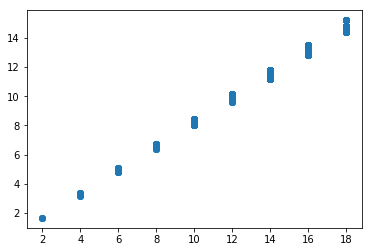

In [58]:
x = []
y = []
for data in vol_list_2:
    print data[0], data[1], data[-1]
    x.append(data[-1])
    y.append(data[1])
plt.scatter(x, np.reciprocal(y))

In [16]:
vol_list_2 = generate_vol(10, coeff=2)

(1, 0, 0)
2
reset starting point:  0.561442491052 0.670298474884 0.566861549284
solution:  [ 1.50000371  1.49999568  1.00000015]
guessed vol:  0.5925925926130731
Done.
('vol:', 0.5925925926130731, '; sol:', [1.5000037053951973, 1.4999956761861397, 1.0000001546030413])

(1, 1, 0)
2
reset starting point:  0.875803567656 0.816870125328 0.760854701834
solution:  [ 1.49999997  1.50000655  1.50000166]
guessed vol:  0.5925925925985212
Done.
('vol:', 0.5925925925985212, '; sol:', [1.4999999694644557, 1.5000065452259592, 1.5000016591065992])

(1, 1, 1)
2
reset starting point:  0.842439037926 0.545594059241 0.182707609276


solution:  [  2.70274551e+38   3.26092276e+38  -4.89496927e+38]
guessed vol:  -4.250668110320325e-155
volume:  -4.250668110320325e-155  is out of bounds.
reset starting point:  0.673444297941 0.797017914466 0.712850504108
solution:  [  1.03903570e+32   1.04205876e+32  -1.34978634e+32]
guessed vol:  -5.057963426653359e-129
volume:  -5.057963426653359e-129  is out of bounds.
reset starting point:  0.920111585283 0.0714661951283 0.452020572462
solution:  [ 1.4999949   1.49999865  2.49999971]
guessed vol:  0.5925925925985212
Done.
('vol:', 0.5925925925985212, '; sol:', [1.4999948982711409, 1.499998645704348, 2.4999997054924434])

(2, 0, 0)
4
reset starting point:  0.267899647648 0.27066179199 0.0462934025384
solution:  [ 1.49996138  1.49993949  1.99982817]
guessed vol:  0.29629630003182683
Done.
('vol:', 0.29629630003182683, '; sol:', [1.4999613764081259, 1.4999394882122803, 1.9998281659558736])

(2, 1, 0)
4
reset starting point:  0.927820689875 0.108883040965 0.105704288608


solution:  [ 1.46326451  1.46358656  2.53705321]
guessed vol:  0.31261580996215343
Done.
('vol:', 0.31261580996215343, '; sol:', [1.4632645129857855, 1.4635865626153326, 2.5370532133728996])

(2, 1, 1)
4
reset starting point:  0.142441539829 0.279339976723 0.669932414269
solution:  [ 1.49999553  1.50000087  3.50000267]
guessed vol:  0.29629629630653653
Done.
('vol:', 0.29629629630653653, '; sol:', [1.499995528017344, 1.500000874138801, 3.500002673115841])

(2, 2, 0)
4
reset starting point:  0.344708638991 0.706799505441 0.362507672921
solution: 

 [  1.00000000e+00   9.92309584e+28   2.00000000e+00]
guessed vol:  -5.077800484550565e-59
volume:  -5.077800484550565e-59  is out of bounds.
reset starting point:  0.80794360179 0.19284628502 0.18753814739
solution:  [ 1.49999736  1.50001193  3.00000715]
guessed vol:  0.2962962963283644
Done.
('vol:', 0.2962962963283644, '; sol:', [1.499997358345462, 1.500011925366168, 3.000007148682908])

(2, 2, 1)
4
reset starting point:  0.990936200847 0.26853668606 0.496597053824
solution:  [ 1.46383452  1.46434345  4.00076749]
guessed vol:  0.3126157212536782
Done.
('vol:', 0.3126157212536782, '; sol:', [1.4638345210284, 1.4643434499127728, 4.000767493100177])

(2, 2, 2)


4
reset starting point:  0.631762940122 0.374142327137 0.771175850471
solution:  [ 1.50000878  1.50000186  4.9999984 ]
guessed vol:  0.2962962962992606
Done.
('vol:', 0.2962962962992606, '; sol:', [1.500008777863218, 1.5000018569847402, 4.999998397232198])

(3, 0, 0)
6
reset starting point:  0.823657781933 0.911902261973 0.0806972769383
solution: 

 [ 1.49999364  1.50000482  3.00001025]
guessed vol:  0.1975308642058735
Done.
('vol:', 0.1975308642058735, '; sol:', [1.499993640186956, 1.5000048206834258, 3.000010249548492])

(3, 1, 0)
6
reset starting point:  0.597847516112 0.706386081458 0.195463064933
solution:  [ 1.46729579  1.46731338  3.57536969]
guessed vol:  0.20731663259721245
Done.
('vol:', 0.20731663259721245, '; sol:', [1.467295793947168, 1.4673133799730382, 3.575369688626381])

(3, 1, 1)
6
reset starting point:  0.158720794802 0.327278134316 0.47171068725
solution: 

 [ 1.49999831  1.50000458  4.50000241]
guessed vol:  0.197530864208602
Done.
('vol:', 0.197530864208602, '; sol:', [1.4999983117972941, 1.5000045758347926, 4.500002406592519])

(3, 2, 0)
6
reset starting point:  0.455794308397 0.28264478417 0.511744876045
solution:  [ 1.46731551  1.46730381  4.02271155]
guessed vol:  0.20731663259175548
Done.
('vol:', 0.20731663259175548, '; sol:', [1.4673155110699998, 1.4673038086696255, 4.022711553350147])

(3, 2, 1)
6
reset starting point:  0.995350061033 0.338586641968 0.047847291304
solution: 

 [ 4.16685535  0.79364395 -2.14521327]
guessed vol:  -0.2098831414074333
volume:  -0.2098831414074333  is out of bounds.
reset starting point:  0.630216282063 0.543602150185 0.81294583775
solution:  [ 1.4673092   1.46731323  5.0426605 ]
guessed vol:  0.20731663256810862
Done.
('vol:', 0.20731663256810862, '; sol:', [1.4673091950959847, 1.4673132259825652, 5.0426605028287455])

(3, 2, 2)
6
reset starting point:  0.741406274606 0.287290799446 0.770881156028
solution:  [ 1.49999747  1.50000538  6.00000862]
guessed vol:  0.19753086419768806
Done.
('vol:', 0.19753086419768806, '; sol:', [1.4999974685747448, 1.5000053798861916, 6.000008623299139])

(3, 3, 0)


6
reset starting point:  0.838560061302 0.509077927438 0.510372277635
solution:  [ 1.50001416  1.49999192  4.49994221]
guessed vol:  0.19753086424680077
Done.
('vol:', 0.19753086424680077, '; sol:', [1.5000141588062215, 1.4999919248782994, 4.499942213397944])

(3, 3, 1)
6
reset starting point:  0.425729484149 0.721835258279 0.690973417534
solution:  [ 3.74866519  3.74863225 -2.75591828]
guessed vol:  -0.001645077201260392


volume:  -0.001645077201260392  is out of bounds.
reset starting point:  0.383090059541 0.859510914529 0.53470778585
solution:  [ 3.74865654  3.74863885 -2.75589775]
guessed vol:  -0.001645077201260392
volume:  -0.001645077201260392  is out of bounds.
reset starting point:  0.796966649053 0.469353706205 0.897412235862
solution:  [ 1.46732568  1.4673027   5.48998265]
guessed vol:  0.20731663261449285
Done.
('vol:', 0.20731663261449285, '; sol:', [1.4673256766191822, 1.46730269673159, 5.4899826521035])

(3, 3, 2)
6
reset starting point:  0.145445067399 0.474724428782 0.970066564194
solution:  [ 0.79364394  4.16685535  8.76806488]
guessed vol:  -0.2098831414074334
volume: 

 -0.2098831414074334  is out of bounds.
reset starting point:  0.26376666948 0.457683236286 0.084899976829
solution: 

 [  2.23947958e+38   3.29523049e+38  -2.28155884e+39]
guessed vol:  -7.318349654401091e-156
volume:  -7.318349654401091e-156  is out of bounds.
reset starting point:  0.371632177777 0.926394665426 0.130279880612
solution: 

 [  2.04597140e+38   3.97078747e+38  -2.15700656e+39]
guessed vol:  -6.721320274718443e-156
volume:  -6.721320274718443e-156  is out of bounds.
solution out of bounds.
reset starting point:  0.334343474792 0.927262287185 -0.104758893369
solution:  [  1.80708005e+38   3.89369555e+38  -2.15938631e+39]
guessed vol:  -7.532714392866727e-156
volume:  -7.532714392866727e-156  is out of bounds.
reset starting point: 

 0.686290341481 0.680301533249 -0.0569865731049
solution:  [  2.53963311e+38   2.83069862e+38  -2.08151365e+39]
guessed vol:  -1.0035263544071874e-155
volume:  -1.0035263544071874e-155  is out of bounds.
reset starting point:  0.0375754399853 0.913692428455 -0.386133166285


solution:  [  1.06312434e+37   2.25075349e+38  -1.27967785e+39]
guessed vol:  -5.1215865641855116e-154
volume:  -5.1215865641855116e-154  is out of bounds.
solution out of bounds.
reset starting point:  0.558904061693 0.326677532406 1.03100302976
solution:  [ 1.4673172   1.46730848  6.50995043]
guessed vol:  0.20731663258266053
Done.
('vol:', 0.20731663258266053, '; sol:', [1.4673171998665602, 1.4673084775570828, 6.50995042668014])

(3, 3, 3)
6
reset starting point:  0.417464746911 0.599298940664 0.542106885152
solution: 

 [  3.26801899e+38   3.73027985e+38  -1.63937248e+39]
guessed vol:  -8.44254683766742e-156
volume:  -8.44254683766742e-156  is out of bounds.
reset starting point:  0.427108038996 0.264386762024 0.954928445627
solution:  [ 1.49999172  1.49999905  7.50000294]
guessed vol:  0.19753086420496402
Done.
('vol:', 0.19753086420496402, '; sol:', [1.4999917180373186, 1.499999053032334, 7.5000029381108915])

(4, 0, 0)
8
reset starting point:  0.52911536609 0.233611802841 0.946524294236
solution:  [ 1.49998708  1.49999446  4.00001846]
guessed vol:  0.14814814816145372
Done.
('vol:', 0.14814814816145372, '; sol:', [1.4999870760999172, 1.4999944627989066, 4.000018461527954])

(4, 1, 0)


8
reset starting point:  0.0824427607822 0.0386350715047 0.924681044852
solution:  [ 1.47152881  1.47153899  4.6029732 ]
guessed vol:  0.15443680656608194
Done.
('vol:', 0.15443680656608194, '; sol:', [1.4715288109660745, 1.4715389896079059, 4.602973199397179])

(4, 1, 1)
8
reset starting point:  0.255262731856 0.0546666968403 0.579555671974
solution: 

 [ 1.5000058   1.50000245  5.49999421]
guessed vol:  0.14814814811688848
Done.
('vol:', 0.14814814811688848, '; sol:', [1.5000057954234232, 1.5000024494988633, 5.499994209534222])

(4, 2, 0)
8
reset starting point:  0.266662322636 0.599639434218 0.293260147242
solution:  [ 0.76393202  5.23606798  0.81528171]
guessed vol:  -0.06250000000000001
volume:  -0.06250000000000001  is out of bounds.
reset starting point:  0.71679064282 0.296223026097 0.645818897826
solution: 

 [ 1.46430688  1.46413043  5.07097279]
guessed vol:  0.1563078537583351
Done.
('vol:', 0.1563078537583351, '; sol:', [1.4643068808213506, 1.464130433184049, 5.070972793416878])

(4, 2, 1)
8
reset starting point:  0.715398633101 0.612734888249 0.25085525735
solution:  [ 2.38549818  2.38552817  0.23576487]
guessed vol:  -0.027415939357638308


volume:  -0.027415939357638308  is out of bounds.
reset starting point:  0.183151509598 0.516950111893 0.0605116812883
solution:  [  3.85573579e+38   7.76924560e+38  -3.46623870e+39]
guessed vol:  -2.5982920837225753e-156
volume:  -2.5982920837225753e-156  is out of bounds.
reset starting point:  0.180340149272 0.133544924836 0.957771998625
solution:  [ 1.4715286   1.47153969  6.07451286]
guessed vol:  0.15443680654425407
Done.
('vol:', 0.15443680654425407, '; sol:', [1.4715285955778108, 1.4715396855494471, 6.074512861769247])

(4, 2, 2)


8
reset starting point:  0.531246497476 0.501961444407 0.86575230623
solution: 

 [  2.31242447e+36   3.08267578e+36  -1.56649129e+37]
guessed vol:  -4.695272854194356e-147
volume:  -4.695272854194356e-147  is out of bounds.
reset starting point:  0.228207706033 0.775487178304 0.626075670238
solution: 

 [  1.38817251e+38   2.29791799e+38  -9.58139798e+38]
guessed vol:  -2.9162971056422696e-154
volume:  -2.9162971056422696e-154  is out of bounds.
reset starting point:  0.273641730949 0.0818227333142 0.62755427932
solution:  [ 1.49999418  1.50002162  7.00010706]
guessed vol:  0.14814814823603228
Done.
('vol:', 0.14814814823603228, '; sol:', [1.4999941825810772, 1.5000216168289262, 7.000107063019781])

(4, 3, 0)


8
reset starting point:  0.42563463742 0.856505331669 0.572594590868
solution:  [ 0.71610702  9.6561743   1.10711629]
guessed vol:  -0.011347286890784538
volume:  -0.011347286890784538  is out of bounds.
reset starting point:  0.886609672378 0.611635028627 0.998421788738
solution: 

 [ 1.47152411  1.47153348  5.51092002]
guessed vol:  0.15443680655153003
Done.
('vol:', 0.15443680655153003, '; sol:', [1.471524107062306, 1.471533477247891, 5.510920024767511])

(4, 3, 1)
8
reset starting point:  0.223522506745 0.951686536692 0.895755589008
solution: 

 [ 3.00001185  2.99998879 -2.21113549]
guessed vol:  -0.004629629629789633
volume:  -0.004629629629789633  is out of bounds.
reset starting point:  0.269968277897 0.273627880295 0.650582234306
solution: 

 [ 1.46438238  1.46411115  6.53477408]
guessed vol:  0.15630785636932387
Done.
('vol:', 0.15630785636932387, '; sol:', [1.4643823774055926, 1.4641111546858516, 6.534774079973266])

(4, 3, 2)
8
reset starting point:  0.0168755491973 0.904694579369 0.824692810827
solution: 

 [  6.08197802e+36   2.06360573e+38  -1.15974041e+39]
guessed vol:  -1.9157034579847002e-153
volume:  -1.9157034579847002e-153  is out of bounds.
reset starting point:  0.321600166621 0.397497100894 0.770608177811
solution:  [ 2.38550954  2.38551937  2.62126569]
guessed vol:  -0.027415939355591945
volume:  -0.027415939355591945  is out of bounds.
reset starting point:  0.326200372502 0.77914119777 0.91665062565
solution:  [ 2.38547805  2.38555724  2.62136992]
guessed vol:  -0.027415939367273268
volume:  -0.027415939367273268  is out of bounds.
reset starting point:  0.0626132697802 0.842322291661 -0.808909037915
solution: 

 [  1.90522317e+37   2.23708034e+38  -1.60327668e+39]
guessed vol:  -3.127504478049752e-154
volume:  -3.127504478049752e-154  is out of bounds.
reset starting point:  0.739387123044 0.230925875944 -0.592482921036


solution:  [  2.39593148e+38   2.44669869e+38  -1.64142193e+39]
guessed vol:  -4.147096320542973e-155
volume:  -4.147096320542973e-155  is out of bounds.
reset starting point:  0.843042903648 0.525460045521 -0.726722223987
solution:  [ 2.38550491  2.38552172  2.62127365]
guessed vol:  -0.027415939357297248
volume:  -0.027415939357297248  is out of bounds.
reset starting point:  0.360570058654 0.0867757816925 1.6680683693
solution:  [ 1.4715001   1.47152727  7.54608033]
guessed vol:  0.1544368065915478


Done.
('vol:', 0.1544368065915478, '; sol:', [1.4715001011181503, 1.4715272720096277, 7.546080325261617])

(4, 3, 3)
8
reset starting point:  0.51061549811 0.393955351516 0.139959902534


solution:  [  1.18087426e+38   1.47265187e+38  -8.39166073e+38]
guessed vol:  -4.1112341383341794e-154
volume:  -4.1112341383341794e-154  is out of bounds.
reset starting point:  0.281568007724 0.791179447762 0.532556157305


solution:  [  1.31014047e+38   2.40206043e+38  -1.21684263e+39]
guessed vol:  -9.207860190251733e-155
volume:  -9.207860190251733e-155  is out of bounds.
reset starting point:  0.764360685718 0.529659043244 0.0246507567493
solution:  [  2.28812635e+38   1.05692794e+38  -8.42947593e+38]
guessed vol:  -9.165352433681063e-154
volume:  -9.165352433681063e-154

  is out of bounds.
solution out of bounds.
reset starting point:  0.561631413217 0.382668610962 -0.414981833425
solution:  [  6.66540885e+37   3.72103125e+37  -3.26427349e+38]
guessed vol:  -3.252587231558186e-152
volume:  -3.252587231558186e-152  is out of bounds.
reset starting point:  0.397339859805 0.631152216842 -0.0775410688981
solution: 

 [  1.88319737e+38   2.50457081e+38  -1.46595031e+39]
guessed vol:  -4.765676685851005e-155
volume:  -4.765676685851005e-155  is out of bounds.
reset starting point:  0.819528627338 0.481842937433 -0.642913654613
solution: 

 [  7.68282400e+37   6.02064557e+37  -4.51133239e+38]
guessed vol:  -6.818152362714129e-153
volume:  -6.818152362714129e-153  is out of bounds.
solution out of bounds.
reset starting point:  0.203861165058 0.830040263871 1.04995510674
solution:  [  1.44159517e+38   3.12364307e+38  -1.45730907e+39]
guessed vol:  -4.2680869264095885e-155
volume:  -4.2680869264095885e-155  is out of bounds.
reset starting point:  0.513082256643 0.0640188392521 1.80082659987
solution:  [ 1.50000328  1.49998065  8.49995512]
guessed vol:  0.14814814817327715
Done.
('vol:', 0.14814814817327715, '; sol:', [1.500003281136487, 1.4999806475586395, 8.499955118961276])

(4, 4, 0)


8
reset starting point:  0.355470638284 0.583025710123 0.0868481968257


solution:  [  1.00000000e+00   5.10548513e+21   4.00000000e+00]
guessed vol:  -9.591046087630083e-45
volume:  -9.591046087630083e-45  is out of bounds.
reset starting point:  0.778533993554 0.857734090841 0.93934932175
solution:  [ 1.50000003  1.49999186  5.99999179]
guessed vol:  0.14814814816054422
Done.
('vol:', 0.14814814816054422, '; sol:', [1.5000000335109915, 1.499991860719729, 5.9999917899318325])

(4, 4, 1)
8
reset starting point:  0.457280944644 0.75390084877 0.415697779383
solution:  [ 4.38275447  4.38278427 -7.10459473]


guessed vol:  -0.000538229697525594
volume:  -0.000538229697525594  is out of bounds.
reset starting point:  0.295741072961 0.220012084436 0.400412888205
solution: 

 [ 1.4715817   1.47151986  6.98220385]
guessed vol:  0.1544368067807227
Done.
('vol:', 0.1544368067807227, '; sol:', [1.4715817042256298, 1.4715198608405053, 6.982203845821197])

(4, 4, 2)
8
reset starting point:  0.240187083198 0.971156551127 0.746541380114
solution: 

 [  2.39826427e+38   7.79613569e+38  -3.27341682e+39]
guessed vol:  -1.3628888910501446e-156
volume:  -1.3628888910501446e-156  is out of bounds.
reset starting point:  0.624926708206 0.666516555055 0.703148783497
solution:  [ 2.99998267  3.00001986  0.78897385]
guessed vol:  -0.004629629629988585
volume:  -0.004629629629988585  is out of bounds.
reset starting point:  0.235428874909 0.769065946229 0.0433013023002
solution:  [  2.33309858e+38   6.26671658e+38  -4.44992524e+39]
guessed vol:  -1.0894965216149757e-156
volume:  -1.0894965216149757e-156  is out of bounds.


solution out of bounds.
reset starting point:  0.025728354158 0.237611076149 -0.397154225481
solution:  [  1.12638696e+37   9.55912800e+37  -9.90367180e+38]
guessed vol:  -2.853024493168866e-153
volume:  -2.853024493168866e-153  is out of bounds.
reset starting point:  0.81151077348 0.508559983125 -0.367749472136
solution:  [ 3.00003952  2.99996128  0.78874198]
guessed vol:  -0.004629629630684917
volume:  -0.004629629630684917  is out of bounds.
reset starting point:  0.0617836740667 

0.234316517515 -0.888192349981
solution:  [  1.03092506e+38   3.77609522e+38  -4.85625033e+39]
guessed vol:  -3.6112332588340145e-156
volume:  -3.6112332588340145e-156

  is out of bounds.
solution out of bounds.
reset starting point:  0.309618133982 0.443412472243 1.86375071392
solution:  [ 1.46398015  1.46407893  8.00049724]
guessed vol:  0.15630785189568996
Done.
('vol:', 0.15630785189568996, '; sol:', [1.4639801490492241, 1.4640789346684933, 8.000497243053227])

(4, 4, 3)


8
reset starting point:  0.672849858099 0.0432022176142 0.582543595209
solution:  [ 1.47153732  1.47152082  9.01753138]
guessed vol:  0.15443680654789205
Done.
('vol:', 0.15443680654789205, '; sol:', [1.471537323599883, 1.4715208214102558, 9.017531379300772])

(4, 4, 4)


8
reset starting point:  0.623283524237 0.723624875356 0.867008770479
solution: 

In [411]:
for i in range(len(euler)):
    print [euler[i], vol_list[i]]

[2, 0.5925925925985212]
[2, 0.592592592627625]
[2, 0.5925925925985212]
[4, 0.29629629637202015]
[4, 0.31261569794151]
[4, 0.2962962963339417]
[4, 0.296296296294019]
[4, 0.3126156984158115]
[4, 0.29629629632108845]
[6, 0.1975308642249729]
[6, 0.2073166325559087]
[6, 0.19753086423837335]
[6, 0.20731663261497255]
[6, 0.20731663259357447]
[6, 0.19753086426089794]
[6, 0.1975308644305187]
[6, 0.20731663258345634]
[6, 0.20731663259994093]
[6, 0.197530864206783]
[8, 0.14814814816054422]
[8, 0.15443680658539227]
[8, 0.14814814815685898]
[8, 0.15630784915288132]
[8, 0.15443680656608194]
[8, 0.1481481481660012]
[8, 0.1544368066606694]
[8, 0.15630785018350934]
[8, 0.15443680655880598]
[8, 0.1481481481487208]
[8, 0.1481481481641822]
[8, 0.15443680656244396]
[8, 0.1563078489862164]
[8, 0.15443680655153003]
[8, 0.14814814815326827]
[10, 0.11851852849861189]
[10, 0.12286659388063978]
[10, 0.11851852713359609]
[10, 0.12481159327217028]
[10, 0.12286659406788658]
[10, 0.11851852491963655]
[10, 0.12481159

216
216


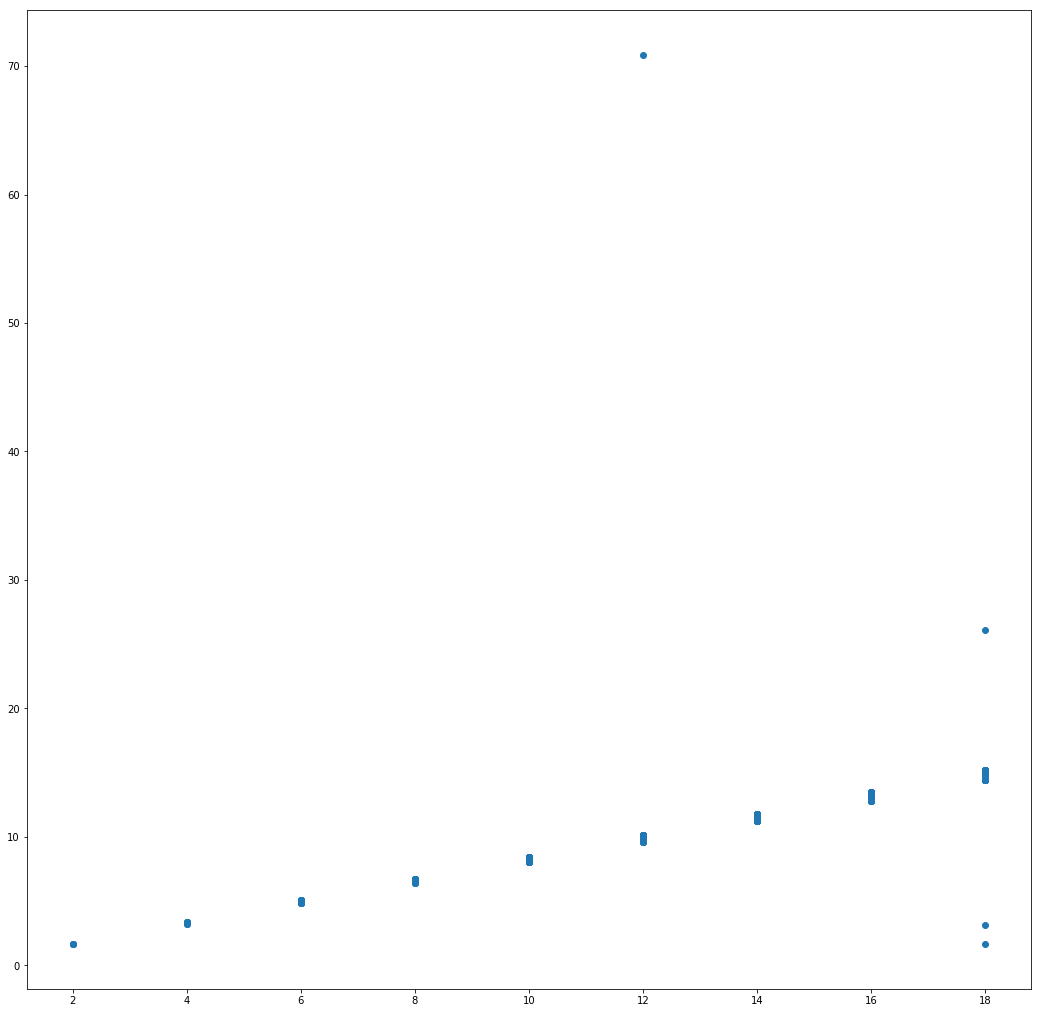

In [8]:
import matplotlib.pyplot as plt

euler_file = open('euler_data_tmp.txt', 'r')
euler = []
vol_list = []
for line in euler_file:
    data = eval(line)
    euler.append(data[0])
    vol_list.append(data[1])
    
print len(euler)
print len(vol_list)

fig = plt.figure(figsize=(18, 18))
plt.scatter(euler, np.reciprocal(np.array(vol_list)))
plt.show()

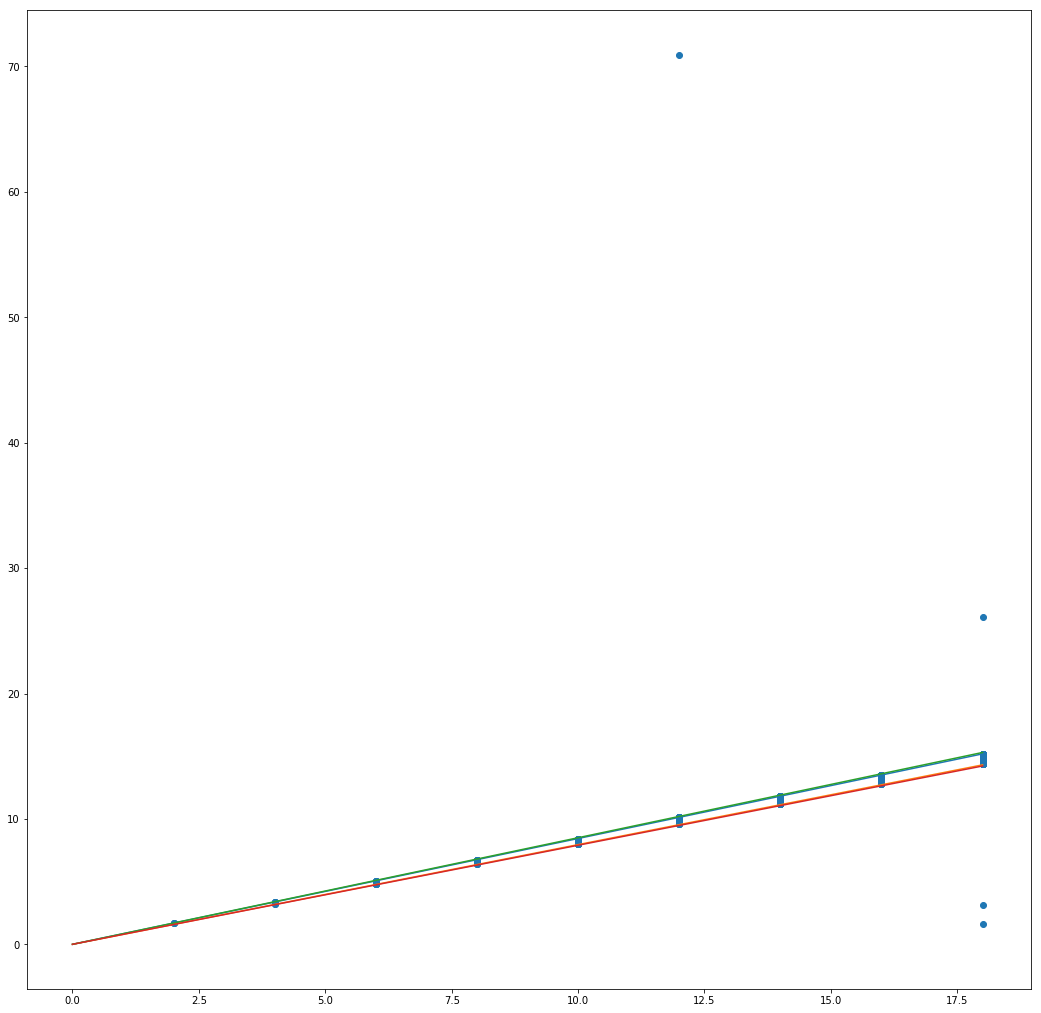

In [43]:
def eq1(x):
    return 0.84375*x
def eq2(x):
    return 0.795*x

def eq3(x):
    return 0.85*x
def eq4(x):
    return 0.79*x

fig = plt.figure(figsize=(18, 18))
x_range = np.array(range(0, 19))
plt.plot(x_range, eq1(x_range))
plt.plot(x_range, eq2(x_range))
plt.plot(x_range, eq3(x_range))
plt.plot(x_range, eq4(x_range))
plt.scatter(euler, np.reciprocal(np.array(vol_list)))
plt.show()

In [17]:
vol_max = 0
vol_min = 1
for i in range(len(euler)):
    if euler[i] == 18:
        vol = vol_list[i]
        if vol < 1/20.0 or vol > 1/10.0:
            continue
        if vol > vol_max:
            vol_max = vol
        elif vol < vol_min:
            vol_min = vol

In [35]:
def eq1(x):
    return 0.85*x
def eq2(x):
    return 0.795*x

for i in range(len(vol_list)):
    vol = 1/vol_list[i]
    x = euler[i]
    if vol > eq1(x) or vol < eq2(x):
        print x, vol, eq1(x), eq2(x)

12 70.8772585113 10.2000000000000 9.54000000000000
18 1.63853392401 15.3000000000000 14.3100000000000
18 3.1458901858 15.3000000000000 14.3100000000000
18 26.1224691362 15.3000000000000 14.3100000000000


In [20]:
for i in range(len(euler)):
    if euler[i] == 2:
        vol = vol_list[i]
        print 1/vol

1.68749999998
1.6874999999
1.68749999998


In [22]:
y0 = 1.68745
y1 = 1/vol_max
x0 = 2
x1 = 18
m = (y1 - y0)/(x1 - x0)
k = y0 - m*x0
print m
print k

0.794721386010046
0.0980072279799074


In [401]:
verts = [[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 2], [1, 0, 0], [1, 1, 0]]
p = Polyhedron(vertices = verts)
series, triang, power, vol, sol, num_triang = poly_vol(p)

[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 2], [1, 0, 0], [1, 1, 0]]


volume bound:  0.333333333333
5
5
reset starting point:  0.436694142588 0.481441322208 0.66924525185
solution:  

[ 1.46406563  1.46408355  5.07188878]
guessed vol:  0.1563078490476073
Done.
('vol:', 0.1563078490476073, '; sol:', [1.4640656276935466, 1.464083548393636, 5.071888783562578])


In [7]:
import pickle
def save_obj(obj, name):
    data = os.path.expanduser('~/Calabi_Yau/data')
    with open(data + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    data = os.path.expanduser('~/Calabi_Yau/data')
    with open(data + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
# save_obj(vol_dict, 'vol_0_10_test')
vol_dict = load_obj('vol_0_10_test')
print 'Done.'

Done.


In [9]:
import matplotlib.pyplot as plt 

def find_euler(p):
    verts = p.vertices()
    pts = np.array(verts)
    pts_max = np.amax(pts, axis=0)+1
    pts_min = np.amin(pts, axis=0)-1
    pts_new = []
    for i in range(pts_min[0], pts_max[0]):
        for j in range(pts_min[1], pts_max[1]):
            for k in range(pts_min[2], pts_max[2]):
                if p.contains([i,j,k]):
                    pts_new.append([i,j,k])
    print pts_new
    poly = PointConfiguration(pts_new)
    triang_idx = poly.restrict_to_regular_triangulations(True).triangulations_list()
#     print triang_idx
    triang_idx = max(triang_idx, key=len)
    num_triang = len(triang_idx)
    return num_triang

euler = []
vol_list = []
for h1 in range(1,10):
    for h2 in range(h1+1):
        for h3 in range(h2+1):
            verts = [[1,0,0],[0,0,0],[0,0,h1],[0,1,h2],[1,1,h3]]
            p = Polyhedron(vertices = verts)
            num_triang = find_euler(p)
            euler.append(num_triang)
            vol_data = vol_dict["%d_%d_%d"%(h1,h2,h3)]
            vol_dict["%d_%d_%d"%(h1,h2,h3)] = [num_triang] + vol_data
            
print 'Done.'

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 2], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 2], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 2], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 2], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 2], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 2], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 3], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 3], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 3], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 3], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 2], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 2], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 2], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 3], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 3], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 3], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 3], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 4], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 4], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 4], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 4], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 4], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 2], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 2], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 2], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 3], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 3], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 3], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 3], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 4], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 4], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 4], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 4], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 4], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 5], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 5], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 5], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 5], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 5], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 1, 5], [1, 0, 0], [1, 1, 5]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 2], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 2], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 2], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 3], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 3], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 3], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 3], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 4], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 4], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 4], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 4], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 4], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 5], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 5], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 5], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 5], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 5], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 5], [1, 0, 0], [1, 1, 5]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 6], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 6], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 6], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 6], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 6], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 6], [1, 0, 0], [1, 1, 5]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 1, 6], [1, 0, 0], [1, 1, 6]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 2], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 2], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 2], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 3], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 3], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 3], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 3], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 4], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 4], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 4], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 4], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 4], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 5], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 5], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 5], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 5], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 5], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 5], [1, 0, 0], [1, 1, 5]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 6], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 6], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 6], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 6], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 6], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 6], [1, 0, 0], [1, 1, 5]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 6], [1, 0, 0], [1, 1, 6]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 7], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 7], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 7], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 7], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 7], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 7], [1, 0, 0], [1, 1, 5]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 7], [1, 0, 0], [1, 1, 6]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 1, 7], [1, 0, 0], [1, 1, 7]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 2], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 2], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 2], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 3], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 3], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 3], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 3], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 4], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 4], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 4], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 4], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 4], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 5], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 5], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 5], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 5], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 5], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 5], [1, 0, 0], [1, 1, 5]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 6], [1, 0, 0], [1, 1, 0]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 6], [1, 0, 0], [1, 1, 1]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 6], [1, 0, 0], [1, 1, 2]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 6], [1, 0, 0], [1, 1, 3]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 6], [1, 0, 0], [1, 1, 4]]


[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 0, 5], [0, 0, 6], [0, 0, 7], [0, 0, 8], [0, 1, 6], [1, 0, 0], [1, 1, 5]]


In [407]:
import matplotlib.pyplot as plt 
vol_list = []
euler = []
vol_dict = {}
for h1 in range(1,10):
    for h2 in range(h1+1):
        for h3 in range(h2+1):
            verts = [[1,0,0],[0,0,0],[0,0,h1],[0,1,h2],[1,1,h3]]
            p = Polyhedron(vertices = verts)
            series, triang, power, vol, sol, num_triang = poly_vol(p)
            vol_list.append(vol)
            euler.append(num_triang)
            vol_dict["%d_%d_%d"%(h1,h2,h3)] = [vol, sol]
plt.scatter(euler, vol_list)

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


volume bound:  1.0
2
2
reset starting point:  0.533763805968 0.0685355316723 0.12729611574
solution:  [ 1.499995    1.49999568  0.99999942]
guessed vol:  0.5925925925985212
Done.
('vol:', 0.5925925925985212, '; sol:', [1.4999949981835679, 1.499995683357956, 0.9999994161434994])
[[0, 0, 0], [0, 0, 1], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


volume bound:  1.0
2
2
reset starting point:  0.503552385478 0.460631419456 0.184385044695
solution:  [ 1.49999205  1.50000038  1.50001077]
guessed vol:  0.592592592627625
Done.
('vol:', 0.592592592627625, '; sol:', [1.499992046449128, 1.5000003777285935, 1.5000107716967306])
[[0, 0, 0], [0, 0, 1], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


volume bound:  1.0
2
2
reset starting point:  0.924372486881 0.0405927591595 0.563116661292
solution:  [ 1.49999715  1.49999711  2.4999971 ]
guessed vol:  0.5925925925985212
Done.
('vol:', 0.5925925925985212, '; sol:', [1.4999971544663397, 1.499997113930333, 2.499997100401714])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


volume bound:  0.5
3
3
reset starting point:  0.633683193735 0.781194705368 0.271371259489
solution:  [ 1.50001051  1.50002357  1.99998302]
guessed vol:  0.29629629637202015
Done.
('vol:', 0.29629629637202015, '; sol:', [1.500010513704113, 1.5000235668312114, 1.9999830174510929])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


volume bound:  0.5
3
3
reset starting point:  0.377107330768 0.165352162382 0.721891393267
solution:  [ 1.46409896  1.46409971  2.53589931]
guessed vol:  0.31261569794151
Done.
('vol:', 0.31261569794151, '; sol:', [1.4640989637916986, 1.4640997113793988, 2.535899307672724])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


volume bound:  0.5
3
3
reset starting point:  0.785620476513 0.6825418404 0.243100390821
solution: 

 [  1.48421314e+37   4.42120894e+37  -9.32561503e+37]
guessed vol:  -5.7657001970159435e-151
volume:  -5.7657001970159435e-151  is out of bounds.
reset starting point:  0.913394384614 0.767255043133 0.470472351947


solution:  [  1.07968323e+37   3.49920994e+37  -5.49429147e+37]
guessed vol:  -3.8825713159232715e-150
volume:  -3.8825713159232715e-150  is out of bounds.
reset starting point:  0.875366152111 0.324965746969 0.870234902602
solution:  [ 1.50001199  1.49999695  3.49999602]
guessed vol:  0.2962962963339417
Done.
('vol:', 0.2962962963339417, '; sol:', [1.5000119902441007, 1.499996954003249, 3.499996022982719])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 2], [1, 0, 0], [1, 1, 0]]


volume bound:  0.5
3
3
reset starting point:  0.292975766305 0.848664559857 0.810755167402
solution:  [  1.00000000e+00   3.64679434e+25   2.00000000e+00]
guessed vol:  -3.759650375444954e-52
volume:  -3.759650375444954e-52  is out of bounds.
reset starting point:  0.413861734593 0.70855410587 0.561935853739
solution: 

 [  1.00000000e+00   8.29011915e+24   2.00000000e+00]
guessed vol:  -7.275259001596027e-51
volume:  -7.275259001596027e-51  is out of bounds.
reset starting point:  0.612657911911 0.162855959833 0.0224920468813
solution:  [ 1.49999925  1.49999402  2.99999813]
guessed vol:  0.296296296294019
Done.
('vol:', 0.296296296294019, '; sol:', [1.4999992514466345, 1.4999940159460134, 2.9999981306820493])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 2], [1, 0, 0], [1, 1, 1]]


volume bound:  0.5
3
3
reset starting point:  0.45938712126 0.609442383725 0.361990015218
solution:  [ 3.          3.          0.39444873]
guessed vol:  -0.009259259259259264
volume:  -0.009259259259259264  is out of bounds.
reset starting point:  0.802594686459 0.748338177019 0.193946440228
solution:  [ 3.          3.          0.39444872]
guessed vol:  -0.009259259259259259
volume:  -0.009259259259259259  is out of bounds.
reset starting point:  0.752458158441 0.973511719716 0.942552015346
solution:  [ 3.          3.          0.39444872]
guessed vol:  -0.009259259259259259


volume:  -0.009259259259259259  is out of bounds.
reset starting point:  0.592439043394 0.33987624692 -0.341051114515
solution:  [ 3.          3.          0.39444872]
guessed vol:  -0.009259259259259257
volume:  -0.009259259259259257  is out of bounds.
reset starting point:  0.162096458867 0.887845041664 -0.438303518135
solution:  [  1.33708997e+38   6.32226314e+38  -2.52292641e+39]
guessed vol:  -2.740729263905063e-156
volume:  -2.740729263905063e-156

  is out of bounds.
reset starting point:  0.80526602253 0.00459382456528 -0.598020257674


solution:  [  2.18464718e+18   6.92843787e+15  -2.34221943e+18]
guessed vol:  4.3494461159560956e-71
volume:  4.3494461159560956e-71  is out of bounds.
solution out of bounds.
reset starting point:  0.0933710722733 0.872733164574 1.82801647787
solution:  [ 1.46405194  1.46410906  4.00010868]
guessed vol:  0.3126156984158115
Done.
('vol:', 0.3126156984158115, '; sol:', [1.4640519449601936, 1.4641090591707815, 4.00010867767662])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 2], [1, 0, 0], [1, 1, 2]]


volume bound:  0.5
3
3
reset starting point:  0.637540102621 0.801659102767 0.833333816592


solution:  [  9.68101258e+37   1.26616191e+38  -4.27950434e+38]
guessed vol:  -7.819808950757401e-154
volume:  -7.819808950757401e-154  is out of bounds.
reset starting point:  0.560147326868 0.422937772508 0.158459677568
solution:  [  4.49550904e+37   4.60232713e+37  -1.87535943e+38]
guessed vol:  -2.717597896171591e-152
volume:  -2.717597896171591e-152  is out of bounds.
reset starting point:  0.57831713225 0.162224317508 0.861441299556
solution:  [ 1.4999907   1.50000739  5.00001573]
guessed vol:  0.29629629632108845
Done.
('vol:', 0.29629629632108845, '; sol:', [1.4999906979451367, 1.5000073892740808, 5.000015733479815])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


volume bound:  0.5
4
4
reset starting point:  0.81629592175 0.704213904975 0.156376092493
solution:  [ 1.50001534  1.49999789  2.99999008]
guessed vol:  0.1975308642249729
Done.
('vol:', 0.1975308642249729, '; sol:', [1.5000153415047277, 1.4999978891457955, 2.9999900794482977])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


volume bound:  0.5
4
4
reset starting point:  0.0798291814945 0.306985577059 0.805690106068
solution:  

[ 1.46730986  1.46731165  3.57534684]
guessed vol:  0.2073166325559087
Done.
('vol:', 0.2073166325559087, '; sol:', [1.4673098566702343, 1.467311645897448, 3.5753468380346147])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


volume bound:  0.5
4
4
reset starting point:  0.886558101357 0.980990031859 0.969052562785
solution:  [  3.37730674e+34   3.96431014e+34  -1.75565538e+35]
guessed vol:  -2.0434621503272482e-139
volume: 

 -2.0434621503272482e-139  is out of bounds.
reset starting point:  0.329224665321 0.413994775932 0.0878932248908
solution:  [  2.40237998e+37   3.28491208e+37  -1.27668909e+38]
guessed vol:  -6.9356687460776e-151
volume:  -6.9356687460776e-151  is out of bounds.
reset starting point:  0.381753187151 0.154788990482 0.35403849829
solution:  [ 1.49999405  1.49997952  4.4999993 ]
guessed vol:  0.19753086423837335
Done.
('vol:', 0.19753086423837335, '; sol:', [1.499994048643332, 1.4999795195438361, 4.499999300824145])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 2], [1, 0, 0], [1, 1, 0]]


volume bound:  0.5
4
4
reset starting point:  0.20475642108 0.862007091052 0.150013332907
solution:  [ 0.73235969  7.43214102  0.76327875]
guessed vol:  -0.029410840074048067
volume:  -0.029410840074048067  is out of bounds.
reset starting point:  0.403692246975 0.200530342982 0.254627767411
solution:  [ 1.46731339  1.46733046  4.0227227 ]


guessed vol:  0.20731663261497255
Done.
('vol:', 0.20731663261497255, '; sol:', [1.467313388629722, 1.4673304643327307, 4.02272269841741])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 2], [1, 0, 0], [1, 1, 1]]


volume bound:  0.5
4
4
reset starting point:  0.729579122001 0.0169052215948 0.504196555974
solution: 

 [ 1.5324808   0.12528456  3.12153652]
guessed vol:  1.2451385105897137
volume:  1.2451385105897137  is out of bounds.
reset starting point:  0.650225631971 0.331391331765 0.847700353966
solution:  [ 1.46731793  1.46730902  5.0426333 ]
guessed vol:  0.20731663259357447
Done.
('vol:', 0.20731663259357447, '; sol:', [1.4673179316130815, 1.4673090183555364, 5.042633304546812])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 2], [1, 0, 0], [1, 1, 2]]


volume bound:  0.5
4
4
reset starting point:  0.523113825397 0.0353956195583 0.571866335101
solution: 

 [ 1.49997233  1.49999941  6.00003279]
guessed vol:  0.19753086426089794
Done.
('vol:', 0.19753086426089794, '; sol:', [1.4999723278180022, 1.4999994140389634, 6.0000327898522])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 3], [1, 0, 0], [1, 1, 0]]


volume bound:  0.5
4
4
reset starting point:  0.551871762195 0.856392477888 0.107854049853
solution: 

 [  9.99996585e-01   7.99592037e+10   3.00003130e+00]
guessed vol:  -5.2136494170017265e-23
volume:  -5.2136494170017265e-23  is out of bounds.
reset starting point:  0.229929116522 0.894857801889 0.663379750094
solution:  [  1.00000109e+00   5.88090280e+07   3.00000408e+00]
guessed vol:  -9.638085122513337e-17
volume:  -9.638085122513337e-17  is out of bounds.
reset starting point:  0.798424927757 0.730558861882 0.0427658695201
solution:  [ 1.49996914  1.50003899  4.50011948]
guessed vol:  0.1975308644305187
Done.
('vol:', 0.1975308644305187, '; sol:', [1.4999691438779603, 1.5000389886215841, 4.500119481342826])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 3], [1, 0, 0], [1, 1, 1]]


volume bound:  0.5
4
4
reset starting point:  0.161371536006 0.128816726774 0.701899310361
solution: 

 [ 1.46731249  1.46730605  5.49002366]
guessed vol:  0.20731663258345634
Done.
('vol:', 0.20731663258345634, '; sol:', [1.4673124881666133, 1.467306052740701, 5.490023662436527])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 3], [1, 0, 0], [1, 1, 2]]


volume bound:  0.5
4
4
reset starting point:  0.705298127612 0.943953760273 0.369383932978
solution:  [ 2.55276293  2.55274779  2.84497904]
guessed vol:  -0.019865604314759366
volume:  -0.019865604314759366  is out of bounds.
reset starting point:  0.783286607277 0.611213640187 0.134894173244


solution:  [  2.19325675e+38   5.16846389e+38  -8.74802992e+38]
guessed vol:  -2.361971909758022e-155
volume:  -2.361971909758022e-155  is out of bounds.
reset starting point:  0.245366348345 0.486159569975 0.940499644093
solution:  [ 2.55276269  2.55274828  2.8449805 ]
guessed vol:  -0.01986560431498674
volume:  -0.01986560431498674  is out of bounds.
reset starting point:  0.773821339487 0.170073566097 -0.565979172738
solution: 

 [ 2.55275028  2.55276247  2.84502241]
guessed vol:  -0.019865604314873053
volume:  -0.019865604314873053  is out of bounds.
reset starting point:  0.570424389928 0.00390395043105 -0.310554899914
solution:  [ 1345.38181769    51.660699   -8592.61597641]
guessed vol:  -1.072817322134765e-12
volume:  -1.072817322134765e-12  is out of bounds.
reset starting point:  0.551126095982 0.423752336545 -0.793063881156
solution:  [ 1.46731522  1.46729876  6.50994083]
guessed vol:  0.20731663259994093
Done.
('vol:', 0.20731663259994093, '; sol:', [1.4673152206920905, 1.4672987637008117, 6.509940827447292])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 3], [1, 0, 0], [1, 1, 3]]


volume bound:  0.5
4
4
reset starting point:  0.3431264643 0.273871816446 0.874178815499
solution:  [ 1.49999457  1.50000895  7.50002432]
guessed vol:  0.197530864206783
Done.
('vol:', 0.197530864206783, '; sol:', [1.4999945734518407, 1.5000089470016187, 7.500024317171902])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 0], [1, 0, 0], [1, 1, 0]]


volume bound:  0.333333333333
5
5
reset starting point:  0.520777483251 0.569086522347 0.629143628385
solution:  [ 1.5000059   1.49999934  3.99996358]
guessed vol:  0.14814814816054422
Done.
('vol:', 0.14814814816054422, '; sol:', [1.5000058976712876, 1.4999993440393817, 3.999963583830299])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 1], [1, 0, 0], [1, 1, 0]]


volume bound:  0.333333333333
5
5
reset starting point:  0.418336135905 0.234267034963 0.0936685915116
solution: 

 [ 1.47150306  1.4715189   4.60302125]
guessed vol:  0.15443680658539227
Done.
('vol:', 0.15443680658539227, '; sol:', [1.4715030556985937, 1.471518900513944, 4.603021249996526])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 1], [1, 0, 0], [1, 1, 1]]


volume bound:  0.333333333333
5
5
reset starting point:  0.849397665035 0.228550615094 0.676835460157
solution: 

 [ 1.50001079  1.50000036  5.49998024]
guessed vol:  0.14814814815685898
Done.
('vol:', 0.14814814815685898, '; sol:', [1.5000107906708184, 1.5000003614648438, 5.499980241547048])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 2], [1, 0, 0], [1, 1, 0]]


volume bound:  0.333333333333
5
5
reset starting point:  0.465187906804 0.624871912839 0.896018879046
solution: 

 [ 1.46406521  1.46410233  5.07198297]
guessed vol:  0.15630784915288132
Done.
('vol:', 0.15630784915288132, '; sol:', [1.4640652116699635, 1.4641023343958188, 5.071982965904411])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 2], [1, 0, 0], [1, 1, 1]]


volume bound:  0.333333333333
5
5
reset starting point:  0.518503775035 0.872950352669 0.223271497008
solution:  [ 2.38551597  2.38552218  0.23574828]
guessed vol:  -0.027415939355250885
volume:  -0.027415939355250885  is out of bounds.
reset starting point:  0.278509118448 0.355771803395 0.613125679619
solution: 

 [ 1.47154542  1.47153081  6.07448328]
guessed vol:  0.15443680656608194
Done.
('vol:', 0.15443680656608194, '; sol:', [1.471545424463705, 1.4715308074597107, 6.074483278244729])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 2], [1, 0, 0], [1, 1, 2]]


volume bound:  0.333333333333
5
5
reset starting point:  0.113796842334 0.84314084546 0.474259991449


solution:  [  1.15023353e+38   4.14336988e+38  -2.16624313e+39]
guessed vol:  -2.4754619938504026e-155
volume:  -2.4754619938504026e-155  is out of bounds.
reset starting point:  0.311959867075 0.644291604656 0.964639561975
solution:  [  2.84430620e+37   3.62248908e+37  -1.62618460e+38]
guessed vol:  -3.549558986380494e-151
volume:  -3.549558986380494e-151  is out of bounds.
reset starting point:  0.135374272864 0.427745997163 0.393174185828


solution:  [  1.83935041e+37   2.95741353e+37  -1.20620786e+38]
guessed vol:  -1.1264145336896679e-150
volume:  -1.1264145336896679e-150  is out of bounds.
solution out of bounds.
reset starting point:  0.734283479263 0.483017924435 -0.272442755659
solution: 

 [  2.01083228e+38   3.14339395e+38  -1.58663444e+39]
guessed vol:  -4.6818658604903756e-155
volume:  -4.6818658604903756e-155  is out of bounds.
reset starting point:  0.91821393558 0.611869489579 -0.808888037438
solution:  [  4.70945212e+38   5.70429548e+38  -3.31487961e+39]
guessed vol:  -2.6629321721817926e-156
volume:  -2.6629321721817926e-156  is out of bounds.


reset starting point:  0.360644296162 0.989266746408 -0.536069627487
solution:  [  1.42015209e+38   2.73283918e+38  -1.42999355e+39]
guessed vol:  -8.282930254586144e-155
volume:  -8.282930254586144e-155  is out of bounds.
solution out of bounds.
reset starting point:  0.240047468959 0.696834570695 1.41259644806
solution:  [ 1.49997776  1.49999472  7.00001749]
guessed vol:  0.1481481481660012
Done.
('vol:', 0.1481481481660012, '; sol:', [1.4999777613341623, 1.4999947171185015, 7.000017493005587])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 3], [1, 0, 0], [1, 1, 0]]


volume bound:  0.333333333333
5
5
reset starting point:  0.235980839493 0.22464733978 0.268881852937
solution: 

 [ 1.47155598  1.47149994  5.51080085]
guessed vol:  0.1544368066606694
Done.
('vol:', 0.1544368066606694, '; sol:', [1.4715559772708544, 1.4714999427644107, 5.510800852134967])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 3], [1, 0, 0], [1, 1, 1]]


volume bound:  0.333333333333
5
5
reset starting point:  0.322752283625 0.301354894036 0.473224722483
solution:  [ 1.46417352  1.46401852  6.53545713]
guessed vol:  0.15630785018350934
Done.
('vol:', 0.15630785018350934, '; sol:', [1.4641735242290321, 1.4640185190625559, 6.535457134734686])
[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 0, 4], [0, 1, 3], [1, 0, 0], [1, 1, 2]]


volume bound:  0.333333333333
5
5
reset starting point:  0.162657646417 0.617012495493 0.391799416305
solution:  [  1.17270131e+38   2.99967339e+38  -1.76805762e+39]


guessed vol:  -3.795391880386204e-155
volume:  -3.795391880386204e-155  is out of bounds.
reset starting point:  0.164286809728 0.572085523025 0.958110050843
solution:  [ 2.38550585  2.38551707  2.62126119]
guessed vol:  -0.027415939355478258
volume:  -0.027415939355478258  is out of bounds.
reset starting point:  0.401899798085 0.968633032905 0.290062307237
solution: 

In [375]:
def cube_stack(h1):
    # Sample triangulation of a 1x1x1 cube:
    triang_cube_1_1 = [[[0,0,0],[1,0,0],[1,1,0],[0,0,1]]]
    triang_cube_1_2 = [[[0,0,1],[1,0,1],[1,0,0],[1,1,1]]]
    triang_cube_1_3 = [[[0,0,1],[1,1,1],[1,1,0],[1,0,0]]]
    triang_cube_1_4 = [[[0,0,0],[1,1,0],[0,1,0],[0,0,1]]]
    triang_cube_1_5 = [[[0,0,1],[0,1,1],[1,1,0],[1,1,1]]]
    triang_cube_1_6 = [[[0,0,1],[0,1,1],[0,1,0],[1,1,0]]]
    triang_cube_1 = triang_cube_1_1 + triang_cube_1_2 + triang_cube_1_3 + triang_cube_1_4 + triang_cube_1_5 + triang_cube_1_6
    triang = triang_cube_1
    for h in range(1,h1):
        move = np.array([0,0,h])
        triang_moved = []
        for tetra in triang_cube_1:
            tetra_moved = []
            for p in tetra:
                tetra_moved.append((np.array(p) + move).tolist())
            triang_moved.append(tetra_moved)
        triang += triang_moved
    return triang

In [383]:
h1 = 9
series, triang, power = Hilb(cube_stack(h1))
vol, sol = solver(series, h1*2)

18
reset starting point:  0.113785692367 0.224931450099 0.0396208788137
solution: 

 [ 2.00932261  1.99672661  3.16067922]
guessed vol:  -0.00507541206530846
Done.
('vol:', 0.00507541206530846, '; sol:', [2.0093226147662393, 1.996726610369737, 3.16067922180887])


In [382]:
h1 = 10
series, triang, power = Hilb(cube_stack(h1))
vol, sol = solver(series, h1*2)

20
reset starting point:  0.841568532478 0.207712523924 0.850898791374


solution:  [ 2.0012357   1.97311394  5.86940559]
guessed vol:  -0.09477350852028225
Done.
('vol:', 0.09477350852028225, '; sol:', [2.001235703358472, 1.9731139368131199, 5.869405589634946])


In [384]:
import matplotlib.pyplot as plt 
vol_list = []
for h1 in range(1,20):
    series, triang, power = Hilb(cube_stack(h1))
    vol, sol = solver(series, h1*2)
    vol_list.append(vol)
    
plt.plot(vol_list)

2
reset starting point:  0.108388647791 0.800889983883 0.620117724952
solution:  [ 1.9997456   2.00060656  1.99920502]
guessed vol:  0.2500000667059794
Done.
('vol:', 0.2500000667059794, '; sol:', [1.9997455998289497, 2.0006065611372548, 1.9992050165361168])
4
reset starting point:  0.45183816592 0.546769767514 0.266504157761
solution:  [ 1.99990866  2.00008026  3.99963734]
guessed vol:  0.1250000037252903
Done.
('vol:', 0.1250000037252903, '; sol:', [1.9999086614018025, 2.000080260298802, 3.999637340601439])


6
reset starting point:  0.867105553053 0.897386434325 0.876748639337
solution:  [ 2.00026474  2.00004132  7.99876363]
guessed vol:  0.06250000279396772
Done.
('vol:', 0.06250000279396772, '; sol:', [2.000264739203078, 2.0000413220172804, 7.998763625396251])


8
reset starting point:  0.374453008797 0.79236987653 0.0318690743974
solution:  [ 2.00635241  2.00391557  6.23077823]
guessed vol:  0.033865147817927266
Done.
('vol:', 0.033865147817927266, '; sol:', [2.0063524138904962, 2.0039155694297603, 6.230778227979549])


10
reset starting point:  0.490531346099 0.908628944127 0.116804013918
solution:  [ 2.00170895  2.01149815  6.03022737]
guessed vol:  0.015791459420189113
Done.
('vol:', 0.015791459420189113, '; sol:', [2.0017089549045886, 2.011498150925628, 6.030227370043092])


12
reset starting point:  0.284994866907 0.815223375823 0.60804340199


solution:  [ 1.85528886  2.02488975  5.89179372]
guessed vol:  6.815142983374045e-05
volume:  6.815142983374045e-05  is out of bounds.
reset starting point:  0.30625867766 0.326474955471 0.421344987222
solution: 

 [ 1.99213519  2.00180757  5.93143111]
guessed vol:  -0.0005186012301194864
volume:  0.0005186012301194864  is out of bounds.
reset starting point:  0.873395812039 0.452987432386 0.595605017189
solution:  [ 1.98942186  1.99226468  5.87112107]
guessed vol:  0.00037366812641792535
volume:  0.00037366812641792535  is out of bounds.
reset starting point:  0.215674346499 0.0914184003281 -0.0536057416475
solution: 

 [  2.00018318e+00   2.00003405e+00  -5.70504284e+04]
guessed vol:  -9.820762084705865e-09
volume:  9.820762084705865e-09  is out of bounds.
reset starting point:  0.940587381398 0.304817043424 -0.00235156463751


solution:  [ 1.91343471  1.68459697 -0.01428595]
guessed vol:  -17.999129793911948
volume:  17.999129793911948  is out of bounds.
reset starting point:  0.0687289130566 0.0746067723911 -0.627921256188
solution:  [  2.00008633e+00   2.00009131e+00  -4.91397453e+04]
guessed vol:  -1.3234844773342685e-08
volume:  1.3234844773342685e-08  is out of bounds.
reset starting point:  0.133928887677 0.585438339696 1.64044780548
solution: 

 [ 1.41963441  1.97964698  5.90029637]
guessed vol:  -6.334716435851817e-05
volume:  6.334716435851817e-05  is out of bounds.
reset starting point:  0.247232061956 0.697381495085 1.50288944735
solution:  

[ 1.40615038  1.9574597   5.90512035]
guessed vol:  -0.00014194518511989607
volume:  0.00014194518511989607  is out of bounds.
reset starting point:  0.4723722677 0.28647747589 1.59508490372
solution:  [ 2.00051576  1.94737879  5.916974  ]
guessed vol:  -0.0003049392858545108
volume:  0.0003049392858545108  is out of bounds.
reset starting point:  0.693604663278 0.957171585031 -1.21866435063


solution:  [  1.99999288e+00   1.99998303e+00  -5.68724390e+09]
guessed vol:  -9.893415886423697e-19
volume:  9.893415886423697e-19  is out of bounds.
reset starting point:  0.422010155464 0.336686130428 -1.06869768815
solution:  [  2.00018302e+00   1.99980250e+00  -4.75566062e+14]
guessed vol:  -1.4149082440024647e-28
volume: 

 1.4149082440024647e-28  is out of bounds.
reset starting point:  0.345792390217 0.568416137687 -1.890998268


solution:  [  1.33820304e+05   1.21304909e+05  -9.02619200e+08]
guessed vol:  -2.3849939330056313e-36
volume:  2.3849939330056313e-36  is out of bounds.
solution out of bounds.
reset starting point:  0.90816250034 -0.285723057095 0.835315502121
solution:  [ 2.04086862 -3.58359407  5.91176978]


guessed vol:  3.353421991704984e-05
volume:  3.353421991704984e-05  is out of bounds.
reset starting point:  0.79089149284 -0.92461729357 0.524946720054
solution:  [   2.020896   -186.7768334     5.87413389]
guessed vol:  -3.694447622401353e-08
volume:  3.694447622401353e-08  is out of bounds.
reset starting point:  0.684068033029 -0.194389856326 0.546683348307
solution:  

[-156.08974914 -185.92128786    5.86147842]
guessed vol:  9.363028967868548e-12
volume:  9.363028967868548e-12  is out of bounds.
reset starting point:  0.950339099233 -0.617047964269 -0.500331792576
solution: 

 [  1.98126884e+00  -6.06235077e+08  -5.20421462e+08]
guessed vol:  1.2860429122292147e-33
volume:  1.2860429122292147e-33  is out of bounds.
reset starting point:  0.99939271987 -0.949784924235 -0.523366721543
solution:  [  2.00000001e+00  -3.83248822e+08  -2.29267440e+08]
guessed vol:  1.657919474907776e-32
volume:  1.657919474907776e-32  is out of bounds.
reset starting point:  0.878968421382 -0.26179021807 -0.559985217059
solution:  [  1.99935937e+00  -8.70692282e+08  -1.65334342e+09]
guessed vol:  6.176670766996426e-35
volume:  6.176670766996426e-35  is out of bounds.


reset starting point:  0.884194247068 -0.95874159588 1.7541586192


solution:  [ -1.84129485e+06  -5.23298475e+06   3.18210211e+01]
guessed vol:  1.4183748614260077e-26
volume:  1.4183748614260077e-26  is out of bounds.
reset starting point:  0.505195107445 -0.715135369071 1.29792776217
solution:  [  1.97915541 -49.48194226   5.96086167]
guessed vol:  1.4420764886129871e-06
volume:  1.4420764886129871e-06  is out of bounds.
reset starting point:  0.839835795839 -0.859610700156 1.26524392307


solution:  [ -96.17330839 -290.63129482    5.97864236]
guessed vol:  -2.360451228555983e-11
volume:  2.360451228555983e-11  is out of bounds.
reset starting point:  0.820732883244 -0.0687706163426 -1.13258823071


solution:  [-26667647.19602326  -1743763.4905402  -19163935.09815622]
guessed vol:  -6.4425257416719195e-40
volume:  6.4425257416719195e-40  is out of bounds.
reset starting point:  0.851612689612 -0.474924352051 -1.87219247736


solution:  [  1.99996446e+00  -1.92107546e+09  -7.50643507e+09]
guessed vol:  6.155361031513626e-37
volume:  6.155361031513626e-37  is out of bounds.
reset starting point:  0.298926125786 -0.625792689096 -1.32898499804


solution:  [  1.99978927e+00  -3.70353534e+08  -8.62501254e+08]
guessed vol:  1.2544618893651714e-33
volume:  1.2544618893651714e-33  is out of bounds.
reset starting point:  0.938540044737 1.71686635442 0.330033387847
solution:  [ 2.01939871  1.99017357  5.56205318]
guessed vol:  0.004965840000523247
Done.
('vol:', 0.004965840000523247, '; sol:', [2.0193987111059752, 1.990173569633702, 5.56205318367083])


14
reset starting point:  0.977955447602 0.642035766139 0.933479513186
solution: 

 [ 1.99887141  1.99429249  5.90493438]
guessed vol:  -0.018174315586534436
Done.
('vol:', 0.018174315586534436, '; sol:', [1.9988714070923796, 1.9942924871423993, 5.9049343809498405])


16
reset starting point:  0.27940154254 0.607947348763 0.712235384424
solution:  [ 1.99716069  2.00055061  5.83834512]


guessed vol:  -0.03749963168343083
Done.
('vol:', 0.03749963168343083, '; sol:', [1.9971606935993451, 2.0005506054633133, 5.83834512309138])


18
reset starting point:  0.534979133028 0.20463318162 0.0935061758539
solution:  [ 1.99807157  2.00078183  5.82610638]
guessed vol:  -0.06208972365919947
Done.


('vol:', 0.06208972365919947, '; sol:', [1.9980715670205196, 2.000781830630568, 5.826106377029007])


20
reset starting point:  0.693354545654 0.0105299790396 0.174976383417


solution:  [  1.99194109e+03   1.94698211e+00   5.75512388e+00]
guessed vol:  9.364972360434517e-08
volume:  9.364972360434517e-08  is out of bounds.
reset starting point:  0.592547595003 0.256490565073 0.759914507308
solution: 

 [ 2.00287643  1.9794147   5.78452067]
guessed vol:  -0.09319808637070087
Done.
('vol:', 0.09319808637070087, '; sol:', [2.0028764264649292, 1.9794147000166074, 5.7845206738484265])


22
reset starting point:  0.610032065712 0.243217867676 0.747237876847


solution:  [ 2.00184331  1.99900914  5.80553022]
guessed vol:  -0.13632482486473796
Done.
('vol:', 0.13632482486473796, '; sol:', [2.0018433128590534, 1.9990091435585162, 5.805530217065188])


24
reset starting point:  0.693769132604 0.599714987611 0.158103143052
solution: 

 [-627.04394001    2.00065309    5.29500592]
guessed vol:  1.8727088877807042e-06
volume:  1.8727088877807042e-06  is out of bounds.
reset starting point:  0.0682322722674 0.0930366772215 0.200974110149
solution:  [ 1.99986618  2.00062611  5.78706624]
guessed vol:  -0.19539764296039588
Done.
('vol:', 0.19539764296039588, '; sol:', [1.999866183436405, 2.0006261124307625, 5.787066238400402])


26
reset starting point:  0.0372469215271 0.916541731461 0.611088801913
solution:  [ 2.00359409  1.99999305  5.7772481 ]
guessed vol:  

-0.28033570657687323
Done.
('vol:', 0.28033570657687323, '; sol:', [2.003594091884494, 1.9999930471799774, 5.777248099131438])


28
reset starting point:  0.832212535896 0.0462489142047 0.420871478601
solution: 

 [ 2.00031882  1.98439338  5.76751075]
guessed vol:  -0.40523906352736755
Done.
('vol:', 0.40523906352736755, '; sol:', [2.000318822721243, 1.9843933776544131, 5.767510751342429])


2
reset starting point:  0.782012948506 0.827622934159 0.629362407524
solution:  [ 2.00020648  2.00066394  2.00069153]
guessed vol:  0.2500000603031367
Done.
('vol:', 0.2500000603031367, '; sol:', [2.0002064774500408, 2.000663944158221, 2.0006915316719294])
4
reset starting point:  0.898615153345 0.96518757518 0.665272492047
solution:  [ 1.9995118   1.99971688  4.00043545]
guessed vol:  0.12500001210719347
Done.
('vol:', 0.12500001210719347, '; sol:', [1.9995118047578864, 1.9997168791950102, 4.000435445004489])


6
reset starting point:  0.459338690451 0.871718503097 0.434901349208
solution: 

 [ 1.99983811  1.99950475  8.00034871]
guessed vol:  0.06250000419095159
Done.
('vol:', 0.06250000419095159, '; sol:', [1.9998381114234558, 1.9995047468808147, 8.000348713289144])


8
reset starting point:  0.28899035347 0.329156437933 0.733900169237
solution:  [ 2.00163327  1.99893603  6.2542778 ]
guessed vol:  0.033610836079510875
Done.
('vol:', 0.033610836079510875, '; sol:', [2.0016332703266793, 1.9989360282147566, 6.25427779508921])


10
reset starting point:  0.160389408572 0.801742596346 0.886117484409


solution:  [ 1.89610794  1.98937962  5.90191405]
guessed vol:  0.017551780157082808
Done.
('vol:', 0.017551780157082808, '; sol:', [1.8961079431004073, 1.9893796234059813, 5.901914051186669])


12
reset starting point:  0.443280975265 0.864254960237 0.947061891555
solution: 

 [ 1.94947993  1.95168194  5.97093075]
guessed vol:  -0.0011042868926800509
Done.
('vol:', 0.0011042868926800509, '; sol:', [1.9494799286144655, 1.9516819384596051, 5.9709307518623955])


14
reset starting point:  0.290030534333 0.285903817867 0.551037251677
solution: 

 [ 1.97397743  1.98558702  5.89801355]
guessed vol:  -0.01806844602586797
Done.
('vol:', 0.01806844602586797, '; sol:', [1.9739774291891679, 1.9855870237741087, 5.898013554433837])


16
reset starting point:  0.776422724464 0.014651125294 0.05047954484
solution: 

 [ 772.77206317    1.99936097    6.03478459]
guessed vol:  2.7465957544695053e-07
volume:  2.7465957544695053e-07  is out of bounds.
reset starting point:  0.271186307082 0.997648780588 0.304367488233
solution: 

 [ 1.99525918  1.9983638   5.83946134]
guessed vol:  -0.037518489526878765
Done.
('vol:', 0.037518489526878765, '; sol:', [1.995259183289604, 1.9983637970630865, 5.839461336364098])


18
reset starting point:  0.446791319938 0.37058959552 0.182851023751
solution: 

 [ -4.03412890e+04   1.99974959e+00   7.37655252e+00]
guessed vol:  2.2340348986346493e-10
volume:  2.2340348986346493e-10  is out of bounds.
reset starting point:  0.526387362238 0.747237336595 0.430378850282
solution:  [ 2.00164618  1.99950685  5.8779082 ]
guessed vol:  

-0.0630016659093651
Done.
('vol:', 0.0630016659093651, '; sol:', [2.0016461818852123, 1.9995068490327228, 5.877908199335883])


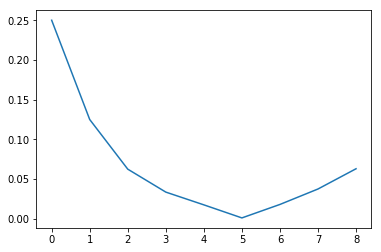

In [381]:
vol_list = []
for h1 in range(1,10):
    series, triang, power = Hilb(cube_stack(h1))
    vol, sol = solver(series, h1*2)
    vol_list.append(vol)
    
plt.plot(vol_list)

In [364]:
h1 = 2
# verts = [[1,0,0],[0,0,0],[0,0,h1],[0,1,0]]
verts = [[1,0,0],[0,0,0],[0,1,0],[1,1,0],[1,0,h1],[0,0,h1],[0,1,h1],[1,1,h1]]
p = Polyhedron(vertices = verts)
series, triang, power, vol, sol = poly_vol(p)

[[0, 0, 0], [0, 0, 1], [0, 0, 2], [0, 1, 0], [0, 1, 1], [0, 1, 2], [1, 0, 0], [1, 0, 1], [1, 0, 2], [1, 1, 0], [1, 1, 1], [1, 1, 2]]


volume bound:  0.25
3
3
reset starting point:  0.108119354575 0.952002224784 0.277264938923
solution: 

 [ 1.99958846  2.0000015   3.99971156]
guessed vol:  0.12500000617907356
Done.
('vol:', 0.12500000617907356, '; sol:', [1.999588460734248, 2.000001503459558, 3.999711560883024])


In [27]:
p = polygons[2]
verts = p.vertices()
h_max = max([max(abs(p) for p in pts) for pts in verts])
h_max += 1
inner_pts = []
for i in range(-h_max, h_max):
    for j in range(-h_max, eh_max):
        for k in range(-h_max, h_max):
            if p.contains([i,j,k]):
                inner_pts.append([i,j,k])
print inner_pts

[[-2, -2, -1], [-1, -1, 0], [0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]


In [38]:
print pts
print np.max(pts, axis=0) + 1

[[-2 -2 -1]
 [ 0  0  1]
 [ 0  1  0]
 [ 1  0  0]]
[2 2 2]


In [40]:
verts = p.vertices()
pts = np.array(verts)
pts_max = np.amax(pts, axis=0)+1
pts_min = np.amin(pts, axis=0)-1
print ('pts_max and pts_min: ', pts_max, pts_min)
# poly = p
pts_new = []
for i in range(pts_min[0], pts_max[0]):
    for j in range(pts_min[1], pts_max[1]):
        for k in range(pts_min[2], pts_max[2]):
#             if p.contains([i,j,k]):
#                 pts_new.append([i,j,k])
            latt = [i,j,k]
            if exist(pts, latt) == 1:
                continue
            if contain(poly, latt) == 1:
                pts_new = np.append(pts_new, np.array(latt).reshape((1,3)), axis = 0)  
pts_new = pts_new.tolist()
print pts_new

('pts_max and pts_min: ', array([2, 2, 2]), array([-3, -3, -2]))
[[-2, -2, -1], [-1, -1, 0], [0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]


In [15]:
pt_list = [[0,0,0],[1,0,0],[0,0,1],[0,1,0],[-1,-1,0],[-2,-2,-1]]
poly = PointConfiguration(pt_list)

In [19]:
poly.triangulate()

(<0,1,2,3>, <0,1,2,4>, <0,1,3,5>, <0,1,4,5>, <0,2,3,4>, <0,3,4,5>)

In [20]:
# triang_idx = [[0,1,2,3],[0,1,2,4],[0,1,4,5],[0,3,4,5],[0,2,3,4],[0,1,3,5]]
triang_idx = poly.triangulate()
triang = [[ pt_list[idx] for idx in idx_list] for idx_list in triang_idx]
print triang

[[[0, 0, 0], [1, 0, 0], [0, 0, 1], [0, 1, 0]], [[0, 0, 0], [1, 0, 0], [0, 0, 1], [-1, -1, 0]], [[0, 0, 0], [1, 0, 0], [0, 1, 0], [-2, -2, -1]], [[0, 0, 0], [1, 0, 0], [-1, -1, 0], [-2, -2, -1]], [[0, 0, 0], [0, 0, 1], [0, 1, 0], [-1, -1, 0]], [[0, 0, 0], [0, 1, 0], [-1, -1, 0], [-2, -2, -1]]]


In [21]:
series, triang, power = Hilb(triang)
print(series)
solver(series, (3,3,3), 3)

-1/((2*b1 - b2 - b3 + 4)*(b1 - b2)*(b1 - 2*b3)*b3) + 1/((2*b1 - b2 - b3 + 4)*(b1 - b2)*b1*b3) - 1/((b1 - b2)*(b1 - 2*b2 + b3 - 4)*(b2 - 2*b3)*b3) + 1/((b1 + b2 - 5*b3 - 4)*(b1 - 2*b3)*(b2 - 2*b3)*b3) + 1/((b1 - b2)*(b1 - 2*b2 + b3 - 4)*b2*b3) - 1/((b1 + b2 + b3 - 4)*b1*b2*b3)
reset starting point:  0.842802699642 0.314689284734 0.0465811896077
solution:  [ -9.99974341e-01  -1.00005477e+00  -1.87806403e-04]
guessed vol:  0.1666666679084301
Done.
('vol:', 0.1666666679084301, '; sol:', [-0.9999743411274298, -1.0000547719126662, -0.0001878064032707298])


/ext/sage/sage-8.4_1804/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(0.1666666679084301,
 [-0.9999743411274298, -1.0000547719126662, -0.0001878064032707298])

In [22]:
h1 = 2
h2 = 1
h3 = 0
print(h1,h2,h3)
prism, series, triang, power = lift_prism(h1, h2, h3)
triang = np.squeeze(np.array(triang))
power = np.squeeze(np.array(power))
print(series)
print(prism)
print(triang)
print(power)

(2, 1, 0)
(0, 1, 2)
1
1/((2*b1 + b2 + b3 - 12)*(2*b1 + b3 - 8)*(b1 - b2)*b1) + 1/((b1 + b3 - 4)*b1*(b2 + b3 - 4)*(b2 - 4)) - 1/((3*b1 + b3 - 12)*(2*b1 + b3 - 8)*(b1 - b2)*b2) + 1/((b1 - b2)*b1*(b2 + b3 - 4)*b3) - 1/((b1 - b2)*(b1 + b3 - 4)*b2*b3)
[[[1, 0, 0], [1, 1, 0], [0, 0, 0], [0, 0, 1]], [[0, 0, 0], [1, 1, 0], [0, 1, 0], [0, 0, 1]], [[1, 1, 0], [0, 1, 0], [0, 1, 1], [0, 0, 1]], [[1, 0, 0], [1, 1, 0], [0, 0, 2], [0, 0, 3]], [[1, 1, 0], [0, 1, 2], [0, 0, 2], [0, 0, 3]]]
[[[1 0 0 1]
  [1 1 0 1]
  [0 0 0 1]
  [0 0 1 1]]

 [[0 0 0 1]
  [1 1 0 1]
  [0 1 0 1]
  [0 0 1 1]]

 [[1 1 0 1]
  [0 1 0 1]
  [0 1 1 1]
  [0 0 1 1]]

 [[1 0 0 1]
  [1 1 0 1]
  [0 0 2 1]
  [0 0 3 1]]

 [[1 1 0 1]
  [0 1 2 1]
  [0 0 2 1]
  [0 0 3 1]]]
[[[ 0.  0.  1.  0.]
  [ 1. -1. -0. -0.]
  [ 0.  1.  0.  0.]
  [-1. -0. -1.  1.]]

 [[ 0.  0.  1.  0.]
  [-0. -1. -1.  1.]
  [ 1.  0.  0.  0.]
  [-1.  1. -0. -0.]]

 [[-0. -1. -0.  1.]
  [ 1.  0.  0.  0.]
  [-1. -0. -1.  1.]
  [ 0.  1.  1. -1.]]

 [[ 2.  0.  1. -2.]
  [ 1.

In [32]:
data_file = open('lift_1_40.txt', 'r')
data_x = []
data_y = []
for line in data_file:
  data = eval(line)
  if data[1] > 0:
    data_x.append(data[0])
    data_y.append(1/data[1])
    
print ('Number of data: ', len(data_x))

IOError: [Errno 2] No such file or directory: 'lift_1_40.txt'

In [41]:
series_file = open('series_2.txt', 'w')
triang_file = open('triang.txt', 'w')
power_file = open('power.txt', 'w')
triang_file.close()
power_file.close()

triang_list = []
power_list = []

for data in data_x:
    h1 = data[0]
    h2 = data[1]
    h3 = data[2]
    prism, series, triang, power = lift_prism(h1, h2, h3)
    triang = np.squeeze(np.array(triang))
    power = np.squeeze(np.array(power))
    triang_list.append(triang)
    power_list.append(power)
    series_file.write("%s\n"%(str(series)))
series_file.close()

triang_list = np.squeeze(np.array(triang_list))
power_list = np.squeeze(np.array(power_list))
np.savetxt('triang.txt', triang_list, fmt='%d')
np.savetxt('power.txt', power_list, fmt='%d')

In [8]:
test_file = open('test_triang.npy', 'w')
test_file.close()
for i in range(1,10):
    test_file = open('test_triang.npy', 'a')
    a1 = np.zeros((i,2))
    a2 = np.ones((2,i))
    test_file.close()

NotImplementedError: Multiple enlargeable (0-)dimensions are not supported.

In [6]:
test_file = open('test_triang.npy', 'r')
fsz = os.fstat(test_file.fileno()).st_size

IOError: Failed to interpret file <open file 'test_triang.npy', mode 'r' at 0x7f8028466db0> as a pickle